<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [3]:
download = False
if not os.path.isfile("./cifar-10-python.tar.gz"):
    download = True

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

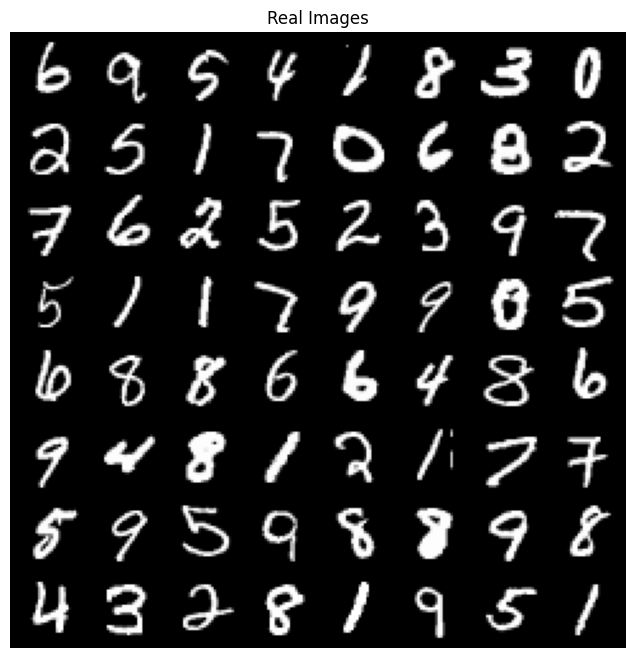

In [4]:
import matplotlib.pyplot as plt


real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

![image.png](attachment:./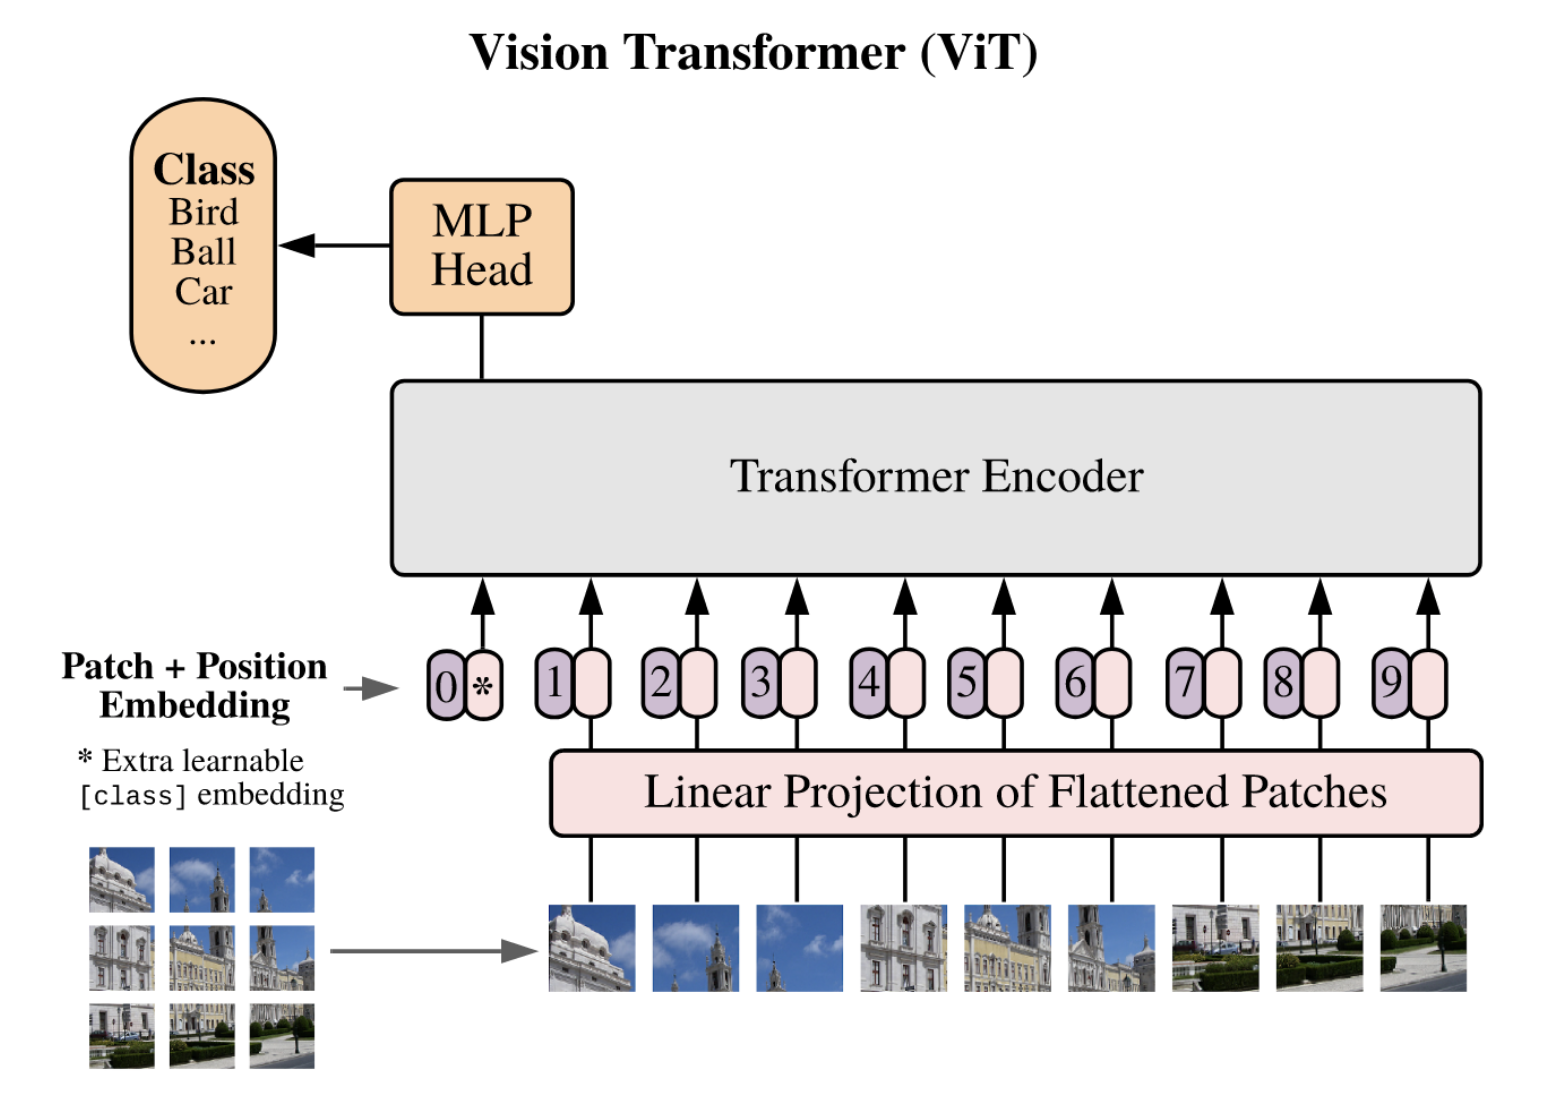)

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [5]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    """
      x.shape : (Batch, Channels, height, width)
    """
    x = self.projection(x)
    
    B, C, H, W = x.size() # Here C = embedding_dim

    # Reshape from B x C x H x W to B x N x C where N is H*W (the number of 'tokens').
    x = x.view(B, C, -1) # Flatten the H and W dimensions.
      
    # Shape is now B x C x N, we simply need to permute to get B x N x C 
    x = x.permute(0, 2, 1)

    # x.size() -> B, N, C
    return x

In [6]:
PatchEmbed(in_chan=2)(torch.randn(32, 2, 28, 28)).size()

torch.Size([32, 16, 128])

# Transformer encoder

![image.png](attachment:./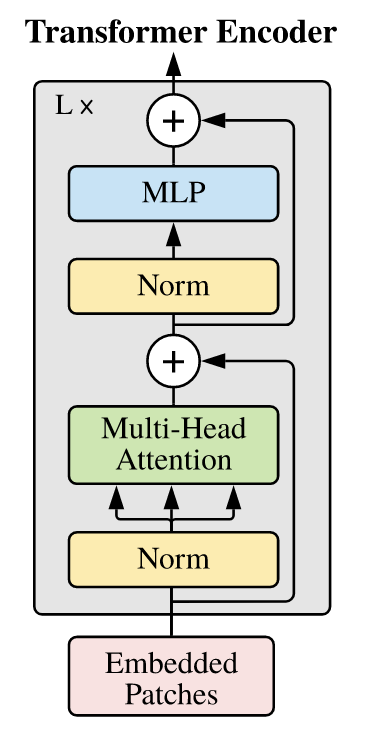)

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [7]:

class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.seq = nn.Sequential(nn.Linear(in_features, hid_features), nn.GELU(), nn.Linear(hid_features, in_features)) 

  def forward(self, x):
    return self.seq(x)


MLP(128, 512)(torch.randn(32, 16, 128)).size()

torch.Size([32, 16, 128])

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart? What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!

**Answer in the reports 😉**

## Q3: Self-attention

In [8]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim, final_linear=True):
    super().__init__()
    self.scale = embed_dim**0.5
    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    if final_linear:
      self.final_linear = nn.Linear(embed_dim, embed_dim)
    else:
      self.final_linear = lambda x: x

  def forward(self, x):
    """
    B : batch size
    N : nombre d'embedding = nombre de patch d'image 
    C : taille d'un embedding 
    """
    B, N, C = x.shape

    # Compute the Q, K, V
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)

    # Compute the final version using the attention V, and the final projection
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v
    return self.final_linear(x)

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

**Answer in the reports 😉**

In [9]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)
      
    print(q.size())

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.
    
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO

    return x

  def transpose_qkv(self, X):
      """Transposition for parallel computation of multiple attention heads."""
      # Shape of input X: (batch_size, no. of queries or key-value pairs, num_hiddens). 
      # Shape of output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens / num_heads)
      X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
      # Shape of output X: (batch_size, num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      X = X.permute(0, 2, 1, 3)
      # Shape of output: (batch_size * num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      return X.reshape(-1, X.shape[2], X.shape[3])
  
  
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])


torch.Size([32, 16, 6])

In [10]:
class MultiHeadsSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        # Validate that the embedding dimension is divisible by the number of heads
        if embed_dim % num_heads != 0:
            raise ValueError("Embedding dimension must be divisible by the number of heads.")

        self.num_heads = num_heads
        head_dim = embed_dim // num_heads  # Determine the dimension size of each head
        self.scale = head_dim ** -0.5  # Scale factor for the dot product

        # These are the linear layers used for the multi-head attention
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)

        # This is the final linear layer used after the self-attention
        self.projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # Batch size, number of tokens, and embedding dimension

        # First, we pass through the linear layers
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        # Reshape Q, K, V for the attention computation
        q = q.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        k = k.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        v = v.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)

        # Scaled dot-product attention calculation
        ###################### On divise ou multipli par la scale attention ?
        attention_scores = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale  # Shape: (B, num_heads, N, N)
        attention = F.softmax(attention_scores, dim=-1)
        out = torch.matmul(attention, v)  # Shape: (B, num_heads, N, head_dim)

        # Concatenating the multi-head attention results
        out = out.permute(0, 2, 1, 3).contiguous().view(B, N, C)  # Shape: (B, N, C)

        # Final linear layer
        out = self.projection(out)  # Shape: (B, N, C)

        return out

    
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).size()

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

**Equations**:

**Answer in the reports 😉**

In [11]:
# normalisation : use layer norm from pytorch, similar to batch normalisation but the mean & std is computed across the channel feature
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)

  def forward(self, x):
    out = self.norm(x)
    out = self.attention(out)
    x = out + x
    out = self.norm(x)
    out = self.mlp(out)
    return out + x

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

In [12]:

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
        super().__init__()

        # Multi-head self-attention mechanism
        self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward neural network (MLP)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, mlp_ratio * embed_dim),  # Linear layer
            nn.GELU(),  # Activation function
            nn.Linear(mlp_ratio * embed_dim, embed_dim),  # Linear layer
        )

    def forward(self, x):
        # Apply multi-head attention followed by layer normalization
        attention_output = self.attention(x)
        x = self.norm1(x + attention_output)  # Residual connection

        # Apply feed-forward neural network followed by layer normalization
        feed_forward_output = self.feed_forward(x)
        x = self.norm2(x + feed_forward_output)  # Residual connection

        return x

    
Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

![](https://www.researchgate.net/publication/348947034/figure/fig2/AS:986572736446471@1612228678819/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the.png)

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

1. Explain what is a Class token and why we use it? 
2. Explain what is the positional embedding (PE) and why it is important?

**Answer in the reports 😉**

### Sinusoidal PE

In [13]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10, num_heads=4, mlp_ratio=4):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.ones(1, embed_dim),requires_grad=False)
    self.pos_embed = nn.Parameter(self.get_positional_embeddings(num_patches+1, embed_dim), requires_grad=False)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(Block(embed_dim, num_heads=num_heads, mlp_ratio=num_heads))
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Sequential(
            nn.Linear(embed_dim, nb_classes),
            nn.Softmax(dim=-1)
        )

  @staticmethod
  def get_positional_embeddings(sequence_length, d):
    """
    given the number of tokens and the dimensionality of each of them, 
    outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.
    """
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result
  
  def forward(self, x):
    batch_size = x.size(0)
    x = self.patch_embed(x) ## image to patches => B, N, C

    ## concatenating class token of shape (1, embedding dim) for every example
    x = torch.cat((self.class_token.repeat(batch_size, 1, 1), x), dim=1)
    
    ## adding positional embedding
    x += self.pos_embed.repeat(batch_size, 1, 1)

    ## forward in the transformer
    x = self.blocks(x)[:, 0, :] # We take only the CLS token
    
    ## Normalize the output
    x = self.norm(x)

    output = self.head(x) ## classification output

    return output
  


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [14]:
@torch.no_grad()
def eval_model(model, loader, num_classes):
  model.eval()
  acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  loss = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)
    loss += F.cross_entropy(yhat, y)
    acc(yhat.argmax(dim=1), y)

  model.train()
  return loss.item() / len(loader), acc.compute().item()

And run! Feel free to try other hyperparameters.

In [15]:
import torchmetrics
from tqdm import tqdm
def main(epochs = 10, embed_dim = 32, patch_size = 7, nb_blocks = 2, num_classes=10, num_heads=4, mlp_ratio=4, model=None, tqdm_batch=False, lr=0.001):
  if not model:
    model = ViT(embed_dim, nb_blocks, patch_size, num_heads=num_heads, mlp_ratio=mlp_ratio).cuda()
  if tqdm_batch:
    train_loader_main = tqdm(train_loader)
  else:
    train_loader_main = train_loader
  opt = torch.optim.Adam(model.parameters(), lr=lr)
  acc_train = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  acc_train_list = []
  acc_test_list = []
  loss_train_list = []
  loss_test_list = []

  for epoch in (pbar := tqdm(range(epochs))):
    train_loss = 0.
    for x, y in train_loader_main:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()
      acc_train(yhat.argmax(dim=1), y)
      train_loss += loss.item()
    loss_train_list.append(train_loss / len(train_loader))
    acc_train_list.append(acc_train.compute().item())
    acc_train.reset()
    
    # Test eval
    loss_test, acc_test = eval_model(model, test_loader, num_classes)
    acc_test_list.append(acc_test)
    loss_test_list.append(loss_test)
    pbar.set_description(f"acc_train {acc_train_list[-1]:.3f} | acc_test {acc_test:.3f}")
  return acc_train_list, acc_test_list, loss_train_list, loss_test_list
  #   print(f"--- Epoch {epoch} ---")
  #   print(f"Train loss: {train_loss / len(train_loader)}")
  # print(f"Test accuracy: {acc}")
# main()

# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [16]:
def plot_plot_optimizers(plot_optimizers, save_name=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()

    for opt, values in plot_optimizers.items():
        ax[0].plot(values[0], label=f"{opt}")
        ax[1].plot(values[1], label=f"{opt}")
        ax[2].plot(values[2], label=f"{opt}")
        ax[3].plot(values[3], label=f"{opt}")

    ax[0].set_title("Train accuracy / epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_ylim([0, 1])

    ax[1].set_title("Test accuracy / epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_ylim([0, 1])

    ax[2].set_title("Train loss / epoch")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Loss")

    ax[3].set_title("Test loss / epoch")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("Loss")

    plt.legend()
    plt.tight_layout()
    if save_name:
        plt.savefig(f"./clear_run/{save_name}.pdf", dpi=100, bbox_inches="tight")
    plt.show()

In [17]:
plot_optimizers_embed_dim = {}
for embed_dim in [16,32,64,128]:
    stats = main(epochs=25, embed_dim=embed_dim)
    plot_optimizers_embed_dim[embed_dim] = stats


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.602 | acc_test 0.862:   0%|                                                                       | 0/25 [00:07<?, ?it/s]


acc_train 0.602 | acc_test 0.862:   4%|██▌                                                            | 1/25 [00:07<02:57,  7.39s/it]


acc_train 0.882 | acc_test 0.904:   4%|██▌                                                            | 1/25 [00:14<02:57,  7.39s/it]


acc_train 0.882 | acc_test 0.904:   8%|█████                                                          | 2/25 [00:14<02:43,  7.13s/it]


acc_train 0.907 | acc_test 0.921:   8%|█████                                                          | 2/25 [00:21<02:43,  7.13s/it]


acc_train 0.907 | acc_test 0.921:  12%|███████▌                                                       | 3/25 [00:21<02:33,  6.99s/it]


acc_train 0.921 | acc_test 0.929:  12%|███████▌                                                       | 3/25 [00:27<02:33,  6.99s/it]


acc_train 0.921 | acc_test 0.929:  16%|██████████                                                     | 4/25 [00:27<02:23,  6.84s/it]


acc_train 0.930 | acc_test 0.941:  16%|██████████                                                     | 4/25 [00:34<02:23,  6.84s/it]


acc_train 0.930 | acc_test 0.941:  20%|████████████▌                                                  | 5/25 [00:34<02:15,  6.76s/it]


acc_train 0.936 | acc_test 0.934:  20%|████████████▌                                                  | 5/25 [00:41<02:15,  6.76s/it]


acc_train 0.936 | acc_test 0.934:  24%|███████████████                                                | 6/25 [00:41<02:07,  6.73s/it]


acc_train 0.940 | acc_test 0.939:  24%|███████████████                                                | 6/25 [00:47<02:07,  6.73s/it]


acc_train 0.940 | acc_test 0.939:  28%|█████████████████▋                                             | 7/25 [00:47<02:00,  6.69s/it]


acc_train 0.943 | acc_test 0.944:  28%|█████████████████▋                                             | 7/25 [00:54<02:00,  6.69s/it]


acc_train 0.943 | acc_test 0.944:  32%|████████████████████▏                                          | 8/25 [00:54<01:54,  6.71s/it]


acc_train 0.946 | acc_test 0.945:  32%|████████████████████▏                                          | 8/25 [01:01<01:54,  6.71s/it]


acc_train 0.946 | acc_test 0.945:  36%|██████████████████████▋                                        | 9/25 [01:01<01:47,  6.70s/it]


acc_train 0.946 | acc_test 0.951:  36%|██████████████████████▋                                        | 9/25 [01:08<01:47,  6.70s/it]


acc_train 0.946 | acc_test 0.951:  40%|████████████████████████▊                                     | 10/25 [01:08<01:41,  6.78s/it]


acc_train 0.949 | acc_test 0.951:  40%|████████████████████████▊                                     | 10/25 [01:14<01:41,  6.78s/it]


acc_train 0.949 | acc_test 0.951:  44%|███████████████████████████▎                                  | 11/25 [01:14<01:34,  6.78s/it]


acc_train 0.952 | acc_test 0.953:  44%|███████████████████████████▎                                  | 11/25 [01:21<01:34,  6.78s/it]


acc_train 0.952 | acc_test 0.953:  48%|█████████████████████████████▊                                | 12/25 [01:21<01:28,  6.79s/it]


acc_train 0.952 | acc_test 0.950:  48%|█████████████████████████████▊                                | 12/25 [01:28<01:28,  6.79s/it]


acc_train 0.952 | acc_test 0.950:  52%|████████████████████████████████▏                             | 13/25 [01:28<01:21,  6.79s/it]


acc_train 0.954 | acc_test 0.952:  52%|████████████████████████████████▏                             | 13/25 [01:35<01:21,  6.79s/it]


acc_train 0.954 | acc_test 0.952:  56%|██████████████████████████████████▋                           | 14/25 [01:35<01:14,  6.79s/it]


acc_train 0.956 | acc_test 0.956:  56%|██████████████████████████████████▋                           | 14/25 [01:42<01:14,  6.79s/it]


acc_train 0.956 | acc_test 0.956:  60%|█████████████████████████████████████▏                        | 15/25 [01:42<01:08,  6.80s/it]


acc_train 0.957 | acc_test 0.959:  60%|█████████████████████████████████████▏                        | 15/25 [01:48<01:08,  6.80s/it]


acc_train 0.957 | acc_test 0.959:  64%|███████████████████████████████████████▋                      | 16/25 [01:48<01:01,  6.80s/it]


acc_train 0.959 | acc_test 0.954:  64%|███████████████████████████████████████▋                      | 16/25 [01:56<01:01,  6.80s/it]


acc_train 0.959 | acc_test 0.954:  68%|██████████████████████████████████████████▏                   | 17/25 [01:56<00:55,  6.95s/it]


acc_train 0.959 | acc_test 0.959:  68%|██████████████████████████████████████████▏                   | 17/25 [02:02<00:55,  6.95s/it]


acc_train 0.959 | acc_test 0.959:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:48,  6.91s/it]


acc_train 0.960 | acc_test 0.960:  72%|████████████████████████████████████████████▋                 | 18/25 [02:09<00:48,  6.91s/it]


acc_train 0.960 | acc_test 0.960:  76%|███████████████████████████████████████████████               | 19/25 [02:09<00:41,  6.88s/it]


acc_train 0.961 | acc_test 0.960:  76%|███████████████████████████████████████████████               | 19/25 [02:16<00:41,  6.88s/it]


acc_train 0.961 | acc_test 0.960:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:16<00:34,  6.86s/it]


acc_train 0.963 | acc_test 0.962:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:23<00:34,  6.86s/it]


acc_train 0.963 | acc_test 0.962:  84%|████████████████████████████████████████████████████          | 21/25 [02:23<00:27,  6.85s/it]


acc_train 0.963 | acc_test 0.961:  84%|████████████████████████████████████████████████████          | 21/25 [02:30<00:27,  6.85s/it]


acc_train 0.963 | acc_test 0.961:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:30<00:20,  6.84s/it]


acc_train 0.964 | acc_test 0.956:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:37<00:20,  6.84s/it]


acc_train 0.964 | acc_test 0.956:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:37<00:13,  6.83s/it]


acc_train 0.965 | acc_test 0.962:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:44<00:13,  6.83s/it]


acc_train 0.965 | acc_test 0.962:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:44<00:06,  6.87s/it]


acc_train 0.965 | acc_test 0.964:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:50<00:06,  6.87s/it]


acc_train 0.965 | acc_test 0.964: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:50<00:00,  6.85s/it]


acc_train 0.965 | acc_test 0.964: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:50<00:00,  6.83s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.704 | acc_test 0.910:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.704 | acc_test 0.910:   4%|██▌                                                            | 1/25 [00:06<02:44,  6.84s/it]


acc_train 0.920 | acc_test 0.935:   4%|██▌                                                            | 1/25 [00:13<02:44,  6.84s/it]


acc_train 0.920 | acc_test 0.935:   8%|█████                                                          | 2/25 [00:13<02:36,  6.82s/it]


acc_train 0.935 | acc_test 0.936:   8%|█████                                                          | 2/25 [00:20<02:36,  6.82s/it]


acc_train 0.935 | acc_test 0.936:  12%|███████▌                                                       | 3/25 [00:20<02:30,  6.82s/it]


acc_train 0.944 | acc_test 0.947:  12%|███████▌                                                       | 3/25 [00:27<02:30,  6.82s/it]


acc_train 0.944 | acc_test 0.947:  16%|██████████                                                     | 4/25 [00:27<02:23,  6.83s/it]


acc_train 0.950 | acc_test 0.951:  16%|██████████                                                     | 4/25 [00:34<02:23,  6.83s/it]


acc_train 0.950 | acc_test 0.951:  20%|████████████▌                                                  | 5/25 [00:34<02:16,  6.83s/it]


acc_train 0.955 | acc_test 0.944:  20%|████████████▌                                                  | 5/25 [00:41<02:16,  6.83s/it]


acc_train 0.955 | acc_test 0.944:  24%|███████████████                                                | 6/25 [00:41<02:10,  6.88s/it]


acc_train 0.957 | acc_test 0.960:  24%|███████████████                                                | 6/25 [00:47<02:10,  6.88s/it]


acc_train 0.957 | acc_test 0.960:  28%|█████████████████▋                                             | 7/25 [00:47<02:02,  6.78s/it]


acc_train 0.960 | acc_test 0.956:  28%|█████████████████▋                                             | 7/25 [00:54<02:02,  6.78s/it]


acc_train 0.960 | acc_test 0.956:  32%|████████████████████▏                                          | 8/25 [00:54<01:54,  6.76s/it]


acc_train 0.960 | acc_test 0.961:  32%|████████████████████▏                                          | 8/25 [01:00<01:54,  6.76s/it]


acc_train 0.960 | acc_test 0.961:  36%|██████████████████████▋                                        | 9/25 [01:00<01:47,  6.70s/it]


acc_train 0.962 | acc_test 0.960:  36%|██████████████████████▋                                        | 9/25 [01:07<01:47,  6.70s/it]


acc_train 0.962 | acc_test 0.960:  40%|████████████████████████▊                                     | 10/25 [01:07<01:39,  6.66s/it]


acc_train 0.967 | acc_test 0.962:  40%|████████████████████████▊                                     | 10/25 [01:14<01:39,  6.66s/it]


acc_train 0.967 | acc_test 0.962:  44%|███████████████████████████▎                                  | 11/25 [01:14<01:33,  6.68s/it]


acc_train 0.967 | acc_test 0.959:  44%|███████████████████████████▎                                  | 11/25 [01:21<01:33,  6.68s/it]


acc_train 0.967 | acc_test 0.959:  48%|█████████████████████████████▊                                | 12/25 [01:21<01:27,  6.74s/it]


acc_train 0.967 | acc_test 0.964:  48%|█████████████████████████████▊                                | 12/25 [01:27<01:27,  6.74s/it]


acc_train 0.967 | acc_test 0.964:  52%|████████████████████████████████▏                             | 13/25 [01:27<01:21,  6.76s/it]


acc_train 0.968 | acc_test 0.965:  52%|████████████████████████████████▏                             | 13/25 [01:34<01:21,  6.76s/it]


acc_train 0.968 | acc_test 0.965:  56%|██████████████████████████████████▋                           | 14/25 [01:34<01:14,  6.77s/it]


acc_train 0.971 | acc_test 0.966:  56%|██████████████████████████████████▋                           | 14/25 [01:41<01:14,  6.77s/it]


acc_train 0.971 | acc_test 0.966:  60%|█████████████████████████████████████▏                        | 15/25 [01:41<01:07,  6.78s/it]


acc_train 0.970 | acc_test 0.966:  60%|█████████████████████████████████████▏                        | 15/25 [01:48<01:07,  6.78s/it]


acc_train 0.970 | acc_test 0.966:  64%|███████████████████████████████████████▋                      | 16/25 [01:48<01:00,  6.77s/it]


acc_train 0.972 | acc_test 0.968:  64%|███████████████████████████████████████▋                      | 16/25 [01:54<01:00,  6.77s/it]


acc_train 0.972 | acc_test 0.968:  68%|██████████████████████████████████████████▏                   | 17/25 [01:54<00:53,  6.71s/it]


acc_train 0.972 | acc_test 0.970:  68%|██████████████████████████████████████████▏                   | 17/25 [02:01<00:53,  6.71s/it]


acc_train 0.972 | acc_test 0.970:  72%|████████████████████████████████████████████▋                 | 18/25 [02:01<00:46,  6.69s/it]


acc_train 0.974 | acc_test 0.968:  72%|████████████████████████████████████████████▋                 | 18/25 [02:08<00:46,  6.69s/it]


acc_train 0.974 | acc_test 0.968:  76%|███████████████████████████████████████████████               | 19/25 [02:08<00:39,  6.65s/it]


acc_train 0.976 | acc_test 0.970:  76%|███████████████████████████████████████████████               | 19/25 [02:14<00:39,  6.65s/it]


acc_train 0.976 | acc_test 0.970:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:14<00:33,  6.68s/it]


acc_train 0.974 | acc_test 0.969:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:21<00:33,  6.68s/it]


acc_train 0.974 | acc_test 0.969:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:26,  6.65s/it]


acc_train 0.976 | acc_test 0.970:  84%|████████████████████████████████████████████████████          | 21/25 [02:27<00:26,  6.65s/it]


acc_train 0.976 | acc_test 0.970:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:27<00:19,  6.63s/it]


acc_train 0.977 | acc_test 0.970:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:34<00:19,  6.63s/it]


acc_train 0.977 | acc_test 0.970:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:13,  6.63s/it]


acc_train 0.977 | acc_test 0.974:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:41<00:13,  6.63s/it]


acc_train 0.977 | acc_test 0.974:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:41<00:06,  6.66s/it]


acc_train 0.978 | acc_test 0.967:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:48<00:06,  6.66s/it]


acc_train 0.978 | acc_test 0.967: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:48<00:00,  6.70s/it]


acc_train 0.978 | acc_test 0.967: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:48<00:00,  6.73s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.755 | acc_test 0.915:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.755 | acc_test 0.915:   4%|██▌                                                            | 1/25 [00:06<02:42,  6.76s/it]


acc_train 0.923 | acc_test 0.938:   4%|██▌                                                            | 1/25 [00:13<02:42,  6.76s/it]


acc_train 0.923 | acc_test 0.938:   8%|█████                                                          | 2/25 [00:13<02:33,  6.68s/it]


acc_train 0.938 | acc_test 0.944:   8%|█████                                                          | 2/25 [00:19<02:33,  6.68s/it]


acc_train 0.938 | acc_test 0.944:  12%|███████▌                                                       | 3/25 [00:19<02:26,  6.64s/it]


acc_train 0.946 | acc_test 0.948:  12%|███████▌                                                       | 3/25 [00:26<02:26,  6.64s/it]


acc_train 0.946 | acc_test 0.948:  16%|██████████                                                     | 4/25 [00:26<02:21,  6.74s/it]


acc_train 0.951 | acc_test 0.953:  16%|██████████                                                     | 4/25 [00:33<02:21,  6.74s/it]


acc_train 0.951 | acc_test 0.953:  20%|████████████▌                                                  | 5/25 [00:33<02:16,  6.81s/it]


acc_train 0.955 | acc_test 0.957:  20%|████████████▌                                                  | 5/25 [00:40<02:16,  6.81s/it]


acc_train 0.955 | acc_test 0.957:  24%|███████████████                                                | 6/25 [00:40<02:09,  6.81s/it]


acc_train 0.960 | acc_test 0.958:  24%|███████████████                                                | 6/25 [00:47<02:09,  6.81s/it]


acc_train 0.960 | acc_test 0.958:  28%|█████████████████▋                                             | 7/25 [00:47<02:04,  6.93s/it]


acc_train 0.961 | acc_test 0.964:  28%|█████████████████▋                                             | 7/25 [00:54<02:04,  6.93s/it]


acc_train 0.961 | acc_test 0.964:  32%|████████████████████▏                                          | 8/25 [00:54<01:57,  6.90s/it]


acc_train 0.965 | acc_test 0.961:  32%|████████████████████▏                                          | 8/25 [01:01<01:57,  6.90s/it]


acc_train 0.965 | acc_test 0.961:  36%|██████████████████████▋                                        | 9/25 [01:01<01:50,  6.90s/it]


acc_train 0.966 | acc_test 0.970:  36%|██████████████████████▋                                        | 9/25 [01:08<01:50,  6.90s/it]


acc_train 0.966 | acc_test 0.970:  40%|████████████████████████▊                                     | 10/25 [01:08<01:41,  6.79s/it]


acc_train 0.967 | acc_test 0.965:  40%|████████████████████████▊                                     | 10/25 [01:14<01:41,  6.79s/it]


acc_train 0.967 | acc_test 0.965:  44%|███████████████████████████▎                                  | 11/25 [01:14<01:34,  6.72s/it]


acc_train 0.968 | acc_test 0.963:  44%|███████████████████████████▎                                  | 11/25 [01:21<01:34,  6.72s/it]


acc_train 0.968 | acc_test 0.963:  48%|█████████████████████████████▊                                | 12/25 [01:21<01:26,  6.67s/it]


acc_train 0.969 | acc_test 0.965:  48%|█████████████████████████████▊                                | 12/25 [01:28<01:26,  6.67s/it]


acc_train 0.969 | acc_test 0.965:  52%|████████████████████████████████▏                             | 13/25 [01:28<01:20,  6.72s/it]


acc_train 0.971 | acc_test 0.966:  52%|████████████████████████████████▏                             | 13/25 [01:34<01:20,  6.72s/it]


acc_train 0.971 | acc_test 0.966:  56%|██████████████████████████████████▋                           | 14/25 [01:34<01:13,  6.69s/it]


acc_train 0.972 | acc_test 0.974:  56%|██████████████████████████████████▋                           | 14/25 [01:41<01:13,  6.69s/it]


acc_train 0.972 | acc_test 0.974:  60%|█████████████████████████████████████▏                        | 15/25 [01:41<01:06,  6.69s/it]


acc_train 0.973 | acc_test 0.968:  60%|█████████████████████████████████████▏                        | 15/25 [01:48<01:06,  6.69s/it]


acc_train 0.973 | acc_test 0.968:  64%|███████████████████████████████████████▋                      | 16/25 [01:48<01:00,  6.68s/it]


acc_train 0.973 | acc_test 0.968:  64%|███████████████████████████████████████▋                      | 16/25 [01:54<01:00,  6.68s/it]


acc_train 0.973 | acc_test 0.968:  68%|██████████████████████████████████████████▏                   | 17/25 [01:54<00:53,  6.67s/it]


acc_train 0.976 | acc_test 0.970:  68%|██████████████████████████████████████████▏                   | 17/25 [02:01<00:53,  6.67s/it]


acc_train 0.976 | acc_test 0.970:  72%|████████████████████████████████████████████▋                 | 18/25 [02:01<00:46,  6.67s/it]


acc_train 0.974 | acc_test 0.971:  72%|████████████████████████████████████████████▋                 | 18/25 [02:08<00:46,  6.67s/it]


acc_train 0.974 | acc_test 0.971:  76%|███████████████████████████████████████████████               | 19/25 [02:08<00:40,  6.81s/it]


acc_train 0.974 | acc_test 0.973:  76%|███████████████████████████████████████████████               | 19/25 [02:15<00:40,  6.81s/it]


acc_train 0.974 | acc_test 0.973:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:15<00:33,  6.78s/it]


acc_train 0.975 | acc_test 0.971:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:21<00:33,  6.78s/it]


acc_train 0.975 | acc_test 0.971:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:27,  6.77s/it]


acc_train 0.976 | acc_test 0.973:  84%|████████████████████████████████████████████████████          | 21/25 [02:28<00:27,  6.77s/it]


acc_train 0.976 | acc_test 0.973:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:28<00:20,  6.78s/it]


acc_train 0.976 | acc_test 0.969:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:35<00:20,  6.78s/it]


acc_train 0.976 | acc_test 0.969:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:35<00:13,  6.75s/it]


acc_train 0.976 | acc_test 0.976:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:42<00:13,  6.75s/it]


acc_train 0.976 | acc_test 0.976:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:42<00:06,  6.72s/it]


acc_train 0.976 | acc_test 0.968:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:48<00:06,  6.72s/it]


acc_train 0.976 | acc_test 0.968: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:48<00:00,  6.75s/it]


acc_train 0.976 | acc_test 0.968: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:48<00:00,  6.75s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.772 | acc_test 0.916:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.772 | acc_test 0.916:   4%|██▌                                                            | 1/25 [00:06<02:41,  6.75s/it]


acc_train 0.920 | acc_test 0.932:   4%|██▌                                                            | 1/25 [00:13<02:41,  6.75s/it]


acc_train 0.920 | acc_test 0.932:   8%|█████                                                          | 2/25 [00:13<02:38,  6.88s/it]


acc_train 0.935 | acc_test 0.942:   8%|█████                                                          | 2/25 [00:20<02:38,  6.88s/it]


acc_train 0.935 | acc_test 0.942:  12%|███████▌                                                       | 3/25 [00:20<02:29,  6.78s/it]


acc_train 0.944 | acc_test 0.942:  12%|███████▌                                                       | 3/25 [00:27<02:29,  6.78s/it]


acc_train 0.944 | acc_test 0.942:  16%|██████████                                                     | 4/25 [00:27<02:21,  6.73s/it]


acc_train 0.947 | acc_test 0.957:  16%|██████████                                                     | 4/25 [00:33<02:21,  6.73s/it]


acc_train 0.947 | acc_test 0.957:  20%|████████████▌                                                  | 5/25 [00:33<02:14,  6.70s/it]


acc_train 0.948 | acc_test 0.942:  20%|████████████▌                                                  | 5/25 [00:40<02:14,  6.70s/it]


acc_train 0.948 | acc_test 0.942:  24%|███████████████                                                | 6/25 [00:40<02:06,  6.68s/it]


acc_train 0.951 | acc_test 0.957:  24%|███████████████                                                | 6/25 [00:47<02:06,  6.68s/it]


acc_train 0.951 | acc_test 0.957:  28%|█████████████████▋                                             | 7/25 [00:47<02:00,  6.69s/it]


acc_train 0.952 | acc_test 0.956:  28%|█████████████████▋                                             | 7/25 [00:53<02:00,  6.69s/it]


acc_train 0.952 | acc_test 0.956:  32%|████████████████████▏                                          | 8/25 [00:53<01:54,  6.72s/it]


acc_train 0.945 | acc_test 0.952:  32%|████████████████████▏                                          | 8/25 [01:00<01:54,  6.72s/it]


acc_train 0.945 | acc_test 0.952:  36%|██████████████████████▋                                        | 9/25 [01:00<01:48,  6.76s/it]


acc_train 0.948 | acc_test 0.953:  36%|██████████████████████▋                                        | 9/25 [01:07<01:48,  6.76s/it]


acc_train 0.948 | acc_test 0.953:  40%|████████████████████████▊                                     | 10/25 [01:07<01:41,  6.76s/it]


acc_train 0.953 | acc_test 0.962:  40%|████████████████████████▊                                     | 10/25 [01:14<01:41,  6.76s/it]


acc_train 0.953 | acc_test 0.962:  44%|███████████████████████████▎                                  | 11/25 [01:14<01:33,  6.71s/it]


acc_train 0.961 | acc_test 0.964:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:33,  6.71s/it]


acc_train 0.961 | acc_test 0.964:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:26,  6.68s/it]


acc_train 0.961 | acc_test 0.957:  48%|█████████████████████████████▊                                | 12/25 [01:27<01:26,  6.68s/it]


acc_train 0.961 | acc_test 0.957:  52%|████████████████████████████████▏                             | 13/25 [01:27<01:20,  6.70s/it]


acc_train 0.959 | acc_test 0.958:  52%|████████████████████████████████▏                             | 13/25 [01:33<01:20,  6.70s/it]


acc_train 0.959 | acc_test 0.958:  56%|██████████████████████████████████▋                           | 14/25 [01:33<01:13,  6.67s/it]


acc_train 0.960 | acc_test 0.950:  56%|██████████████████████████████████▋                           | 14/25 [01:40<01:13,  6.67s/it]


acc_train 0.960 | acc_test 0.950:  60%|█████████████████████████████████████▏                        | 15/25 [01:40<01:06,  6.65s/it]


acc_train 0.955 | acc_test 0.962:  60%|█████████████████████████████████████▏                        | 15/25 [01:47<01:06,  6.65s/it]


acc_train 0.955 | acc_test 0.962:  64%|███████████████████████████████████████▋                      | 16/25 [01:47<01:00,  6.68s/it]


acc_train 0.953 | acc_test 0.957:  64%|███████████████████████████████████████▋                      | 16/25 [01:54<01:00,  6.68s/it]


acc_train 0.953 | acc_test 0.957:  68%|██████████████████████████████████████████▏                   | 17/25 [01:54<00:53,  6.70s/it]


acc_train 0.953 | acc_test 0.959:  68%|██████████████████████████████████████████▏                   | 17/25 [02:00<00:53,  6.70s/it]


acc_train 0.953 | acc_test 0.959:  72%|████████████████████████████████████████████▋                 | 18/25 [02:00<00:46,  6.67s/it]


acc_train 0.953 | acc_test 0.963:  72%|████████████████████████████████████████████▋                 | 18/25 [02:07<00:46,  6.67s/it]


acc_train 0.953 | acc_test 0.963:  76%|███████████████████████████████████████████████               | 19/25 [02:07<00:40,  6.67s/it]


acc_train 0.965 | acc_test 0.964:  76%|███████████████████████████████████████████████               | 19/25 [02:14<00:40,  6.67s/it]


acc_train 0.965 | acc_test 0.964:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:14<00:33,  6.69s/it]


acc_train 0.966 | acc_test 0.964:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:20<00:33,  6.69s/it]


acc_train 0.966 | acc_test 0.964:  84%|████████████████████████████████████████████████████          | 21/25 [02:20<00:26,  6.69s/it]


acc_train 0.966 | acc_test 0.960:  84%|████████████████████████████████████████████████████          | 21/25 [02:27<00:26,  6.69s/it]


acc_train 0.966 | acc_test 0.960:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:27<00:19,  6.66s/it]


acc_train 0.958 | acc_test 0.959:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:34<00:19,  6.66s/it]


acc_train 0.958 | acc_test 0.959:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:13,  6.67s/it]


acc_train 0.961 | acc_test 0.957:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:40<00:13,  6.67s/it]


acc_train 0.961 | acc_test 0.957:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:40<00:06,  6.66s/it]


acc_train 0.957 | acc_test 0.957:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:47<00:06,  6.66s/it]


acc_train 0.957 | acc_test 0.957: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.64s/it]


acc_train 0.957 | acc_test 0.957: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:47<00:00,  6.69s/it]

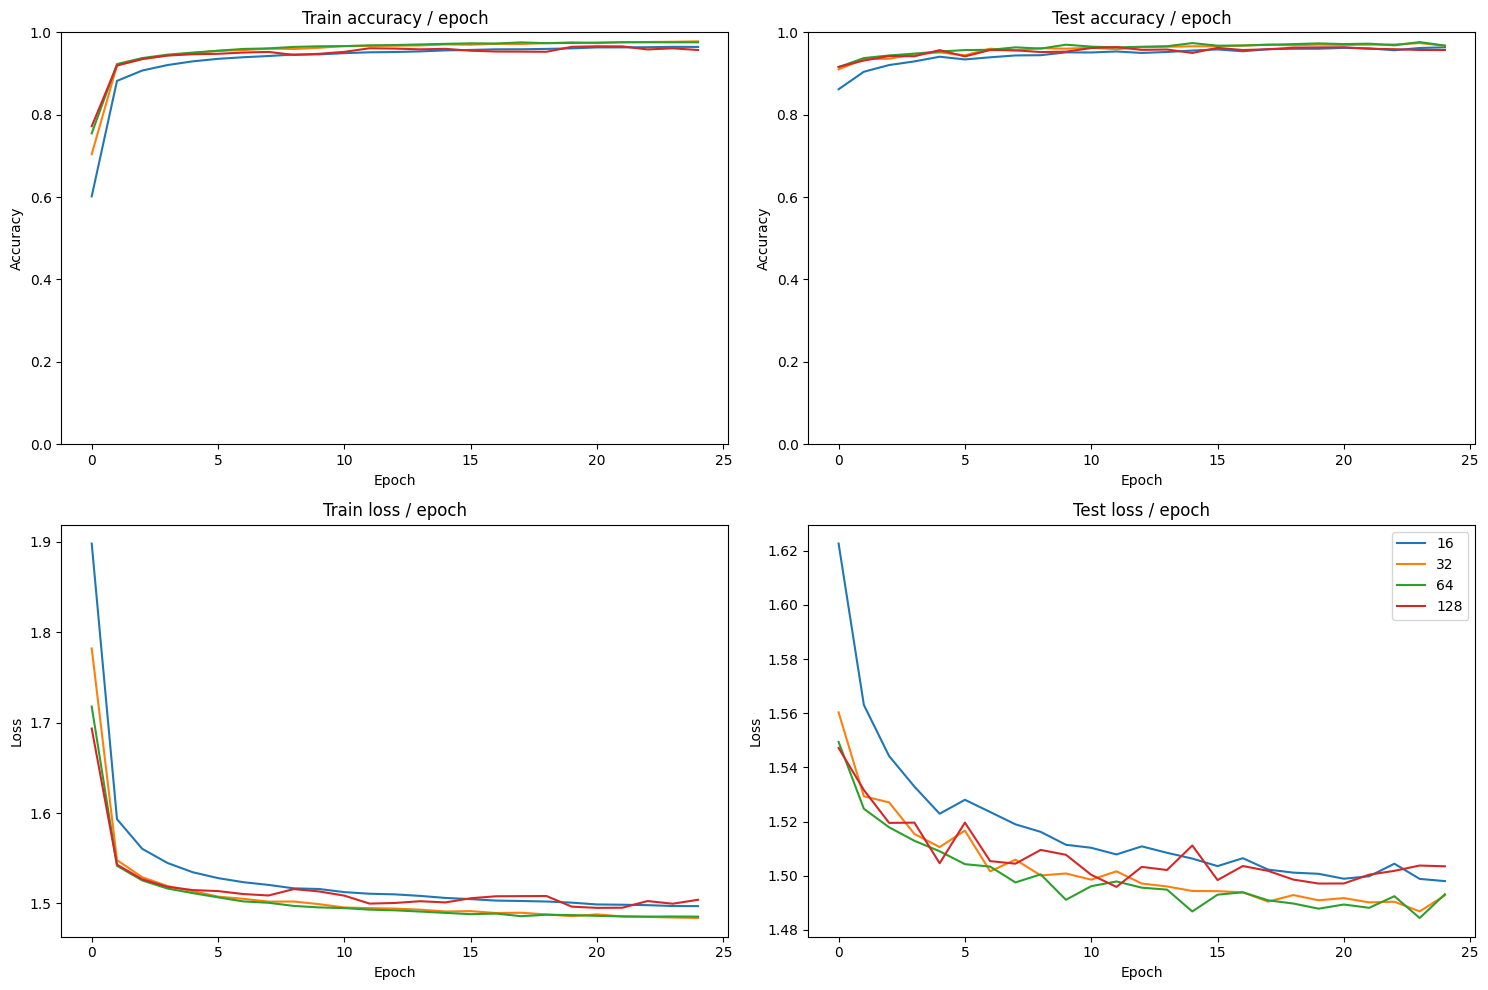

In [18]:
plot_plot_optimizers(plot_optimizers_embed_dim, 'embed_dim_influence_25')

In [19]:
plot_optimizers_patch_size = {}
for patch_size in [2,4,7,14, 28]:
    stats = main(epochs=25, patch_size=patch_size)
    plot_optimizers_patch_size[patch_size] = stats


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.545 | acc_test 0.849:   0%|                                                                       | 0/25 [00:09<?, ?it/s]


acc_train 0.545 | acc_test 0.849:   4%|██▌                                                            | 1/25 [00:09<03:45,  9.38s/it]


acc_train 0.870 | acc_test 0.899:   4%|██▌                                                            | 1/25 [00:18<03:45,  9.38s/it]


acc_train 0.870 | acc_test 0.899:   8%|█████                                                          | 2/25 [00:18<03:36,  9.42s/it]


acc_train 0.903 | acc_test 0.917:   8%|█████                                                          | 2/25 [00:28<03:36,  9.42s/it]


acc_train 0.903 | acc_test 0.917:  12%|███████▌                                                       | 3/25 [00:28<03:26,  9.40s/it]


acc_train 0.915 | acc_test 0.935:  12%|███████▌                                                       | 3/25 [00:37<03:26,  9.40s/it]


acc_train 0.915 | acc_test 0.935:  16%|██████████                                                     | 4/25 [00:37<03:18,  9.45s/it]


acc_train 0.928 | acc_test 0.936:  16%|██████████                                                     | 4/25 [00:47<03:18,  9.45s/it]


acc_train 0.928 | acc_test 0.936:  20%|████████████▌                                                  | 5/25 [00:47<03:12,  9.60s/it]


acc_train 0.935 | acc_test 0.933:  20%|████████████▌                                                  | 5/25 [00:57<03:12,  9.60s/it]


acc_train 0.935 | acc_test 0.933:  24%|███████████████                                                | 6/25 [00:57<03:01,  9.54s/it]


acc_train 0.941 | acc_test 0.942:  24%|███████████████                                                | 6/25 [01:06<03:01,  9.54s/it]


acc_train 0.941 | acc_test 0.942:  28%|█████████████████▋                                             | 7/25 [01:06<02:51,  9.50s/it]


acc_train 0.944 | acc_test 0.948:  28%|█████████████████▋                                             | 7/25 [01:16<02:51,  9.50s/it]


acc_train 0.944 | acc_test 0.948:  32%|████████████████████▏                                          | 8/25 [01:16<02:42,  9.56s/it]


acc_train 0.948 | acc_test 0.951:  32%|████████████████████▏                                          | 8/25 [01:25<02:42,  9.56s/it]


acc_train 0.948 | acc_test 0.951:  36%|██████████████████████▋                                        | 9/25 [01:25<02:32,  9.51s/it]


acc_train 0.952 | acc_test 0.953:  36%|██████████████████████▋                                        | 9/25 [01:34<02:32,  9.51s/it]


acc_train 0.952 | acc_test 0.953:  40%|████████████████████████▊                                     | 10/25 [01:34<02:22,  9.47s/it]


acc_train 0.953 | acc_test 0.941:  40%|████████████████████████▊                                     | 10/25 [01:44<02:22,  9.47s/it]


acc_train 0.953 | acc_test 0.941:  44%|███████████████████████████▎                                  | 11/25 [01:44<02:12,  9.45s/it]


acc_train 0.957 | acc_test 0.953:  44%|███████████████████████████▎                                  | 11/25 [01:53<02:12,  9.45s/it]


acc_train 0.957 | acc_test 0.953:  48%|█████████████████████████████▊                                | 12/25 [01:53<02:02,  9.44s/it]


acc_train 0.959 | acc_test 0.954:  48%|█████████████████████████████▊                                | 12/25 [02:03<02:02,  9.44s/it]


acc_train 0.959 | acc_test 0.954:  52%|████████████████████████████████▏                             | 13/25 [02:03<01:53,  9.43s/it]


acc_train 0.958 | acc_test 0.957:  52%|████████████████████████████████▏                             | 13/25 [02:12<01:53,  9.43s/it]


acc_train 0.958 | acc_test 0.957:  56%|██████████████████████████████████▋                           | 14/25 [02:12<01:43,  9.42s/it]


acc_train 0.963 | acc_test 0.957:  56%|██████████████████████████████████▋                           | 14/25 [02:21<01:43,  9.42s/it]


acc_train 0.963 | acc_test 0.957:  60%|█████████████████████████████████████▏                        | 15/25 [02:21<01:34,  9.41s/it]


acc_train 0.962 | acc_test 0.961:  60%|█████████████████████████████████████▏                        | 15/25 [02:31<01:34,  9.41s/it]


acc_train 0.962 | acc_test 0.961:  64%|███████████████████████████████████████▋                      | 16/25 [02:31<01:24,  9.40s/it]


acc_train 0.964 | acc_test 0.953:  64%|███████████████████████████████████████▋                      | 16/25 [02:40<01:24,  9.40s/it]


acc_train 0.964 | acc_test 0.953:  68%|██████████████████████████████████████████▏                   | 17/25 [02:40<01:15,  9.40s/it]


acc_train 0.967 | acc_test 0.961:  68%|██████████████████████████████████████████▏                   | 17/25 [02:50<01:15,  9.40s/it]


acc_train 0.967 | acc_test 0.961:  72%|████████████████████████████████████████████▋                 | 18/25 [02:50<01:05,  9.40s/it]


acc_train 0.967 | acc_test 0.964:  72%|████████████████████████████████████████████▋                 | 18/25 [02:59<01:05,  9.40s/it]


acc_train 0.967 | acc_test 0.964:  76%|███████████████████████████████████████████████               | 19/25 [02:59<00:56,  9.42s/it]


acc_train 0.967 | acc_test 0.965:  76%|███████████████████████████████████████████████               | 19/25 [03:08<00:56,  9.42s/it]


acc_train 0.967 | acc_test 0.965:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:08<00:47,  9.42s/it]


acc_train 0.969 | acc_test 0.962:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:18<00:47,  9.42s/it]


acc_train 0.969 | acc_test 0.962:  84%|████████████████████████████████████████████████████          | 21/25 [03:18<00:37,  9.43s/it]


acc_train 0.971 | acc_test 0.968:  84%|████████████████████████████████████████████████████          | 21/25 [03:27<00:37,  9.43s/it]


acc_train 0.971 | acc_test 0.968:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:27<00:28,  9.43s/it]


acc_train 0.971 | acc_test 0.963:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:37<00:28,  9.43s/it]


acc_train 0.971 | acc_test 0.963:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:37<00:18,  9.44s/it]


acc_train 0.971 | acc_test 0.967:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:46<00:18,  9.44s/it]


acc_train 0.971 | acc_test 0.967:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:46<00:09,  9.43s/it]


acc_train 0.972 | acc_test 0.969:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:56<00:09,  9.43s/it]


acc_train 0.972 | acc_test 0.969: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:56<00:00,  9.42s/it]


acc_train 0.972 | acc_test 0.969: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:56<00:00,  9.44s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.642 | acc_test 0.862:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.642 | acc_test 0.862:   4%|██▌                                                            | 1/25 [00:06<02:40,  6.69s/it]


acc_train 0.898 | acc_test 0.915:   4%|██▌                                                            | 1/25 [00:13<02:40,  6.69s/it]


acc_train 0.898 | acc_test 0.915:   8%|█████                                                          | 2/25 [00:13<02:31,  6.57s/it]


acc_train 0.920 | acc_test 0.918:   8%|█████                                                          | 2/25 [00:19<02:31,  6.57s/it]


acc_train 0.920 | acc_test 0.918:  12%|███████▌                                                       | 3/25 [00:19<02:23,  6.53s/it]


acc_train 0.933 | acc_test 0.940:  12%|███████▌                                                       | 3/25 [00:26<02:23,  6.53s/it]


acc_train 0.933 | acc_test 0.940:  16%|██████████                                                     | 4/25 [00:26<02:16,  6.50s/it]


acc_train 0.940 | acc_test 0.946:  16%|██████████                                                     | 4/25 [00:32<02:16,  6.50s/it]


acc_train 0.940 | acc_test 0.946:  20%|████████████▌                                                  | 5/25 [00:32<02:10,  6.55s/it]


acc_train 0.946 | acc_test 0.939:  20%|████████████▌                                                  | 5/25 [00:39<02:10,  6.55s/it]


acc_train 0.946 | acc_test 0.939:  24%|███████████████                                                | 6/25 [00:39<02:03,  6.51s/it]


acc_train 0.950 | acc_test 0.956:  24%|███████████████                                                | 6/25 [00:45<02:03,  6.51s/it]


acc_train 0.950 | acc_test 0.956:  28%|█████████████████▋                                             | 7/25 [00:45<01:57,  6.51s/it]


acc_train 0.955 | acc_test 0.953:  28%|█████████████████▋                                             | 7/25 [00:52<01:57,  6.51s/it]


acc_train 0.955 | acc_test 0.953:  32%|████████████████████▏                                          | 8/25 [00:52<01:50,  6.49s/it]


acc_train 0.959 | acc_test 0.956:  32%|████████████████████▏                                          | 8/25 [00:58<01:50,  6.49s/it]


acc_train 0.959 | acc_test 0.956:  36%|██████████████████████▋                                        | 9/25 [00:58<01:44,  6.52s/it]


acc_train 0.958 | acc_test 0.951:  36%|██████████████████████▋                                        | 9/25 [01:05<01:44,  6.52s/it]


acc_train 0.958 | acc_test 0.951:  40%|████████████████████████▊                                     | 10/25 [01:05<01:37,  6.50s/it]


acc_train 0.961 | acc_test 0.963:  40%|████████████████████████▊                                     | 10/25 [01:11<01:37,  6.50s/it]


acc_train 0.961 | acc_test 0.963:  44%|███████████████████████████▎                                  | 11/25 [01:11<01:30,  6.48s/it]


acc_train 0.962 | acc_test 0.959:  44%|███████████████████████████▎                                  | 11/25 [01:18<01:30,  6.48s/it]


acc_train 0.962 | acc_test 0.959:  48%|█████████████████████████████▊                                | 12/25 [01:18<01:24,  6.52s/it]


acc_train 0.965 | acc_test 0.965:  48%|█████████████████████████████▊                                | 12/25 [01:24<01:24,  6.52s/it]


acc_train 0.965 | acc_test 0.965:  52%|████████████████████████████████▏                             | 13/25 [01:24<01:18,  6.50s/it]


acc_train 0.967 | acc_test 0.965:  52%|████████████████████████████████▏                             | 13/25 [01:31<01:18,  6.50s/it]


acc_train 0.967 | acc_test 0.965:  56%|██████████████████████████████████▋                           | 14/25 [01:31<01:12,  6.58s/it]


acc_train 0.968 | acc_test 0.969:  56%|██████████████████████████████████▋                           | 14/25 [01:37<01:12,  6.58s/it]


acc_train 0.968 | acc_test 0.969:  60%|█████████████████████████████████████▏                        | 15/25 [01:37<01:05,  6.55s/it]


acc_train 0.969 | acc_test 0.966:  60%|█████████████████████████████████████▏                        | 15/25 [01:44<01:05,  6.55s/it]


acc_train 0.969 | acc_test 0.966:  64%|███████████████████████████████████████▋                      | 16/25 [01:44<00:59,  6.56s/it]


acc_train 0.971 | acc_test 0.963:  64%|███████████████████████████████████████▋                      | 16/25 [01:51<00:59,  6.56s/it]


acc_train 0.971 | acc_test 0.963:  68%|██████████████████████████████████████████▏                   | 17/25 [01:51<00:52,  6.58s/it]


acc_train 0.971 | acc_test 0.964:  68%|██████████████████████████████████████████▏                   | 17/25 [01:57<00:52,  6.58s/it]


acc_train 0.971 | acc_test 0.964:  72%|████████████████████████████████████████████▋                 | 18/25 [01:57<00:45,  6.54s/it]


acc_train 0.973 | acc_test 0.974:  72%|████████████████████████████████████████████▋                 | 18/25 [02:04<00:45,  6.54s/it]


acc_train 0.973 | acc_test 0.974:  76%|███████████████████████████████████████████████               | 19/25 [02:04<00:39,  6.63s/it]


acc_train 0.972 | acc_test 0.969:  76%|███████████████████████████████████████████████               | 19/25 [02:10<00:39,  6.63s/it]


acc_train 0.972 | acc_test 0.969:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:10<00:32,  6.57s/it]


acc_train 0.974 | acc_test 0.968:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:17<00:32,  6.57s/it]


acc_train 0.974 | acc_test 0.968:  84%|████████████████████████████████████████████████████          | 21/25 [02:17<00:26,  6.58s/it]


acc_train 0.974 | acc_test 0.975:  84%|████████████████████████████████████████████████████          | 21/25 [02:23<00:26,  6.58s/it]


acc_train 0.974 | acc_test 0.975:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:23<00:19,  6.54s/it]


acc_train 0.975 | acc_test 0.973:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:30<00:19,  6.54s/it]


acc_train 0.975 | acc_test 0.973:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:30<00:13,  6.51s/it]


acc_train 0.975 | acc_test 0.974:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:36<00:13,  6.51s/it]


acc_train 0.975 | acc_test 0.974:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:36<00:06,  6.53s/it]


acc_train 0.976 | acc_test 0.974:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:43<00:06,  6.53s/it]


acc_train 0.976 | acc_test 0.974: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.51s/it]


acc_train 0.976 | acc_test 0.974: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.54s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.693 | acc_test 0.911:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.693 | acc_test 0.911:   4%|██▌                                                            | 1/25 [00:06<02:37,  6.57s/it]


acc_train 0.919 | acc_test 0.928:   4%|██▌                                                            | 1/25 [00:13<02:37,  6.57s/it]


acc_train 0.919 | acc_test 0.928:   8%|█████                                                          | 2/25 [00:13<02:29,  6.51s/it]


acc_train 0.935 | acc_test 0.941:   8%|█████                                                          | 2/25 [00:19<02:29,  6.51s/it]


acc_train 0.935 | acc_test 0.941:  12%|███████▌                                                       | 3/25 [00:19<02:22,  6.49s/it]


acc_train 0.943 | acc_test 0.951:  12%|███████▌                                                       | 3/25 [00:25<02:22,  6.49s/it]


acc_train 0.943 | acc_test 0.951:  16%|██████████                                                     | 4/25 [00:25<02:16,  6.48s/it]


acc_train 0.948 | acc_test 0.948:  16%|██████████                                                     | 4/25 [00:32<02:16,  6.48s/it]


acc_train 0.948 | acc_test 0.948:  20%|████████████▌                                                  | 5/25 [00:32<02:09,  6.47s/it]


acc_train 0.952 | acc_test 0.957:  20%|████████████▌                                                  | 5/25 [00:38<02:09,  6.47s/it]


acc_train 0.952 | acc_test 0.957:  24%|███████████████                                                | 6/25 [00:38<02:02,  6.47s/it]


acc_train 0.955 | acc_test 0.953:  24%|███████████████                                                | 6/25 [00:45<02:02,  6.47s/it]


acc_train 0.955 | acc_test 0.953:  28%|█████████████████▋                                             | 7/25 [00:45<01:56,  6.47s/it]


acc_train 0.958 | acc_test 0.954:  28%|█████████████████▋                                             | 7/25 [00:51<01:56,  6.47s/it]


acc_train 0.958 | acc_test 0.954:  32%|████████████████████▏                                          | 8/25 [00:51<01:49,  6.47s/it]


acc_train 0.961 | acc_test 0.956:  32%|████████████████████▏                                          | 8/25 [00:58<01:49,  6.47s/it]


acc_train 0.961 | acc_test 0.956:  36%|██████████████████████▋                                        | 9/25 [00:58<01:44,  6.55s/it]


acc_train 0.963 | acc_test 0.960:  36%|██████████████████████▋                                        | 9/25 [01:05<01:44,  6.55s/it]


acc_train 0.963 | acc_test 0.960:  40%|████████████████████████▊                                     | 10/25 [01:05<01:38,  6.57s/it]


acc_train 0.965 | acc_test 0.964:  40%|████████████████████████▊                                     | 10/25 [01:11<01:38,  6.57s/it]


acc_train 0.965 | acc_test 0.964:  44%|███████████████████████████▎                                  | 11/25 [01:11<01:32,  6.58s/it]


acc_train 0.965 | acc_test 0.965:  44%|███████████████████████████▎                                  | 11/25 [01:18<01:32,  6.58s/it]


acc_train 0.965 | acc_test 0.965:  48%|█████████████████████████████▊                                | 12/25 [01:18<01:25,  6.54s/it]


acc_train 0.967 | acc_test 0.962:  48%|█████████████████████████████▊                                | 12/25 [01:24<01:25,  6.54s/it]


acc_train 0.967 | acc_test 0.962:  52%|████████████████████████████████▏                             | 13/25 [01:24<01:18,  6.52s/it]


acc_train 0.967 | acc_test 0.965:  52%|████████████████████████████████▏                             | 13/25 [01:31<01:18,  6.52s/it]


acc_train 0.967 | acc_test 0.965:  56%|██████████████████████████████████▋                           | 14/25 [01:31<01:11,  6.50s/it]


acc_train 0.968 | acc_test 0.965:  56%|██████████████████████████████████▋                           | 14/25 [01:37<01:11,  6.50s/it]


acc_train 0.968 | acc_test 0.965:  60%|█████████████████████████████████████▏                        | 15/25 [01:37<01:04,  6.49s/it]


acc_train 0.970 | acc_test 0.968:  60%|█████████████████████████████████████▏                        | 15/25 [01:44<01:04,  6.49s/it]


acc_train 0.970 | acc_test 0.968:  64%|███████████████████████████████████████▋                      | 16/25 [01:44<00:58,  6.51s/it]


acc_train 0.970 | acc_test 0.960:  64%|███████████████████████████████████████▋                      | 16/25 [01:50<00:58,  6.51s/it]


acc_train 0.970 | acc_test 0.960:  68%|██████████████████████████████████████████▏                   | 17/25 [01:50<00:52,  6.53s/it]


acc_train 0.971 | acc_test 0.965:  68%|██████████████████████████████████████████▏                   | 17/25 [01:57<00:52,  6.53s/it]


acc_train 0.971 | acc_test 0.965:  72%|████████████████████████████████████████████▋                 | 18/25 [01:57<00:45,  6.51s/it]


acc_train 0.973 | acc_test 0.966:  72%|████████████████████████████████████████████▋                 | 18/25 [02:03<00:45,  6.51s/it]


acc_train 0.973 | acc_test 0.966:  76%|███████████████████████████████████████████████               | 19/25 [02:03<00:38,  6.49s/it]


acc_train 0.973 | acc_test 0.967:  76%|███████████████████████████████████████████████               | 19/25 [02:10<00:38,  6.49s/it]


acc_train 0.973 | acc_test 0.967:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:10<00:32,  6.47s/it]


acc_train 0.974 | acc_test 0.962:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:16<00:32,  6.47s/it]


acc_train 0.974 | acc_test 0.962:  84%|████████████████████████████████████████████████████          | 21/25 [02:16<00:25,  6.46s/it]


acc_train 0.975 | acc_test 0.966:  84%|████████████████████████████████████████████████████          | 21/25 [02:22<00:25,  6.46s/it]


acc_train 0.975 | acc_test 0.966:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:22<00:19,  6.46s/it]


acc_train 0.974 | acc_test 0.968:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:29<00:19,  6.46s/it]


acc_train 0.974 | acc_test 0.968:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:29<00:13,  6.50s/it]


acc_train 0.976 | acc_test 0.966:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:36<00:13,  6.50s/it]


acc_train 0.976 | acc_test 0.966:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:36<00:06,  6.49s/it]


acc_train 0.976 | acc_test 0.972:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:42<00:06,  6.49s/it]


acc_train 0.976 | acc_test 0.972: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.51s/it]


acc_train 0.976 | acc_test 0.972: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.50s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.814 | acc_test 0.934:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.814 | acc_test 0.934:   4%|██▌                                                            | 1/25 [00:06<02:34,  6.43s/it]


acc_train 0.942 | acc_test 0.945:   4%|██▌                                                            | 1/25 [00:12<02:34,  6.43s/it]


acc_train 0.942 | acc_test 0.945:   8%|█████                                                          | 2/25 [00:12<02:27,  6.42s/it]


acc_train 0.953 | acc_test 0.956:   8%|█████                                                          | 2/25 [00:19<02:27,  6.42s/it]


acc_train 0.953 | acc_test 0.956:  12%|███████▌                                                       | 3/25 [00:19<02:21,  6.43s/it]


acc_train 0.959 | acc_test 0.954:  12%|███████▌                                                       | 3/25 [00:25<02:21,  6.43s/it]


acc_train 0.959 | acc_test 0.954:  16%|██████████                                                     | 4/25 [00:25<02:15,  6.43s/it]


acc_train 0.962 | acc_test 0.957:  16%|██████████                                                     | 4/25 [00:32<02:15,  6.43s/it]


acc_train 0.962 | acc_test 0.957:  20%|████████████▌                                                  | 5/25 [00:32<02:09,  6.47s/it]


acc_train 0.965 | acc_test 0.965:  20%|████████████▌                                                  | 5/25 [00:38<02:09,  6.47s/it]


acc_train 0.965 | acc_test 0.965:  24%|███████████████                                                | 6/25 [00:38<02:02,  6.46s/it]


acc_train 0.967 | acc_test 0.966:  24%|███████████████                                                | 6/25 [00:45<02:02,  6.46s/it]


acc_train 0.967 | acc_test 0.966:  28%|█████████████████▋                                             | 7/25 [00:45<01:56,  6.46s/it]


acc_train 0.969 | acc_test 0.968:  28%|█████████████████▋                                             | 7/25 [00:51<01:56,  6.46s/it]


acc_train 0.969 | acc_test 0.968:  32%|████████████████████▏                                          | 8/25 [00:51<01:49,  6.45s/it]


acc_train 0.970 | acc_test 0.965:  32%|████████████████████▏                                          | 8/25 [00:58<01:49,  6.45s/it]


acc_train 0.970 | acc_test 0.965:  36%|██████████████████████▋                                        | 9/25 [00:58<01:43,  6.44s/it]


acc_train 0.971 | acc_test 0.965:  36%|██████████████████████▋                                        | 9/25 [01:04<01:43,  6.44s/it]


acc_train 0.971 | acc_test 0.965:  40%|████████████████████████▊                                     | 10/25 [01:04<01:36,  6.44s/it]


acc_train 0.973 | acc_test 0.970:  40%|████████████████████████▊                                     | 10/25 [01:10<01:36,  6.44s/it]


acc_train 0.973 | acc_test 0.970:  44%|███████████████████████████▎                                  | 11/25 [01:10<01:30,  6.43s/it]


acc_train 0.975 | acc_test 0.967:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:30,  6.43s/it]


acc_train 0.975 | acc_test 0.967:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:23,  6.43s/it]


acc_train 0.975 | acc_test 0.969:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:23,  6.43s/it]


acc_train 0.975 | acc_test 0.969:  52%|████████████████████████████████▏                             | 13/25 [01:23<01:17,  6.43s/it]


acc_train 0.976 | acc_test 0.969:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:17,  6.43s/it]


acc_train 0.976 | acc_test 0.969:  56%|██████████████████████████████████▋                           | 14/25 [01:30<01:10,  6.43s/it]


acc_train 0.978 | acc_test 0.971:  56%|██████████████████████████████████▋                           | 14/25 [01:36<01:10,  6.43s/it]


acc_train 0.978 | acc_test 0.971:  60%|█████████████████████████████████████▏                        | 15/25 [01:36<01:04,  6.43s/it]


acc_train 0.977 | acc_test 0.970:  60%|█████████████████████████████████████▏                        | 15/25 [01:43<01:04,  6.43s/it]


acc_train 0.977 | acc_test 0.970:  64%|███████████████████████████████████████▋                      | 16/25 [01:43<00:57,  6.44s/it]


acc_train 0.978 | acc_test 0.967:  64%|███████████████████████████████████████▋                      | 16/25 [01:49<00:57,  6.44s/it]


acc_train 0.978 | acc_test 0.967:  68%|██████████████████████████████████████████▏                   | 17/25 [01:49<00:51,  6.44s/it]


acc_train 0.979 | acc_test 0.971:  68%|██████████████████████████████████████████▏                   | 17/25 [01:55<00:51,  6.44s/it]


acc_train 0.979 | acc_test 0.971:  72%|████████████████████████████████████████████▋                 | 18/25 [01:55<00:45,  6.46s/it]


acc_train 0.980 | acc_test 0.974:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:45,  6.46s/it]


acc_train 0.980 | acc_test 0.974:  76%|███████████████████████████████████████████████               | 19/25 [02:02<00:38,  6.45s/it]


acc_train 0.979 | acc_test 0.969:  76%|███████████████████████████████████████████████               | 19/25 [02:09<00:38,  6.45s/it]


acc_train 0.979 | acc_test 0.969:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:09<00:32,  6.55s/it]


acc_train 0.979 | acc_test 0.969:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:16<00:32,  6.55s/it]


acc_train 0.979 | acc_test 0.969:  84%|████████████████████████████████████████████████████          | 21/25 [02:16<00:26,  6.66s/it]


acc_train 0.979 | acc_test 0.978:  84%|████████████████████████████████████████████████████          | 21/25 [02:22<00:26,  6.66s/it]


acc_train 0.979 | acc_test 0.978:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:22<00:19,  6.64s/it]


acc_train 0.981 | acc_test 0.975:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:29<00:19,  6.64s/it]


acc_train 0.981 | acc_test 0.975:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:29<00:13,  6.64s/it]


acc_train 0.982 | acc_test 0.972:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:35<00:13,  6.64s/it]


acc_train 0.982 | acc_test 0.972:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:35<00:06,  6.62s/it]


acc_train 0.981 | acc_test 0.974:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:42<00:06,  6.62s/it]


acc_train 0.981 | acc_test 0.974: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.64s/it]


acc_train 0.981 | acc_test 0.974: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.50s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.863 | acc_test 0.929:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.863 | acc_test 0.929:   4%|██▌                                                            | 1/25 [00:06<02:38,  6.62s/it]


acc_train 0.932 | acc_test 0.941:   4%|██▌                                                            | 1/25 [00:13<02:38,  6.62s/it]


acc_train 0.932 | acc_test 0.941:   8%|█████                                                          | 2/25 [00:13<02:31,  6.58s/it]


acc_train 0.943 | acc_test 0.944:   8%|█████                                                          | 2/25 [00:19<02:31,  6.58s/it]


acc_train 0.943 | acc_test 0.944:  12%|███████▌                                                       | 3/25 [00:19<02:24,  6.57s/it]


acc_train 0.949 | acc_test 0.949:  12%|███████▌                                                       | 3/25 [00:26<02:24,  6.57s/it]


acc_train 0.949 | acc_test 0.949:  16%|██████████                                                     | 4/25 [00:26<02:17,  6.56s/it]


acc_train 0.955 | acc_test 0.953:  16%|██████████                                                     | 4/25 [00:32<02:17,  6.56s/it]


acc_train 0.955 | acc_test 0.953:  20%|████████████▌                                                  | 5/25 [00:32<02:11,  6.56s/it]


acc_train 0.957 | acc_test 0.958:  20%|████████████▌                                                  | 5/25 [00:39<02:11,  6.56s/it]


acc_train 0.957 | acc_test 0.958:  24%|███████████████                                                | 6/25 [00:39<02:06,  6.66s/it]


acc_train 0.963 | acc_test 0.954:  24%|███████████████                                                | 6/25 [00:46<02:06,  6.66s/it]


acc_train 0.963 | acc_test 0.954:  28%|█████████████████▋                                             | 7/25 [00:46<01:59,  6.63s/it]


acc_train 0.963 | acc_test 0.961:  28%|█████████████████▋                                             | 7/25 [00:53<01:59,  6.63s/it]


acc_train 0.963 | acc_test 0.961:  32%|████████████████████▏                                          | 8/25 [00:53<01:53,  6.70s/it]


acc_train 0.963 | acc_test 0.959:  32%|████████████████████▏                                          | 8/25 [00:59<01:53,  6.70s/it]


acc_train 0.963 | acc_test 0.959:  36%|██████████████████████▋                                        | 9/25 [00:59<01:46,  6.66s/it]


acc_train 0.966 | acc_test 0.956:  36%|██████████████████████▋                                        | 9/25 [01:06<01:46,  6.66s/it]


acc_train 0.966 | acc_test 0.956:  40%|████████████████████████▊                                     | 10/25 [01:06<01:40,  6.68s/it]


acc_train 0.967 | acc_test 0.962:  40%|████████████████████████▊                                     | 10/25 [01:13<01:40,  6.68s/it]


acc_train 0.967 | acc_test 0.962:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:34,  6.72s/it]


acc_train 0.968 | acc_test 0.965:  44%|███████████████████████████▎                                  | 11/25 [01:19<01:34,  6.72s/it]


acc_train 0.968 | acc_test 0.965:  48%|█████████████████████████████▊                                | 12/25 [01:19<01:26,  6.63s/it]


acc_train 0.969 | acc_test 0.959:  48%|█████████████████████████████▊                                | 12/25 [01:26<01:26,  6.63s/it]


acc_train 0.969 | acc_test 0.959:  52%|████████████████████████████████▏                             | 13/25 [01:26<01:18,  6.56s/it]


acc_train 0.971 | acc_test 0.961:  52%|████████████████████████████████▏                             | 13/25 [01:32<01:18,  6.56s/it]


acc_train 0.971 | acc_test 0.961:  56%|██████████████████████████████████▋                           | 14/25 [01:32<01:12,  6.58s/it]


acc_train 0.972 | acc_test 0.963:  56%|██████████████████████████████████▋                           | 14/25 [01:39<01:12,  6.58s/it]


acc_train 0.972 | acc_test 0.963:  60%|█████████████████████████████████████▏                        | 15/25 [01:39<01:05,  6.57s/it]


acc_train 0.973 | acc_test 0.969:  60%|█████████████████████████████████████▏                        | 15/25 [01:45<01:05,  6.57s/it]


acc_train 0.973 | acc_test 0.969:  64%|███████████████████████████████████████▋                      | 16/25 [01:45<00:59,  6.56s/it]


acc_train 0.973 | acc_test 0.965:  64%|███████████████████████████████████████▋                      | 16/25 [01:52<00:59,  6.56s/it]


acc_train 0.973 | acc_test 0.965:  68%|██████████████████████████████████████████▏                   | 17/25 [01:52<00:52,  6.57s/it]


acc_train 0.974 | acc_test 0.967:  68%|██████████████████████████████████████████▏                   | 17/25 [01:58<00:52,  6.57s/it]


acc_train 0.974 | acc_test 0.967:  72%|████████████████████████████████████████████▋                 | 18/25 [01:58<00:45,  6.52s/it]


acc_train 0.974 | acc_test 0.966:  72%|████████████████████████████████████████████▋                 | 18/25 [02:05<00:45,  6.52s/it]


acc_train 0.974 | acc_test 0.966:  76%|███████████████████████████████████████████████               | 19/25 [02:05<00:39,  6.61s/it]


acc_train 0.977 | acc_test 0.968:  76%|███████████████████████████████████████████████               | 19/25 [02:12<00:39,  6.61s/it]


acc_train 0.977 | acc_test 0.968:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:12<00:33,  6.64s/it]


acc_train 0.975 | acc_test 0.964:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:18<00:33,  6.64s/it]


acc_train 0.975 | acc_test 0.964:  84%|████████████████████████████████████████████████████          | 21/25 [02:18<00:26,  6.61s/it]


acc_train 0.977 | acc_test 0.972:  84%|████████████████████████████████████████████████████          | 21/25 [02:25<00:26,  6.61s/it]


acc_train 0.977 | acc_test 0.972:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:25<00:19,  6.59s/it]


acc_train 0.976 | acc_test 0.968:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:31<00:19,  6.59s/it]


acc_train 0.976 | acc_test 0.968:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:31<00:13,  6.57s/it]


acc_train 0.978 | acc_test 0.970:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:38<00:13,  6.57s/it]


acc_train 0.978 | acc_test 0.970:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:38<00:06,  6.59s/it]


acc_train 0.979 | acc_test 0.968:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:45<00:06,  6.59s/it]


acc_train 0.979 | acc_test 0.968: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.58s/it]


acc_train 0.979 | acc_test 0.968: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:45<00:00,  6.60s/it]

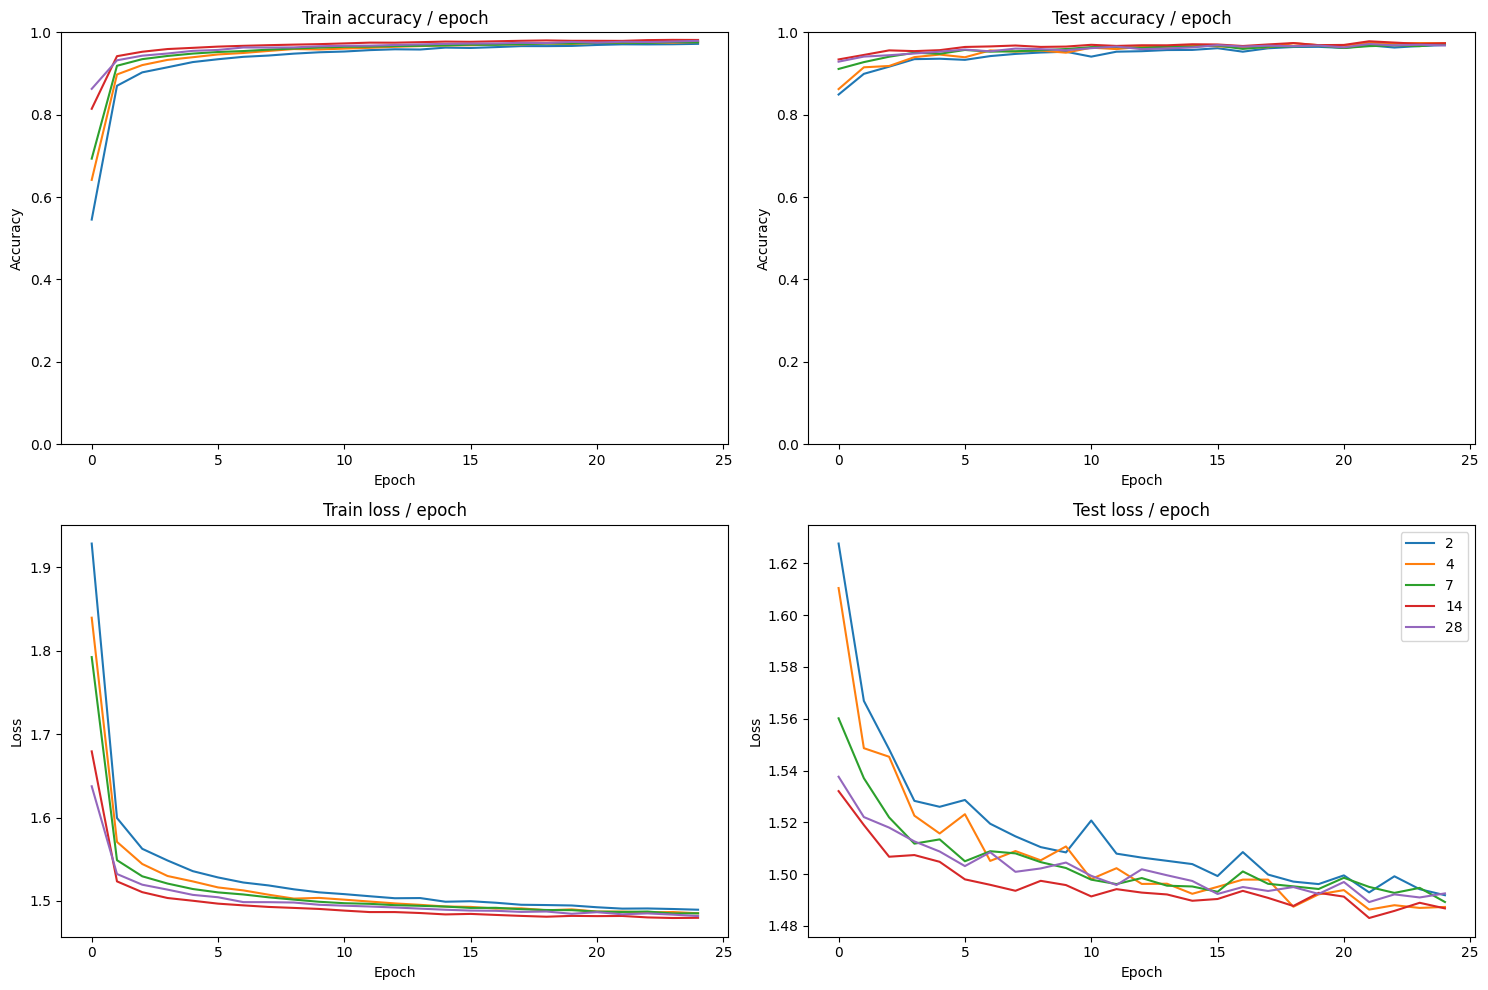

In [20]:
plot_plot_optimizers(plot_optimizers_patch_size, 'patch_size_influence_25')

In [21]:
plot_optimizers_nb_blocks = {}
for nb_blocks in [2,4,6,8]:
    stats = main(epochs=25, nb_blocks=nb_blocks)
    plot_optimizers_nb_blocks[nb_blocks] = stats


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.699 | acc_test 0.885:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.699 | acc_test 0.885:   4%|██▌                                                            | 1/25 [00:06<02:37,  6.57s/it]


acc_train 0.905 | acc_test 0.925:   4%|██▌                                                            | 1/25 [00:13<02:37,  6.57s/it]


acc_train 0.905 | acc_test 0.925:   8%|█████                                                          | 2/25 [00:13<02:33,  6.69s/it]


acc_train 0.930 | acc_test 0.941:   8%|█████                                                          | 2/25 [00:19<02:33,  6.69s/it]


acc_train 0.930 | acc_test 0.941:  12%|███████▌                                                       | 3/25 [00:19<02:24,  6.57s/it]


acc_train 0.943 | acc_test 0.941:  12%|███████▌                                                       | 3/25 [00:26<02:24,  6.57s/it]


acc_train 0.943 | acc_test 0.941:  16%|██████████                                                     | 4/25 [00:26<02:19,  6.66s/it]


acc_train 0.948 | acc_test 0.951:  16%|██████████                                                     | 4/25 [00:33<02:19,  6.66s/it]


acc_train 0.948 | acc_test 0.951:  20%|████████████▌                                                  | 5/25 [00:33<02:12,  6.63s/it]


acc_train 0.955 | acc_test 0.951:  20%|████████████▌                                                  | 5/25 [00:39<02:12,  6.63s/it]


acc_train 0.955 | acc_test 0.951:  24%|███████████████                                                | 6/25 [00:39<02:05,  6.61s/it]


acc_train 0.958 | acc_test 0.959:  24%|███████████████                                                | 6/25 [00:46<02:05,  6.61s/it]


acc_train 0.958 | acc_test 0.959:  28%|█████████████████▋                                             | 7/25 [00:46<01:59,  6.62s/it]


acc_train 0.962 | acc_test 0.955:  28%|█████████████████▋                                             | 7/25 [00:53<01:59,  6.62s/it]


acc_train 0.962 | acc_test 0.955:  32%|████████████████████▏                                          | 8/25 [00:53<01:52,  6.63s/it]


acc_train 0.963 | acc_test 0.957:  32%|████████████████████▏                                          | 8/25 [00:59<01:52,  6.63s/it]


acc_train 0.963 | acc_test 0.957:  36%|██████████████████████▋                                        | 9/25 [00:59<01:45,  6.59s/it]


acc_train 0.964 | acc_test 0.962:  36%|██████████████████████▋                                        | 9/25 [01:05<01:45,  6.59s/it]


acc_train 0.964 | acc_test 0.962:  40%|████████████████████████▊                                     | 10/25 [01:05<01:38,  6.54s/it]


acc_train 0.966 | acc_test 0.965:  40%|████████████████████████▊                                     | 10/25 [01:12<01:38,  6.54s/it]


acc_train 0.966 | acc_test 0.965:  44%|███████████████████████████▎                                  | 11/25 [01:12<01:31,  6.50s/it]


acc_train 0.969 | acc_test 0.960:  44%|███████████████████████████▎                                  | 11/25 [01:18<01:31,  6.50s/it]


acc_train 0.969 | acc_test 0.960:  48%|█████████████████████████████▊                                | 12/25 [01:18<01:24,  6.48s/it]


acc_train 0.970 | acc_test 0.966:  48%|█████████████████████████████▊                                | 12/25 [01:25<01:24,  6.48s/it]


acc_train 0.970 | acc_test 0.966:  52%|████████████████████████████████▏                             | 13/25 [01:25<01:17,  6.46s/it]


acc_train 0.972 | acc_test 0.963:  52%|████████████████████████████████▏                             | 13/25 [01:31<01:17,  6.46s/it]


acc_train 0.972 | acc_test 0.963:  56%|██████████████████████████████████▋                           | 14/25 [01:31<01:10,  6.45s/it]


acc_train 0.972 | acc_test 0.964:  56%|██████████████████████████████████▋                           | 14/25 [01:38<01:10,  6.45s/it]


acc_train 0.972 | acc_test 0.964:  60%|█████████████████████████████████████▏                        | 15/25 [01:38<01:04,  6.44s/it]


acc_train 0.974 | acc_test 0.967:  60%|█████████████████████████████████████▏                        | 15/25 [01:44<01:04,  6.44s/it]


acc_train 0.974 | acc_test 0.967:  64%|███████████████████████████████████████▋                      | 16/25 [01:44<00:57,  6.43s/it]


acc_train 0.975 | acc_test 0.968:  64%|███████████████████████████████████████▋                      | 16/25 [01:51<00:57,  6.43s/it]


acc_train 0.975 | acc_test 0.968:  68%|██████████████████████████████████████████▏                   | 17/25 [01:51<00:51,  6.47s/it]


acc_train 0.974 | acc_test 0.970:  68%|██████████████████████████████████████████▏                   | 17/25 [01:57<00:51,  6.47s/it]


acc_train 0.974 | acc_test 0.970:  72%|████████████████████████████████████████████▋                 | 18/25 [01:57<00:45,  6.50s/it]


acc_train 0.976 | acc_test 0.966:  72%|████████████████████████████████████████████▋                 | 18/25 [02:04<00:45,  6.50s/it]


acc_train 0.976 | acc_test 0.966:  76%|███████████████████████████████████████████████               | 19/25 [02:04<00:38,  6.48s/it]


acc_train 0.977 | acc_test 0.969:  76%|███████████████████████████████████████████████               | 19/25 [02:10<00:38,  6.48s/it]


acc_train 0.977 | acc_test 0.969:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:10<00:32,  6.52s/it]


acc_train 0.977 | acc_test 0.969:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:17<00:32,  6.52s/it]


acc_train 0.977 | acc_test 0.969:  84%|████████████████████████████████████████████████████          | 21/25 [02:17<00:26,  6.59s/it]


acc_train 0.977 | acc_test 0.972:  84%|████████████████████████████████████████████████████          | 21/25 [02:23<00:26,  6.59s/it]


acc_train 0.977 | acc_test 0.972:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:23<00:19,  6.55s/it]


acc_train 0.978 | acc_test 0.967:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:30<00:19,  6.55s/it]


acc_train 0.978 | acc_test 0.967:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:30<00:13,  6.52s/it]


acc_train 0.978 | acc_test 0.972:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:36<00:13,  6.52s/it]


acc_train 0.978 | acc_test 0.972:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:36<00:06,  6.50s/it]


acc_train 0.980 | acc_test 0.971:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:43<00:06,  6.50s/it]


acc_train 0.980 | acc_test 0.971: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.49s/it]


acc_train 0.980 | acc_test 0.971: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.53s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.719 | acc_test 0.902:   0%|                                                                       | 0/25 [00:08<?, ?it/s]


acc_train 0.719 | acc_test 0.902:   4%|██▌                                                            | 1/25 [00:08<03:12,  8.03s/it]


acc_train 0.917 | acc_test 0.928:   4%|██▌                                                            | 1/25 [00:15<03:12,  8.03s/it]


acc_train 0.917 | acc_test 0.928:   8%|█████                                                          | 2/25 [00:15<03:01,  7.90s/it]


acc_train 0.934 | acc_test 0.937:   8%|█████                                                          | 2/25 [00:23<03:01,  7.90s/it]


acc_train 0.934 | acc_test 0.937:  12%|███████▌                                                       | 3/25 [00:23<02:52,  7.86s/it]


acc_train 0.945 | acc_test 0.945:  12%|███████▌                                                       | 3/25 [00:31<02:52,  7.86s/it]


acc_train 0.945 | acc_test 0.945:  16%|██████████                                                     | 4/25 [00:31<02:44,  7.84s/it]


acc_train 0.950 | acc_test 0.942:  16%|██████████                                                     | 4/25 [00:39<02:44,  7.84s/it]


acc_train 0.950 | acc_test 0.942:  20%|████████████▌                                                  | 5/25 [00:39<02:36,  7.83s/it]


acc_train 0.953 | acc_test 0.959:  20%|████████████▌                                                  | 5/25 [00:47<02:36,  7.83s/it]


acc_train 0.953 | acc_test 0.959:  24%|███████████████                                                | 6/25 [00:47<02:28,  7.82s/it]


acc_train 0.956 | acc_test 0.962:  24%|███████████████                                                | 6/25 [00:54<02:28,  7.82s/it]


acc_train 0.956 | acc_test 0.962:  28%|█████████████████▋                                             | 7/25 [00:54<02:19,  7.77s/it]


acc_train 0.957 | acc_test 0.952:  28%|█████████████████▋                                             | 7/25 [01:02<02:19,  7.77s/it]


acc_train 0.957 | acc_test 0.952:  32%|████████████████████▏                                          | 8/25 [01:02<02:11,  7.75s/it]


acc_train 0.959 | acc_test 0.948:  32%|████████████████████▏                                          | 8/25 [01:10<02:11,  7.75s/it]


acc_train 0.959 | acc_test 0.948:  36%|██████████████████████▋                                        | 9/25 [01:10<02:03,  7.73s/it]


acc_train 0.963 | acc_test 0.965:  36%|██████████████████████▋                                        | 9/25 [01:17<02:03,  7.73s/it]


acc_train 0.963 | acc_test 0.965:  40%|████████████████████████▊                                     | 10/25 [01:17<01:55,  7.72s/it]


acc_train 0.964 | acc_test 0.965:  40%|████████████████████████▊                                     | 10/25 [01:25<01:55,  7.72s/it]


acc_train 0.964 | acc_test 0.965:  44%|███████████████████████████▎                                  | 11/25 [01:25<01:47,  7.70s/it]


acc_train 0.965 | acc_test 0.966:  44%|███████████████████████████▎                                  | 11/25 [01:33<01:47,  7.70s/it]


acc_train 0.965 | acc_test 0.966:  48%|█████████████████████████████▊                                | 12/25 [01:33<01:41,  7.83s/it]


acc_train 0.968 | acc_test 0.962:  48%|█████████████████████████████▊                                | 12/25 [01:41<01:41,  7.83s/it]


acc_train 0.968 | acc_test 0.962:  52%|████████████████████████████████▏                             | 13/25 [01:41<01:33,  7.83s/it]


acc_train 0.968 | acc_test 0.968:  52%|████████████████████████████████▏                             | 13/25 [01:49<01:33,  7.83s/it]


acc_train 0.968 | acc_test 0.968:  56%|██████████████████████████████████▋                           | 14/25 [01:49<01:26,  7.83s/it]


acc_train 0.968 | acc_test 0.969:  56%|██████████████████████████████████▋                           | 14/25 [01:56<01:26,  7.83s/it]


acc_train 0.968 | acc_test 0.969:  60%|█████████████████████████████████████▏                        | 15/25 [01:56<01:17,  7.78s/it]


acc_train 0.969 | acc_test 0.960:  60%|█████████████████████████████████████▏                        | 15/25 [02:04<01:17,  7.78s/it]


acc_train 0.969 | acc_test 0.960:  64%|███████████████████████████████████████▋                      | 16/25 [02:04<01:09,  7.75s/it]


acc_train 0.971 | acc_test 0.952:  64%|███████████████████████████████████████▋                      | 16/25 [02:12<01:09,  7.75s/it]


acc_train 0.971 | acc_test 0.952:  68%|██████████████████████████████████████████▏                   | 17/25 [02:12<01:02,  7.82s/it]


acc_train 0.972 | acc_test 0.969:  68%|██████████████████████████████████████████▏                   | 17/25 [02:20<01:02,  7.82s/it]


acc_train 0.972 | acc_test 0.969:  72%|████████████████████████████████████████████▋                 | 18/25 [02:20<00:54,  7.81s/it]


acc_train 0.971 | acc_test 0.968:  72%|████████████████████████████████████████████▋                 | 18/25 [02:28<00:54,  7.81s/it]


acc_train 0.971 | acc_test 0.968:  76%|███████████████████████████████████████████████               | 19/25 [02:28<00:46,  7.81s/it]


acc_train 0.973 | acc_test 0.968:  76%|███████████████████████████████████████████████               | 19/25 [02:36<00:46,  7.81s/it]


acc_train 0.973 | acc_test 0.968:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:36<00:39,  7.86s/it]


acc_train 0.971 | acc_test 0.968:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:43<00:39,  7.86s/it]


acc_train 0.971 | acc_test 0.968:  84%|████████████████████████████████████████████████████          | 21/25 [02:43<00:31,  7.84s/it]


acc_train 0.975 | acc_test 0.972:  84%|████████████████████████████████████████████████████          | 21/25 [02:51<00:31,  7.84s/it]


acc_train 0.975 | acc_test 0.972:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:51<00:23,  7.83s/it]


acc_train 0.975 | acc_test 0.971:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:59<00:23,  7.83s/it]


acc_train 0.975 | acc_test 0.971:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:59<00:15,  7.82s/it]


acc_train 0.973 | acc_test 0.970:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:07<00:15,  7.82s/it]


acc_train 0.973 | acc_test 0.970:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:07<00:07,  7.77s/it]


acc_train 0.973 | acc_test 0.959:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:15<00:07,  7.77s/it]


acc_train 0.973 | acc_test 0.959: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:15<00:00,  7.78s/it]


acc_train 0.973 | acc_test 0.959: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:15<00:00,  7.80s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.721 | acc_test 0.912:   0%|                                                                       | 0/25 [00:08<?, ?it/s]


acc_train 0.721 | acc_test 0.912:   4%|██▌                                                            | 1/25 [00:08<03:33,  8.89s/it]


acc_train 0.931 | acc_test 0.949:   4%|██▌                                                            | 1/25 [00:17<03:33,  8.89s/it]


acc_train 0.931 | acc_test 0.949:   8%|█████                                                          | 2/25 [00:17<03:25,  8.96s/it]


acc_train 0.944 | acc_test 0.952:   8%|█████                                                          | 2/25 [00:26<03:25,  8.96s/it]


acc_train 0.944 | acc_test 0.952:  12%|███████▌                                                       | 3/25 [00:26<03:16,  8.95s/it]


acc_train 0.950 | acc_test 0.950:  12%|███████▌                                                       | 3/25 [00:35<03:16,  8.95s/it]


acc_train 0.950 | acc_test 0.950:  16%|██████████                                                     | 4/25 [00:35<03:08,  8.99s/it]


acc_train 0.957 | acc_test 0.949:  16%|██████████                                                     | 4/25 [00:44<03:08,  8.99s/it]


acc_train 0.957 | acc_test 0.949:  20%|████████████▌                                                  | 5/25 [00:44<02:59,  8.95s/it]


acc_train 0.959 | acc_test 0.963:  20%|████████████▌                                                  | 5/25 [00:53<02:59,  8.95s/it]


acc_train 0.959 | acc_test 0.963:  24%|███████████████                                                | 6/25 [00:53<02:50,  8.99s/it]


acc_train 0.963 | acc_test 0.957:  24%|███████████████                                                | 6/25 [01:02<02:50,  8.99s/it]


acc_train 0.963 | acc_test 0.957:  28%|█████████████████▋                                             | 7/25 [01:02<02:41,  8.96s/it]


acc_train 0.965 | acc_test 0.958:  28%|█████████████████▋                                             | 7/25 [01:11<02:41,  8.96s/it]


acc_train 0.965 | acc_test 0.958:  32%|████████████████████▏                                          | 8/25 [01:11<02:32,  8.94s/it]


acc_train 0.968 | acc_test 0.963:  32%|████████████████████▏                                          | 8/25 [01:20<02:32,  8.94s/it]


acc_train 0.968 | acc_test 0.963:  36%|██████████████████████▋                                        | 9/25 [01:20<02:22,  8.93s/it]


acc_train 0.967 | acc_test 0.971:  36%|██████████████████████▋                                        | 9/25 [01:29<02:22,  8.93s/it]


acc_train 0.967 | acc_test 0.971:  40%|████████████████████████▊                                     | 10/25 [01:29<02:13,  8.92s/it]


acc_train 0.967 | acc_test 0.955:  40%|████████████████████████▊                                     | 10/25 [01:38<02:13,  8.92s/it]


acc_train 0.967 | acc_test 0.955:  44%|███████████████████████████▎                                  | 11/25 [01:38<02:04,  8.91s/it]


acc_train 0.970 | acc_test 0.964:  44%|███████████████████████████▎                                  | 11/25 [01:47<02:04,  8.91s/it]


acc_train 0.970 | acc_test 0.964:  48%|█████████████████████████████▊                                | 12/25 [01:47<01:55,  8.91s/it]


acc_train 0.971 | acc_test 0.970:  48%|█████████████████████████████▊                                | 12/25 [01:56<01:55,  8.91s/it]


acc_train 0.971 | acc_test 0.970:  52%|████████████████████████████████▏                             | 13/25 [01:56<01:48,  9.01s/it]


acc_train 0.970 | acc_test 0.961:  52%|████████████████████████████████▏                             | 13/25 [02:05<01:48,  9.01s/it]


acc_train 0.970 | acc_test 0.961:  56%|██████████████████████████████████▋                           | 14/25 [02:05<01:40,  9.12s/it]


acc_train 0.971 | acc_test 0.971:  56%|██████████████████████████████████▋                           | 14/25 [02:14<01:40,  9.12s/it]


acc_train 0.971 | acc_test 0.971:  60%|█████████████████████████████████████▏                        | 15/25 [02:14<01:31,  9.11s/it]


acc_train 0.972 | acc_test 0.974:  60%|█████████████████████████████████████▏                        | 15/25 [02:24<01:31,  9.11s/it]


acc_train 0.972 | acc_test 0.974:  64%|███████████████████████████████████████▋                      | 16/25 [02:24<01:22,  9.11s/it]


acc_train 0.972 | acc_test 0.972:  64%|███████████████████████████████████████▋                      | 16/25 [02:33<01:22,  9.11s/it]


acc_train 0.972 | acc_test 0.972:  68%|██████████████████████████████████████████▏                   | 17/25 [02:33<01:12,  9.09s/it]


acc_train 0.973 | acc_test 0.968:  68%|██████████████████████████████████████████▏                   | 17/25 [02:42<01:12,  9.09s/it]


acc_train 0.973 | acc_test 0.968:  72%|████████████████████████████████████████████▋                 | 18/25 [02:42<01:03,  9.07s/it]


acc_train 0.974 | acc_test 0.963:  72%|████████████████████████████████████████████▋                 | 18/25 [02:51<01:03,  9.07s/it]


acc_train 0.974 | acc_test 0.963:  76%|███████████████████████████████████████████████               | 19/25 [02:51<00:54,  9.06s/it]


acc_train 0.972 | acc_test 0.964:  76%|███████████████████████████████████████████████               | 19/25 [03:00<00:54,  9.06s/it]


acc_train 0.972 | acc_test 0.964:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:00<00:45,  9.10s/it]


acc_train 0.972 | acc_test 0.972:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:09<00:45,  9.10s/it]


acc_train 0.972 | acc_test 0.972:  84%|████████████████████████████████████████████████████          | 21/25 [03:09<00:36,  9.05s/it]


acc_train 0.974 | acc_test 0.969:  84%|████████████████████████████████████████████████████          | 21/25 [03:18<00:36,  9.05s/it]


acc_train 0.974 | acc_test 0.969:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:18<00:27,  9.00s/it]


acc_train 0.974 | acc_test 0.975:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:27<00:27,  9.00s/it]


acc_train 0.974 | acc_test 0.975:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:27<00:17,  8.98s/it]


acc_train 0.974 | acc_test 0.970:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:36<00:17,  8.98s/it]


acc_train 0.974 | acc_test 0.970:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:36<00:09,  9.03s/it]


acc_train 0.975 | acc_test 0.968:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [03:45<00:09,  9.03s/it]


acc_train 0.975 | acc_test 0.968: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:45<00:00,  9.04s/it]


acc_train 0.975 | acc_test 0.968: 100%|██████████████████████████████████████████████████████████████| 25/25 [03:45<00:00,  9.01s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.686 | acc_test 0.903:   0%|                                                                       | 0/25 [00:10<?, ?it/s]


acc_train 0.686 | acc_test 0.903:   4%|██▌                                                            | 1/25 [00:10<04:06, 10.29s/it]


acc_train 0.923 | acc_test 0.938:   4%|██▌                                                            | 1/25 [00:20<04:06, 10.29s/it]


acc_train 0.923 | acc_test 0.938:   8%|█████                                                          | 2/25 [00:20<03:56, 10.29s/it]


acc_train 0.938 | acc_test 0.946:   8%|█████                                                          | 2/25 [00:31<03:56, 10.29s/it]


acc_train 0.938 | acc_test 0.946:  12%|███████▌                                                       | 3/25 [00:31<03:49, 10.43s/it]


acc_train 0.947 | acc_test 0.952:  12%|███████▌                                                       | 3/25 [00:41<03:49, 10.43s/it]


acc_train 0.947 | acc_test 0.952:  16%|██████████                                                     | 4/25 [00:41<03:37, 10.37s/it]


acc_train 0.947 | acc_test 0.955:  16%|██████████                                                     | 4/25 [00:51<03:37, 10.37s/it]


acc_train 0.947 | acc_test 0.955:  20%|████████████▌                                                  | 5/25 [00:51<03:27, 10.36s/it]


acc_train 0.952 | acc_test 0.960:  20%|████████████▌                                                  | 5/25 [01:02<03:27, 10.36s/it]


acc_train 0.952 | acc_test 0.960:  24%|███████████████                                                | 6/25 [01:02<03:16, 10.34s/it]


acc_train 0.954 | acc_test 0.947:  24%|███████████████                                                | 6/25 [01:12<03:16, 10.34s/it]


acc_train 0.954 | acc_test 0.947:  28%|█████████████████▋                                             | 7/25 [01:12<03:05, 10.32s/it]


acc_train 0.954 | acc_test 0.949:  28%|█████████████████▋                                             | 7/25 [01:22<03:05, 10.32s/it]


acc_train 0.954 | acc_test 0.949:  32%|████████████████████▏                                          | 8/25 [01:22<02:55, 10.32s/it]


acc_train 0.956 | acc_test 0.960:  32%|████████████████████▏                                          | 8/25 [01:32<02:55, 10.32s/it]


acc_train 0.956 | acc_test 0.960:  36%|██████████████████████▋                                        | 9/25 [01:32<02:44, 10.31s/it]


acc_train 0.958 | acc_test 0.926:  36%|██████████████████████▋                                        | 9/25 [01:43<02:44, 10.31s/it]


acc_train 0.958 | acc_test 0.926:  40%|████████████████████████▊                                     | 10/25 [01:43<02:35, 10.34s/it]


acc_train 0.958 | acc_test 0.962:  40%|████████████████████████▊                                     | 10/25 [01:53<02:35, 10.34s/it]


acc_train 0.958 | acc_test 0.962:  44%|███████████████████████████▎                                  | 11/25 [01:53<02:23, 10.27s/it]


acc_train 0.959 | acc_test 0.961:  44%|███████████████████████████▎                                  | 11/25 [02:04<02:23, 10.27s/it]


acc_train 0.959 | acc_test 0.961:  48%|█████████████████████████████▊                                | 12/25 [02:04<02:14, 10.35s/it]


acc_train 0.960 | acc_test 0.964:  48%|█████████████████████████████▊                                | 12/25 [02:14<02:14, 10.35s/it]


acc_train 0.960 | acc_test 0.964:  52%|████████████████████████████████▏                             | 13/25 [02:14<02:03, 10.31s/it]


acc_train 0.958 | acc_test 0.956:  52%|████████████████████████████████▏                             | 13/25 [02:24<02:03, 10.31s/it]


acc_train 0.958 | acc_test 0.956:  56%|██████████████████████████████████▋                           | 14/25 [02:24<01:53, 10.28s/it]


acc_train 0.954 | acc_test 0.964:  56%|██████████████████████████████████▋                           | 14/25 [02:34<01:53, 10.28s/it]


acc_train 0.954 | acc_test 0.964:  60%|█████████████████████████████████████▏                        | 15/25 [02:34<01:42, 10.23s/it]


acc_train 0.960 | acc_test 0.960:  60%|█████████████████████████████████████▏                        | 15/25 [02:44<01:42, 10.23s/it]


acc_train 0.960 | acc_test 0.960:  64%|███████████████████████████████████████▋                      | 16/25 [02:44<01:31, 10.19s/it]


acc_train 0.964 | acc_test 0.961:  64%|███████████████████████████████████████▋                      | 16/25 [02:54<01:31, 10.19s/it]


acc_train 0.964 | acc_test 0.961:  68%|██████████████████████████████████████████▏                   | 17/25 [02:54<01:21, 10.21s/it]


acc_train 0.963 | acc_test 0.966:  68%|██████████████████████████████████████████▏                   | 17/25 [03:05<01:21, 10.21s/it]


acc_train 0.963 | acc_test 0.966:  72%|████████████████████████████████████████████▋                 | 18/25 [03:05<01:11, 10.27s/it]


acc_train 0.961 | acc_test 0.962:  72%|████████████████████████████████████████████▋                 | 18/25 [03:15<01:11, 10.27s/it]


acc_train 0.961 | acc_test 0.962:  76%|███████████████████████████████████████████████               | 19/25 [03:15<01:01, 10.26s/it]


acc_train 0.961 | acc_test 0.962:  76%|███████████████████████████████████████████████               | 19/25 [03:25<01:01, 10.26s/it]


acc_train 0.961 | acc_test 0.962:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:25<00:51, 10.28s/it]


acc_train 0.962 | acc_test 0.964:  80%|█████████████████████████████████████████████████▌            | 20/25 [03:36<00:51, 10.28s/it]


acc_train 0.962 | acc_test 0.964:  84%|████████████████████████████████████████████████████          | 21/25 [03:36<00:40, 10.25s/it]


acc_train 0.961 | acc_test 0.972:  84%|████████████████████████████████████████████████████          | 21/25 [03:46<00:40, 10.25s/it]


acc_train 0.961 | acc_test 0.972:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:46<00:31, 10.38s/it]


acc_train 0.964 | acc_test 0.966:  88%|██████████████████████████████████████████████████████▌       | 22/25 [03:56<00:31, 10.38s/it]


acc_train 0.964 | acc_test 0.966:  92%|█████████████████████████████████████████████████████████     | 23/25 [03:56<00:20, 10.31s/it]


acc_train 0.958 | acc_test 0.953:  92%|█████████████████████████████████████████████████████████     | 23/25 [04:07<00:20, 10.31s/it]


acc_train 0.958 | acc_test 0.953:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [04:07<00:10, 10.27s/it]


acc_train 0.961 | acc_test 0.964:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [04:17<00:10, 10.27s/it]


acc_train 0.961 | acc_test 0.964: 100%|██████████████████████████████████████████████████████████████| 25/25 [04:17<00:00, 10.24s/it]


acc_train 0.961 | acc_test 0.964: 100%|██████████████████████████████████████████████████████████████| 25/25 [04:17<00:00, 10.29s/it]

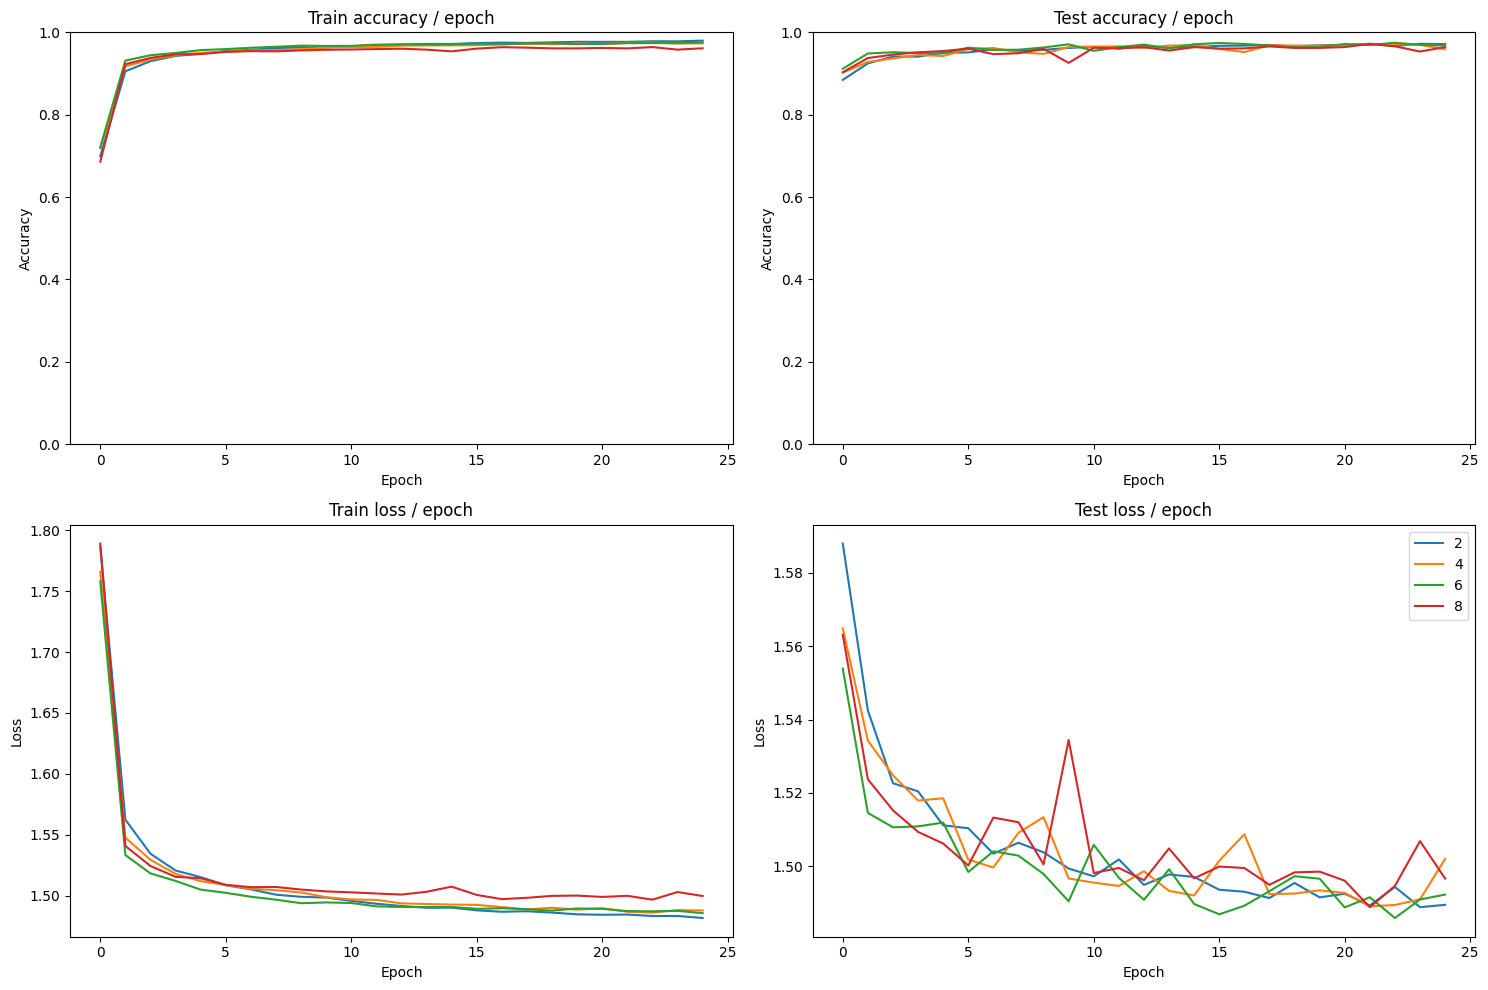

In [22]:
plot_plot_optimizers(plot_optimizers_nb_blocks, 'nb_block_influence_25')

In [23]:
plot_optimizers_num_heads = {}
for num_heads in [2,4,8,16]:
    stats = main(epochs=25, num_heads=num_heads)
    plot_optimizers_num_heads[num_heads] = stats


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.639 | acc_test 0.798:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.639 | acc_test 0.798:   4%|██▌                                                            | 1/25 [00:06<02:42,  6.75s/it]


acc_train 0.857 | acc_test 0.901:   4%|██▌                                                            | 1/25 [00:13<02:42,  6.75s/it]


acc_train 0.857 | acc_test 0.901:   8%|█████                                                          | 2/25 [00:13<02:30,  6.56s/it]


acc_train 0.901 | acc_test 0.917:   8%|█████                                                          | 2/25 [00:19<02:30,  6.56s/it]


acc_train 0.901 | acc_test 0.917:  12%|███████▌                                                       | 3/25 [00:19<02:22,  6.49s/it]


acc_train 0.917 | acc_test 0.929:  12%|███████▌                                                       | 3/25 [00:26<02:22,  6.49s/it]


acc_train 0.917 | acc_test 0.929:  16%|██████████                                                     | 4/25 [00:26<02:15,  6.46s/it]


acc_train 0.927 | acc_test 0.923:  16%|██████████                                                     | 4/25 [00:32<02:15,  6.46s/it]


acc_train 0.927 | acc_test 0.923:  20%|████████████▌                                                  | 5/25 [00:32<02:09,  6.45s/it]


acc_train 0.933 | acc_test 0.935:  20%|████████████▌                                                  | 5/25 [00:38<02:09,  6.45s/it]


acc_train 0.933 | acc_test 0.935:  24%|███████████████                                                | 6/25 [00:38<02:02,  6.44s/it]


acc_train 0.940 | acc_test 0.941:  24%|███████████████                                                | 6/25 [00:45<02:02,  6.44s/it]


acc_train 0.940 | acc_test 0.941:  28%|█████████████████▋                                             | 7/25 [00:45<01:55,  6.43s/it]


acc_train 0.942 | acc_test 0.948:  28%|█████████████████▋                                             | 7/25 [00:51<01:55,  6.43s/it]


acc_train 0.942 | acc_test 0.948:  32%|████████████████████▏                                          | 8/25 [00:51<01:49,  6.43s/it]


acc_train 0.946 | acc_test 0.949:  32%|████████████████████▏                                          | 8/25 [00:58<01:49,  6.43s/it]


acc_train 0.946 | acc_test 0.949:  36%|██████████████████████▋                                        | 9/25 [00:58<01:42,  6.43s/it]


acc_train 0.949 | acc_test 0.949:  36%|██████████████████████▋                                        | 9/25 [01:04<01:42,  6.43s/it]


acc_train 0.949 | acc_test 0.949:  40%|████████████████████████▊                                     | 10/25 [01:04<01:36,  6.42s/it]


acc_train 0.952 | acc_test 0.951:  40%|████████████████████████▊                                     | 10/25 [01:10<01:36,  6.42s/it]


acc_train 0.952 | acc_test 0.951:  44%|███████████████████████████▎                                  | 11/25 [01:10<01:29,  6.42s/it]


acc_train 0.952 | acc_test 0.956:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:29,  6.42s/it]


acc_train 0.952 | acc_test 0.956:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:24,  6.47s/it]


acc_train 0.955 | acc_test 0.959:  48%|█████████████████████████████▊                                | 12/25 [01:24<01:24,  6.47s/it]


acc_train 0.955 | acc_test 0.959:  52%|████████████████████████████████▏                             | 13/25 [01:24<01:18,  6.52s/it]


acc_train 0.956 | acc_test 0.957:  52%|████████████████████████████████▏                             | 13/25 [01:31<01:18,  6.52s/it]


acc_train 0.956 | acc_test 0.957:  56%|██████████████████████████████████▋                           | 14/25 [01:31<01:12,  6.63s/it]


acc_train 0.957 | acc_test 0.953:  56%|██████████████████████████████████▋                           | 14/25 [01:37<01:12,  6.63s/it]


acc_train 0.957 | acc_test 0.953:  60%|█████████████████████████████████████▏                        | 15/25 [01:37<01:06,  6.60s/it]


acc_train 0.959 | acc_test 0.958:  60%|█████████████████████████████████████▏                        | 15/25 [01:44<01:06,  6.60s/it]


acc_train 0.959 | acc_test 0.958:  64%|███████████████████████████████████████▋                      | 16/25 [01:44<00:59,  6.63s/it]


acc_train 0.960 | acc_test 0.956:  64%|███████████████████████████████████████▋                      | 16/25 [01:50<00:59,  6.63s/it]


acc_train 0.960 | acc_test 0.956:  68%|██████████████████████████████████████████▏                   | 17/25 [01:50<00:52,  6.60s/it]


acc_train 0.961 | acc_test 0.956:  68%|██████████████████████████████████████████▏                   | 17/25 [01:57<00:52,  6.60s/it]


acc_train 0.961 | acc_test 0.956:  72%|████████████████████████████████████████████▋                 | 18/25 [01:57<00:46,  6.59s/it]


acc_train 0.964 | acc_test 0.962:  72%|████████████████████████████████████████████▋                 | 18/25 [02:03<00:46,  6.59s/it]


acc_train 0.964 | acc_test 0.962:  76%|███████████████████████████████████████████████               | 19/25 [02:03<00:39,  6.57s/it]


acc_train 0.964 | acc_test 0.962:  76%|███████████████████████████████████████████████               | 19/25 [02:10<00:39,  6.57s/it]


acc_train 0.964 | acc_test 0.962:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:10<00:32,  6.56s/it]


acc_train 0.964 | acc_test 0.960:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:17<00:32,  6.56s/it]


acc_train 0.964 | acc_test 0.960:  84%|████████████████████████████████████████████████████          | 21/25 [02:17<00:26,  6.56s/it]


acc_train 0.965 | acc_test 0.965:  84%|████████████████████████████████████████████████████          | 21/25 [02:23<00:26,  6.56s/it]


acc_train 0.965 | acc_test 0.965:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:23<00:19,  6.61s/it]


acc_train 0.967 | acc_test 0.961:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:30<00:19,  6.61s/it]


acc_train 0.967 | acc_test 0.961:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:30<00:13,  6.55s/it]


acc_train 0.967 | acc_test 0.968:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:36<00:13,  6.55s/it]


acc_train 0.967 | acc_test 0.968:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:36<00:06,  6.51s/it]


acc_train 0.968 | acc_test 0.965:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:43<00:06,  6.51s/it]


acc_train 0.968 | acc_test 0.965: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.53s/it]


acc_train 0.968 | acc_test 0.965: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.53s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.698 | acc_test 0.903:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.698 | acc_test 0.903:   4%|██▌                                                            | 1/25 [00:06<02:43,  6.83s/it]


acc_train 0.915 | acc_test 0.924:   4%|██▌                                                            | 1/25 [00:13<02:43,  6.83s/it]


acc_train 0.915 | acc_test 0.924:   8%|█████                                                          | 2/25 [00:13<02:35,  6.77s/it]


acc_train 0.936 | acc_test 0.931:   8%|█████                                                          | 2/25 [00:20<02:35,  6.77s/it]


acc_train 0.936 | acc_test 0.931:  12%|███████▌                                                       | 3/25 [00:20<02:32,  6.91s/it]


acc_train 0.945 | acc_test 0.942:  12%|███████▌                                                       | 3/25 [00:27<02:32,  6.91s/it]


acc_train 0.945 | acc_test 0.942:  16%|██████████                                                     | 4/25 [00:27<02:22,  6.78s/it]


acc_train 0.952 | acc_test 0.949:  16%|██████████                                                     | 4/25 [00:33<02:22,  6.78s/it]


acc_train 0.952 | acc_test 0.949:  20%|████████████▌                                                  | 5/25 [00:33<02:14,  6.70s/it]


acc_train 0.955 | acc_test 0.955:  20%|████████████▌                                                  | 5/25 [00:40<02:14,  6.70s/it]


acc_train 0.955 | acc_test 0.955:  24%|███████████████                                                | 6/25 [00:40<02:06,  6.66s/it]


acc_train 0.959 | acc_test 0.958:  24%|███████████████                                                | 6/25 [00:46<02:06,  6.66s/it]


acc_train 0.959 | acc_test 0.958:  28%|█████████████████▋                                             | 7/25 [00:46<01:59,  6.62s/it]


acc_train 0.963 | acc_test 0.962:  28%|█████████████████▋                                             | 7/25 [00:53<01:59,  6.62s/it]


acc_train 0.963 | acc_test 0.962:  32%|████████████████████▏                                          | 8/25 [00:53<01:52,  6.60s/it]


acc_train 0.964 | acc_test 0.959:  32%|████████████████████▏                                          | 8/25 [01:00<01:52,  6.60s/it]


acc_train 0.964 | acc_test 0.959:  36%|██████████████████████▋                                        | 9/25 [01:00<01:45,  6.61s/it]


acc_train 0.966 | acc_test 0.957:  36%|██████████████████████▋                                        | 9/25 [01:06<01:45,  6.61s/it]


acc_train 0.966 | acc_test 0.957:  40%|████████████████████████▊                                     | 10/25 [01:06<01:39,  6.66s/it]


acc_train 0.968 | acc_test 0.961:  40%|████████████████████████▊                                     | 10/25 [01:13<01:39,  6.66s/it]


acc_train 0.968 | acc_test 0.961:  44%|███████████████████████████▎                                  | 11/25 [01:13<01:32,  6.63s/it]


acc_train 0.969 | acc_test 0.963:  44%|███████████████████████████▎                                  | 11/25 [01:20<01:32,  6.63s/it]


acc_train 0.969 | acc_test 0.963:  48%|█████████████████████████████▊                                | 12/25 [01:20<01:26,  6.66s/it]


acc_train 0.970 | acc_test 0.962:  48%|█████████████████████████████▊                                | 12/25 [01:26<01:26,  6.66s/it]


acc_train 0.970 | acc_test 0.962:  52%|████████████████████████████████▏                             | 13/25 [01:26<01:19,  6.64s/it]


acc_train 0.972 | acc_test 0.967:  52%|████████████████████████████████▏                             | 13/25 [01:33<01:19,  6.64s/it]


acc_train 0.972 | acc_test 0.967:  56%|██████████████████████████████████▋                           | 14/25 [01:33<01:12,  6.57s/it]


acc_train 0.973 | acc_test 0.965:  56%|██████████████████████████████████▋                           | 14/25 [01:39<01:12,  6.57s/it]


acc_train 0.973 | acc_test 0.965:  60%|█████████████████████████████████████▏                        | 15/25 [01:39<01:05,  6.52s/it]


acc_train 0.974 | acc_test 0.968:  60%|█████████████████████████████████████▏                        | 15/25 [01:45<01:05,  6.52s/it]


acc_train 0.974 | acc_test 0.968:  64%|███████████████████████████████████████▋                      | 16/25 [01:45<00:58,  6.49s/it]


acc_train 0.975 | acc_test 0.970:  64%|███████████████████████████████████████▋                      | 16/25 [01:52<00:58,  6.49s/it]


acc_train 0.975 | acc_test 0.970:  68%|██████████████████████████████████████████▏                   | 17/25 [01:52<00:51,  6.46s/it]


acc_train 0.976 | acc_test 0.968:  68%|██████████████████████████████████████████▏                   | 17/25 [01:58<00:51,  6.46s/it]


acc_train 0.976 | acc_test 0.968:  72%|████████████████████████████████████████████▋                 | 18/25 [01:58<00:45,  6.44s/it]


acc_train 0.976 | acc_test 0.967:  72%|████████████████████████████████████████████▋                 | 18/25 [02:05<00:45,  6.44s/it]


acc_train 0.976 | acc_test 0.967:  76%|███████████████████████████████████████████████               | 19/25 [02:05<00:38,  6.43s/it]


acc_train 0.976 | acc_test 0.970:  76%|███████████████████████████████████████████████               | 19/25 [02:11<00:38,  6.43s/it]


acc_train 0.976 | acc_test 0.970:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:11<00:32,  6.42s/it]


acc_train 0.976 | acc_test 0.968:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:18<00:32,  6.42s/it]


acc_train 0.976 | acc_test 0.968:  84%|████████████████████████████████████████████████████          | 21/25 [02:18<00:25,  6.46s/it]


acc_train 0.977 | acc_test 0.971:  84%|████████████████████████████████████████████████████          | 21/25 [02:24<00:25,  6.46s/it]


acc_train 0.977 | acc_test 0.971:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:24<00:19,  6.45s/it]


acc_train 0.978 | acc_test 0.970:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:30<00:19,  6.45s/it]


acc_train 0.978 | acc_test 0.970:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:30<00:12,  6.44s/it]


acc_train 0.979 | acc_test 0.971:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:37<00:12,  6.44s/it]


acc_train 0.979 | acc_test 0.971:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:37<00:06,  6.48s/it]


acc_train 0.980 | acc_test 0.974:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:44<00:06,  6.48s/it]


acc_train 0.980 | acc_test 0.974: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:44<00:00,  6.51s/it]


acc_train 0.980 | acc_test 0.974: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:44<00:00,  6.56s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.659 | acc_test 0.880:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.659 | acc_test 0.880:   4%|██▌                                                            | 1/25 [00:06<02:34,  6.42s/it]


acc_train 0.913 | acc_test 0.932:   4%|██▌                                                            | 1/25 [00:12<02:34,  6.42s/it]


acc_train 0.913 | acc_test 0.932:   8%|█████                                                          | 2/25 [00:12<02:27,  6.42s/it]


acc_train 0.937 | acc_test 0.943:   8%|█████                                                          | 2/25 [00:19<02:27,  6.42s/it]


acc_train 0.937 | acc_test 0.943:  12%|███████▌                                                       | 3/25 [00:19<02:23,  6.53s/it]


acc_train 0.944 | acc_test 0.939:  12%|███████▌                                                       | 3/25 [00:25<02:23,  6.53s/it]


acc_train 0.944 | acc_test 0.939:  16%|██████████                                                     | 4/25 [00:25<02:16,  6.49s/it]


acc_train 0.950 | acc_test 0.951:  16%|██████████                                                     | 4/25 [00:32<02:16,  6.49s/it]


acc_train 0.950 | acc_test 0.951:  20%|████████████▌                                                  | 5/25 [00:32<02:09,  6.47s/it]


acc_train 0.955 | acc_test 0.956:  20%|████████████▌                                                  | 5/25 [00:38<02:09,  6.47s/it]


acc_train 0.955 | acc_test 0.956:  24%|███████████████                                                | 6/25 [00:38<02:02,  6.45s/it]


acc_train 0.959 | acc_test 0.958:  24%|███████████████                                                | 6/25 [00:45<02:02,  6.45s/it]


acc_train 0.959 | acc_test 0.958:  28%|█████████████████▋                                             | 7/25 [00:45<01:56,  6.49s/it]


acc_train 0.961 | acc_test 0.963:  28%|█████████████████▋                                             | 7/25 [00:51<01:56,  6.49s/it]


acc_train 0.961 | acc_test 0.963:  32%|████████████████████▏                                          | 8/25 [00:51<01:49,  6.46s/it]


acc_train 0.962 | acc_test 0.961:  32%|████████████████████▏                                          | 8/25 [00:58<01:49,  6.46s/it]


acc_train 0.962 | acc_test 0.961:  36%|██████████████████████▋                                        | 9/25 [00:58<01:43,  6.45s/it]


acc_train 0.966 | acc_test 0.960:  36%|██████████████████████▋                                        | 9/25 [01:04<01:43,  6.45s/it]


acc_train 0.966 | acc_test 0.960:  40%|████████████████████████▊                                     | 10/25 [01:04<01:36,  6.44s/it]


acc_train 0.966 | acc_test 0.961:  40%|████████████████████████▊                                     | 10/25 [01:11<01:36,  6.44s/it]


acc_train 0.966 | acc_test 0.961:  44%|███████████████████████████▎                                  | 11/25 [01:11<01:30,  6.47s/it]


acc_train 0.969 | acc_test 0.967:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:30,  6.47s/it]


acc_train 0.969 | acc_test 0.967:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:23,  6.45s/it]


acc_train 0.971 | acc_test 0.968:  48%|█████████████████████████████▊                                | 12/25 [01:24<01:23,  6.45s/it]


acc_train 0.971 | acc_test 0.968:  52%|████████████████████████████████▏                             | 13/25 [01:24<01:17,  6.48s/it]


acc_train 0.971 | acc_test 0.968:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:17,  6.48s/it]


acc_train 0.971 | acc_test 0.968:  56%|██████████████████████████████████▋                           | 14/25 [01:30<01:11,  6.45s/it]


acc_train 0.972 | acc_test 0.968:  56%|██████████████████████████████████▋                           | 14/25 [01:37<01:11,  6.45s/it]


acc_train 0.972 | acc_test 0.968:  60%|█████████████████████████████████████▏                        | 15/25 [01:37<01:04,  6.49s/it]


acc_train 0.972 | acc_test 0.965:  60%|█████████████████████████████████████▏                        | 15/25 [01:43<01:04,  6.49s/it]


acc_train 0.972 | acc_test 0.965:  64%|███████████████████████████████████████▋                      | 16/25 [01:43<00:58,  6.52s/it]


acc_train 0.974 | acc_test 0.965:  64%|███████████████████████████████████████▋                      | 16/25 [01:50<00:58,  6.52s/it]


acc_train 0.974 | acc_test 0.965:  68%|██████████████████████████████████████████▏                   | 17/25 [01:50<00:51,  6.48s/it]


acc_train 0.974 | acc_test 0.969:  68%|██████████████████████████████████████████▏                   | 17/25 [01:56<00:51,  6.48s/it]


acc_train 0.974 | acc_test 0.969:  72%|████████████████████████████████████████████▋                 | 18/25 [01:56<00:45,  6.49s/it]


acc_train 0.975 | acc_test 0.968:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:45,  6.49s/it]


acc_train 0.975 | acc_test 0.968:  76%|███████████████████████████████████████████████               | 19/25 [02:02<00:38,  6.46s/it]


acc_train 0.976 | acc_test 0.972:  76%|███████████████████████████████████████████████               | 19/25 [02:09<00:38,  6.46s/it]


acc_train 0.976 | acc_test 0.972:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:09<00:32,  6.43s/it]


acc_train 0.978 | acc_test 0.973:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:15<00:32,  6.43s/it]


acc_train 0.978 | acc_test 0.973:  84%|████████████████████████████████████████████████████          | 21/25 [02:15<00:25,  6.44s/it]


acc_train 0.979 | acc_test 0.972:  84%|████████████████████████████████████████████████████          | 21/25 [02:22<00:25,  6.44s/it]


acc_train 0.979 | acc_test 0.972:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:22<00:19,  6.42s/it]


acc_train 0.978 | acc_test 0.973:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:28<00:19,  6.42s/it]


acc_train 0.978 | acc_test 0.973:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:28<00:12,  6.46s/it]


acc_train 0.979 | acc_test 0.972:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:35<00:12,  6.46s/it]


acc_train 0.979 | acc_test 0.972:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:35<00:06,  6.44s/it]


acc_train 0.980 | acc_test 0.970:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:41<00:06,  6.44s/it]


acc_train 0.980 | acc_test 0.970: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.51s/it]


acc_train 0.980 | acc_test 0.970: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.47s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.743 | acc_test 0.917:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.743 | acc_test 0.917:   4%|██▌                                                            | 1/25 [00:06<02:33,  6.39s/it]


acc_train 0.933 | acc_test 0.942:   4%|██▌                                                            | 1/25 [00:12<02:33,  6.39s/it]


acc_train 0.933 | acc_test 0.942:   8%|█████                                                          | 2/25 [00:12<02:26,  6.38s/it]


acc_train 0.947 | acc_test 0.951:   8%|█████                                                          | 2/25 [00:19<02:26,  6.38s/it]


acc_train 0.947 | acc_test 0.951:  12%|███████▌                                                       | 3/25 [00:19<02:20,  6.38s/it]


acc_train 0.956 | acc_test 0.958:  12%|███████▌                                                       | 3/25 [00:25<02:20,  6.38s/it]


acc_train 0.956 | acc_test 0.958:  16%|██████████                                                     | 4/25 [00:25<02:14,  6.38s/it]


acc_train 0.960 | acc_test 0.958:  16%|██████████                                                     | 4/25 [00:31<02:14,  6.38s/it]


acc_train 0.960 | acc_test 0.958:  20%|████████████▌                                                  | 5/25 [00:31<02:07,  6.39s/it]


acc_train 0.961 | acc_test 0.959:  20%|████████████▌                                                  | 5/25 [00:38<02:07,  6.39s/it]


acc_train 0.961 | acc_test 0.959:  24%|███████████████                                                | 6/25 [00:38<02:02,  6.44s/it]


acc_train 0.964 | acc_test 0.965:  24%|███████████████                                                | 6/25 [00:45<02:02,  6.44s/it]


acc_train 0.964 | acc_test 0.965:  28%|█████████████████▋                                             | 7/25 [00:45<01:56,  6.47s/it]


acc_train 0.969 | acc_test 0.968:  28%|█████████████████▋                                             | 7/25 [00:51<01:56,  6.47s/it]


acc_train 0.969 | acc_test 0.968:  32%|████████████████████▏                                          | 8/25 [00:51<01:50,  6.50s/it]


acc_train 0.971 | acc_test 0.961:  32%|████████████████████▏                                          | 8/25 [00:57<01:50,  6.50s/it]


acc_train 0.971 | acc_test 0.961:  36%|██████████████████████▋                                        | 9/25 [00:57<01:43,  6.46s/it]


acc_train 0.972 | acc_test 0.966:  36%|██████████████████████▋                                        | 9/25 [01:04<01:43,  6.46s/it]


acc_train 0.972 | acc_test 0.966:  40%|████████████████████████▊                                     | 10/25 [01:04<01:37,  6.49s/it]


acc_train 0.972 | acc_test 0.967:  40%|████████████████████████▊                                     | 10/25 [01:10<01:37,  6.49s/it]


acc_train 0.972 | acc_test 0.967:  44%|███████████████████████████▎                                  | 11/25 [01:10<01:30,  6.45s/it]


acc_train 0.974 | acc_test 0.968:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:30,  6.45s/it]


acc_train 0.974 | acc_test 0.968:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:24,  6.53s/it]


acc_train 0.975 | acc_test 0.970:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:24,  6.53s/it]


acc_train 0.975 | acc_test 0.970:  52%|████████████████████████████████▏                             | 13/25 [01:23<01:17,  6.48s/it]


acc_train 0.976 | acc_test 0.968:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:17,  6.48s/it]


acc_train 0.976 | acc_test 0.968:  56%|██████████████████████████████████▋                           | 14/25 [01:30<01:10,  6.45s/it]


acc_train 0.977 | acc_test 0.969:  56%|██████████████████████████████████▋                           | 14/25 [01:36<01:10,  6.45s/it]


acc_train 0.977 | acc_test 0.969:  60%|█████████████████████████████████████▏                        | 15/25 [01:36<01:04,  6.43s/it]


acc_train 0.977 | acc_test 0.969:  60%|█████████████████████████████████████▏                        | 15/25 [01:43<01:04,  6.43s/it]


acc_train 0.977 | acc_test 0.969:  64%|███████████████████████████████████████▋                      | 16/25 [01:43<00:58,  6.45s/it]


acc_train 0.979 | acc_test 0.974:  64%|███████████████████████████████████████▋                      | 16/25 [01:49<00:58,  6.45s/it]


acc_train 0.979 | acc_test 0.974:  68%|██████████████████████████████████████████▏                   | 17/25 [01:49<00:51,  6.42s/it]


acc_train 0.978 | acc_test 0.974:  68%|██████████████████████████████████████████▏                   | 17/25 [01:56<00:51,  6.42s/it]


acc_train 0.978 | acc_test 0.974:  72%|████████████████████████████████████████████▋                 | 18/25 [01:56<00:45,  6.46s/it]


acc_train 0.980 | acc_test 0.969:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:45,  6.46s/it]


acc_train 0.980 | acc_test 0.969:  76%|███████████████████████████████████████████████               | 19/25 [02:02<00:39,  6.50s/it]


acc_train 0.980 | acc_test 0.973:  76%|███████████████████████████████████████████████               | 19/25 [02:09<00:39,  6.50s/it]


acc_train 0.980 | acc_test 0.973:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:09<00:32,  6.46s/it]


acc_train 0.980 | acc_test 0.975:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:15<00:32,  6.46s/it]


acc_train 0.980 | acc_test 0.975:  84%|████████████████████████████████████████████████████          | 21/25 [02:15<00:25,  6.48s/it]


acc_train 0.982 | acc_test 0.976:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:25,  6.48s/it]


acc_train 0.982 | acc_test 0.976:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:21<00:19,  6.44s/it]


acc_train 0.981 | acc_test 0.972:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:28<00:19,  6.44s/it]


acc_train 0.981 | acc_test 0.972:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:28<00:13,  6.52s/it]


acc_train 0.982 | acc_test 0.965:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:35<00:13,  6.52s/it]


acc_train 0.982 | acc_test 0.965:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:35<00:06,  6.47s/it]


acc_train 0.983 | acc_test 0.974:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:41<00:06,  6.47s/it]


acc_train 0.983 | acc_test 0.974: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.49s/it]


acc_train 0.983 | acc_test 0.974: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.46s/it]

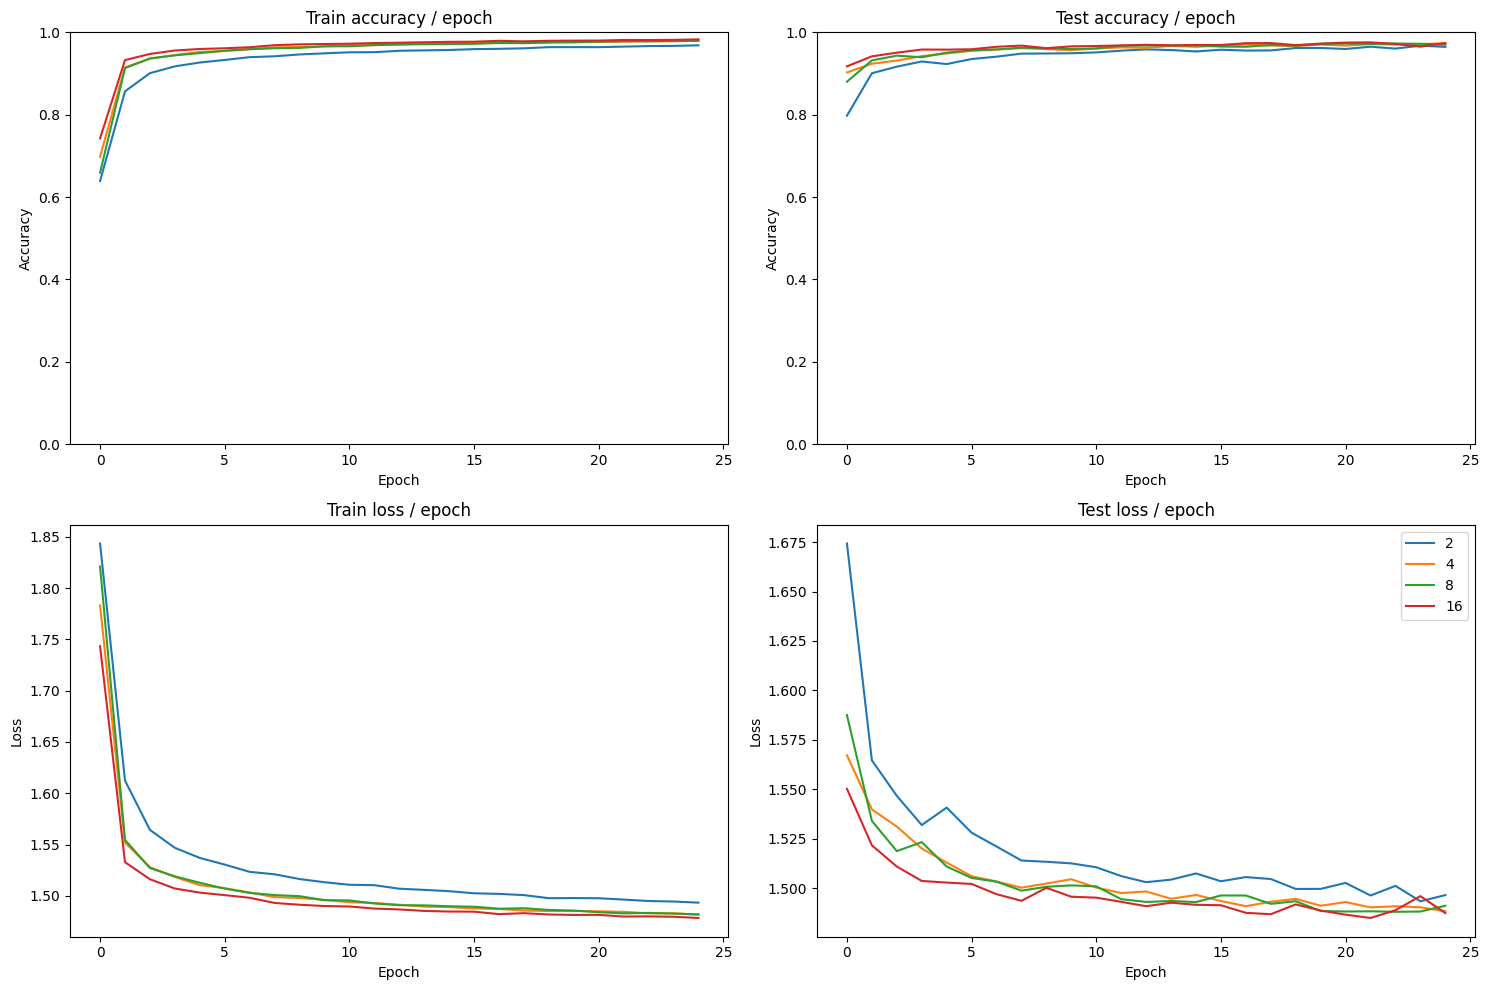

In [24]:
plot_plot_optimizers(plot_optimizers_num_heads, 'num_heads_influence_25')

In [25]:
plot_optimizers_mlp_ratio = {}
for mlp_ratio in [2,4,6,8]:
    stats = main(epochs=25, mlp_ratio=mlp_ratio)
    plot_optimizers_mlp_ratio[mlp_ratio] = stats


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.704 | acc_test 0.916:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.704 | acc_test 0.916:   4%|██▌                                                            | 1/25 [00:06<02:37,  6.55s/it]


acc_train 0.919 | acc_test 0.932:   4%|██▌                                                            | 1/25 [00:13<02:37,  6.55s/it]


acc_train 0.919 | acc_test 0.932:   8%|█████                                                          | 2/25 [00:13<02:32,  6.65s/it]


acc_train 0.936 | acc_test 0.936:   8%|█████                                                          | 2/25 [00:19<02:32,  6.65s/it]


acc_train 0.936 | acc_test 0.936:  12%|███████▌                                                       | 3/25 [00:19<02:23,  6.53s/it]


acc_train 0.944 | acc_test 0.948:  12%|███████▌                                                       | 3/25 [00:26<02:23,  6.53s/it]


acc_train 0.944 | acc_test 0.948:  16%|██████████                                                     | 4/25 [00:26<02:17,  6.53s/it]


acc_train 0.949 | acc_test 0.955:  16%|██████████                                                     | 4/25 [00:32<02:17,  6.53s/it]


acc_train 0.949 | acc_test 0.955:  20%|████████████▌                                                  | 5/25 [00:32<02:09,  6.48s/it]


acc_train 0.954 | acc_test 0.956:  20%|████████████▌                                                  | 5/25 [00:39<02:09,  6.48s/it]


acc_train 0.954 | acc_test 0.956:  24%|███████████████                                                | 6/25 [00:39<02:03,  6.49s/it]


acc_train 0.959 | acc_test 0.963:  24%|███████████████                                                | 6/25 [00:45<02:03,  6.49s/it]


acc_train 0.959 | acc_test 0.963:  28%|█████████████████▋                                             | 7/25 [00:45<01:57,  6.50s/it]


acc_train 0.961 | acc_test 0.964:  28%|█████████████████▋                                             | 7/25 [00:51<01:57,  6.50s/it]


acc_train 0.961 | acc_test 0.964:  32%|████████████████████▏                                          | 8/25 [00:51<01:49,  6.46s/it]


acc_train 0.962 | acc_test 0.961:  32%|████████████████████▏                                          | 8/25 [00:58<01:49,  6.46s/it]


acc_train 0.962 | acc_test 0.961:  36%|██████████████████████▋                                        | 9/25 [00:58<01:42,  6.43s/it]


acc_train 0.966 | acc_test 0.960:  36%|██████████████████████▋                                        | 9/25 [01:04<01:42,  6.43s/it]


acc_train 0.966 | acc_test 0.960:  40%|████████████████████████▊                                     | 10/25 [01:04<01:36,  6.41s/it]


acc_train 0.968 | acc_test 0.967:  40%|████████████████████████▊                                     | 10/25 [01:11<01:36,  6.41s/it]


acc_train 0.968 | acc_test 0.967:  44%|███████████████████████████▎                                  | 11/25 [01:11<01:29,  6.40s/it]


acc_train 0.970 | acc_test 0.966:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:29,  6.40s/it]


acc_train 0.970 | acc_test 0.966:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:23,  6.39s/it]


acc_train 0.970 | acc_test 0.967:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:23,  6.39s/it]


acc_train 0.970 | acc_test 0.967:  52%|████████████████████████████████▏                             | 13/25 [01:23<01:16,  6.38s/it]


acc_train 0.970 | acc_test 0.965:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:16,  6.38s/it]


acc_train 0.970 | acc_test 0.965:  56%|██████████████████████████████████▋                           | 14/25 [01:30<01:10,  6.38s/it]


acc_train 0.972 | acc_test 0.967:  56%|██████████████████████████████████▋                           | 14/25 [01:36<01:10,  6.38s/it]


acc_train 0.972 | acc_test 0.967:  60%|█████████████████████████████████████▏                        | 15/25 [01:36<01:03,  6.37s/it]


acc_train 0.972 | acc_test 0.967:  60%|█████████████████████████████████████▏                        | 15/25 [01:42<01:03,  6.37s/it]


acc_train 0.972 | acc_test 0.967:  64%|███████████████████████████████████████▋                      | 16/25 [01:42<00:57,  6.37s/it]


acc_train 0.974 | acc_test 0.966:  64%|███████████████████████████████████████▋                      | 16/25 [01:49<00:57,  6.37s/it]


acc_train 0.974 | acc_test 0.966:  68%|██████████████████████████████████████████▏                   | 17/25 [01:49<00:50,  6.37s/it]


acc_train 0.974 | acc_test 0.972:  68%|██████████████████████████████████████████▏                   | 17/25 [01:55<00:50,  6.37s/it]


acc_train 0.974 | acc_test 0.972:  72%|████████████████████████████████████████████▋                 | 18/25 [01:55<00:44,  6.38s/it]


acc_train 0.975 | acc_test 0.972:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:44,  6.38s/it]


acc_train 0.975 | acc_test 0.972:  76%|███████████████████████████████████████████████               | 19/25 [02:02<00:38,  6.38s/it]


acc_train 0.977 | acc_test 0.968:  76%|███████████████████████████████████████████████               | 19/25 [02:08<00:38,  6.38s/it]


acc_train 0.977 | acc_test 0.968:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:08<00:32,  6.49s/it]


acc_train 0.977 | acc_test 0.971:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:15<00:32,  6.49s/it]


acc_train 0.977 | acc_test 0.971:  84%|████████████████████████████████████████████████████          | 21/25 [02:15<00:25,  6.46s/it]


acc_train 0.977 | acc_test 0.971:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:25,  6.46s/it]


acc_train 0.977 | acc_test 0.971:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:21<00:19,  6.49s/it]


acc_train 0.977 | acc_test 0.965:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:28<00:19,  6.49s/it]


acc_train 0.977 | acc_test 0.965:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:28<00:12,  6.46s/it]


acc_train 0.979 | acc_test 0.972:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:12,  6.46s/it]


acc_train 0.979 | acc_test 0.972:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:34<00:06,  6.44s/it]


acc_train 0.979 | acc_test 0.973:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:41<00:06,  6.44s/it]


acc_train 0.979 | acc_test 0.973: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.48s/it]


acc_train 0.979 | acc_test 0.973: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.44s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.656 | acc_test 0.874:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.656 | acc_test 0.874:   4%|██▌                                                            | 1/25 [00:06<02:37,  6.56s/it]


acc_train 0.905 | acc_test 0.923:   4%|██▌                                                            | 1/25 [00:12<02:37,  6.56s/it]


acc_train 0.905 | acc_test 0.923:   8%|█████                                                          | 2/25 [00:12<02:28,  6.46s/it]


acc_train 0.927 | acc_test 0.933:   8%|█████                                                          | 2/25 [00:19<02:28,  6.46s/it]


acc_train 0.927 | acc_test 0.933:  12%|███████▌                                                       | 3/25 [00:19<02:22,  6.50s/it]


acc_train 0.938 | acc_test 0.943:  12%|███████▌                                                       | 3/25 [00:25<02:22,  6.50s/it]


acc_train 0.938 | acc_test 0.943:  16%|██████████                                                     | 4/25 [00:25<02:15,  6.45s/it]


acc_train 0.943 | acc_test 0.946:  16%|██████████                                                     | 4/25 [00:32<02:15,  6.45s/it]


acc_train 0.943 | acc_test 0.946:  20%|████████████▌                                                  | 5/25 [00:32<02:09,  6.47s/it]


acc_train 0.948 | acc_test 0.956:  20%|████████████▌                                                  | 5/25 [00:38<02:09,  6.47s/it]


acc_train 0.948 | acc_test 0.956:  24%|███████████████                                                | 6/25 [00:38<02:02,  6.44s/it]


acc_train 0.952 | acc_test 0.952:  24%|███████████████                                                | 6/25 [00:45<02:02,  6.44s/it]


acc_train 0.952 | acc_test 0.952:  28%|█████████████████▋                                             | 7/25 [00:45<01:55,  6.42s/it]


acc_train 0.954 | acc_test 0.960:  28%|█████████████████▋                                             | 7/25 [00:51<01:55,  6.42s/it]


acc_train 0.954 | acc_test 0.960:  32%|████████████████████▏                                          | 8/25 [00:51<01:48,  6.40s/it]


acc_train 0.955 | acc_test 0.950:  32%|████████████████████▏                                          | 8/25 [00:57<01:48,  6.40s/it]


acc_train 0.955 | acc_test 0.950:  36%|██████████████████████▋                                        | 9/25 [00:57<01:42,  6.39s/it]


acc_train 0.958 | acc_test 0.952:  36%|██████████████████████▋                                        | 9/25 [01:04<01:42,  6.39s/it]


acc_train 0.958 | acc_test 0.952:  40%|████████████████████████▊                                     | 10/25 [01:04<01:36,  6.46s/it]


acc_train 0.960 | acc_test 0.958:  40%|████████████████████████▊                                     | 10/25 [01:10<01:36,  6.46s/it]


acc_train 0.960 | acc_test 0.958:  44%|███████████████████████████▎                                  | 11/25 [01:10<01:30,  6.43s/it]


acc_train 0.961 | acc_test 0.957:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:30,  6.43s/it]


acc_train 0.961 | acc_test 0.957:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:23,  6.41s/it]


acc_train 0.963 | acc_test 0.959:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:23,  6.41s/it]


acc_train 0.963 | acc_test 0.959:  52%|████████████████████████████████▏                             | 13/25 [01:23<01:17,  6.45s/it]


acc_train 0.964 | acc_test 0.962:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:17,  6.45s/it]


acc_train 0.964 | acc_test 0.962:  56%|██████████████████████████████████▋                           | 14/25 [01:30<01:10,  6.43s/it]


acc_train 0.965 | acc_test 0.964:  56%|██████████████████████████████████▋                           | 14/25 [01:36<01:10,  6.43s/it]


acc_train 0.965 | acc_test 0.964:  60%|█████████████████████████████████████▏                        | 15/25 [01:36<01:04,  6.46s/it]


acc_train 0.967 | acc_test 0.962:  60%|█████████████████████████████████████▏                        | 15/25 [01:43<01:04,  6.46s/it]


acc_train 0.967 | acc_test 0.962:  64%|███████████████████████████████████████▋                      | 16/25 [01:43<00:58,  6.50s/it]


acc_train 0.968 | acc_test 0.962:  64%|███████████████████████████████████████▋                      | 16/25 [01:49<00:58,  6.50s/it]


acc_train 0.968 | acc_test 0.962:  68%|██████████████████████████████████████████▏                   | 17/25 [01:49<00:51,  6.48s/it]


acc_train 0.969 | acc_test 0.965:  68%|██████████████████████████████████████████▏                   | 17/25 [01:56<00:51,  6.48s/it]


acc_train 0.969 | acc_test 0.965:  72%|████████████████████████████████████████████▋                 | 18/25 [01:56<00:45,  6.46s/it]


acc_train 0.969 | acc_test 0.968:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:45,  6.46s/it]


acc_train 0.969 | acc_test 0.968:  76%|███████████████████████████████████████████████               | 19/25 [02:02<00:38,  6.44s/it]


acc_train 0.970 | acc_test 0.967:  76%|███████████████████████████████████████████████               | 19/25 [02:08<00:38,  6.44s/it]


acc_train 0.970 | acc_test 0.967:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:08<00:32,  6.44s/it]


acc_train 0.972 | acc_test 0.965:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:15<00:32,  6.44s/it]


acc_train 0.972 | acc_test 0.965:  84%|████████████████████████████████████████████████████          | 21/25 [02:15<00:25,  6.43s/it]


acc_train 0.972 | acc_test 0.962:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:25,  6.43s/it]


acc_train 0.972 | acc_test 0.962:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:21<00:19,  6.43s/it]


acc_train 0.974 | acc_test 0.967:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:28<00:19,  6.43s/it]


acc_train 0.974 | acc_test 0.967:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:28<00:12,  6.47s/it]


acc_train 0.974 | acc_test 0.967:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:12,  6.47s/it]


acc_train 0.974 | acc_test 0.967:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:34<00:06,  6.45s/it]


acc_train 0.974 | acc_test 0.965:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:41<00:06,  6.45s/it]


acc_train 0.974 | acc_test 0.965: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.43s/it]


acc_train 0.974 | acc_test 0.965: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.45s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.716 | acc_test 0.904:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.716 | acc_test 0.904:   4%|██▌                                                            | 1/25 [00:06<02:33,  6.40s/it]


acc_train 0.915 | acc_test 0.920:   4%|██▌                                                            | 1/25 [00:12<02:33,  6.40s/it]


acc_train 0.915 | acc_test 0.920:   8%|█████                                                          | 2/25 [00:12<02:27,  6.40s/it]


acc_train 0.930 | acc_test 0.933:   8%|█████                                                          | 2/25 [00:19<02:27,  6.40s/it]


acc_train 0.930 | acc_test 0.933:  12%|███████▌                                                       | 3/25 [00:19<02:20,  6.40s/it]


acc_train 0.941 | acc_test 0.939:  12%|███████▌                                                       | 3/25 [00:25<02:20,  6.40s/it]


acc_train 0.941 | acc_test 0.939:  16%|██████████                                                     | 4/25 [00:25<02:14,  6.40s/it]


acc_train 0.945 | acc_test 0.948:  16%|██████████                                                     | 4/25 [00:32<02:14,  6.40s/it]


acc_train 0.945 | acc_test 0.948:  20%|████████████▌                                                  | 5/25 [00:32<02:08,  6.40s/it]


acc_train 0.950 | acc_test 0.950:  20%|████████████▌                                                  | 5/25 [00:38<02:08,  6.40s/it]


acc_train 0.950 | acc_test 0.950:  24%|███████████████                                                | 6/25 [00:38<02:02,  6.46s/it]


acc_train 0.955 | acc_test 0.958:  24%|███████████████                                                | 6/25 [00:44<02:02,  6.46s/it]


acc_train 0.955 | acc_test 0.958:  28%|█████████████████▋                                             | 7/25 [00:44<01:55,  6.44s/it]


acc_train 0.958 | acc_test 0.961:  28%|█████████████████▋                                             | 7/25 [00:51<01:55,  6.44s/it]


acc_train 0.958 | acc_test 0.961:  32%|████████████████████▏                                          | 8/25 [00:51<01:50,  6.51s/it]


acc_train 0.961 | acc_test 0.958:  32%|████████████████████▏                                          | 8/25 [00:58<01:50,  6.51s/it]


acc_train 0.961 | acc_test 0.958:  36%|██████████████████████▋                                        | 9/25 [00:58<01:43,  6.48s/it]


acc_train 0.962 | acc_test 0.958:  36%|██████████████████████▋                                        | 9/25 [01:04<01:43,  6.48s/it]


acc_train 0.962 | acc_test 0.958:  40%|████████████████████████▊                                     | 10/25 [01:04<01:36,  6.46s/it]


acc_train 0.965 | acc_test 0.960:  40%|████████████████████████▊                                     | 10/25 [01:10<01:36,  6.46s/it]


acc_train 0.965 | acc_test 0.960:  44%|███████████████████████████▎                                  | 11/25 [01:10<01:30,  6.44s/it]


acc_train 0.965 | acc_test 0.961:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:30,  6.44s/it]


acc_train 0.965 | acc_test 0.961:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:23,  6.43s/it]


acc_train 0.967 | acc_test 0.964:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:23,  6.43s/it]


acc_train 0.967 | acc_test 0.964:  52%|████████████████████████████████▏                             | 13/25 [01:23<01:17,  6.43s/it]


acc_train 0.969 | acc_test 0.968:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:17,  6.43s/it]


acc_train 0.969 | acc_test 0.968:  56%|██████████████████████████████████▋                           | 14/25 [01:30<01:10,  6.42s/it]


acc_train 0.970 | acc_test 0.958:  56%|██████████████████████████████████▋                           | 14/25 [01:36<01:10,  6.42s/it]


acc_train 0.970 | acc_test 0.958:  60%|█████████████████████████████████████▏                        | 15/25 [01:36<01:04,  6.41s/it]


acc_train 0.971 | acc_test 0.966:  60%|█████████████████████████████████████▏                        | 15/25 [01:43<01:04,  6.41s/it]


acc_train 0.971 | acc_test 0.966:  64%|███████████████████████████████████████▋                      | 16/25 [01:43<00:57,  6.44s/it]


acc_train 0.972 | acc_test 0.967:  64%|███████████████████████████████████████▋                      | 16/25 [01:49<00:57,  6.44s/it]


acc_train 0.972 | acc_test 0.967:  68%|██████████████████████████████████████████▏                   | 17/25 [01:49<00:51,  6.43s/it]


acc_train 0.972 | acc_test 0.964:  68%|██████████████████████████████████████████▏                   | 17/25 [01:55<00:51,  6.43s/it]


acc_train 0.972 | acc_test 0.964:  72%|████████████████████████████████████████████▋                 | 18/25 [01:55<00:44,  6.42s/it]


acc_train 0.974 | acc_test 0.970:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:44,  6.42s/it]


acc_train 0.974 | acc_test 0.970:  76%|███████████████████████████████████████████████               | 19/25 [02:02<00:38,  6.42s/it]


acc_train 0.974 | acc_test 0.969:  76%|███████████████████████████████████████████████               | 19/25 [02:08<00:38,  6.42s/it]


acc_train 0.974 | acc_test 0.969:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:08<00:32,  6.47s/it]


acc_train 0.974 | acc_test 0.969:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:15<00:32,  6.47s/it]


acc_train 0.974 | acc_test 0.969:  84%|████████████████████████████████████████████████████          | 21/25 [02:15<00:25,  6.50s/it]


acc_train 0.977 | acc_test 0.969:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:25,  6.50s/it]


acc_train 0.977 | acc_test 0.969:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:21<00:19,  6.52s/it]


acc_train 0.976 | acc_test 0.967:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:28<00:19,  6.52s/it]


acc_train 0.976 | acc_test 0.967:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:28<00:12,  6.49s/it]


acc_train 0.977 | acc_test 0.972:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:12,  6.49s/it]


acc_train 0.977 | acc_test 0.972:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:34<00:06,  6.47s/it]


acc_train 0.977 | acc_test 0.968:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:41<00:06,  6.47s/it]


acc_train 0.977 | acc_test 0.968: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.45s/it]


acc_train 0.977 | acc_test 0.968: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:41<00:00,  6.45s/it]


  0%|                                                                                                         | 0/25 [00:00<?, ?it/s]


acc_train 0.703 | acc_test 0.909:   0%|                                                                       | 0/25 [00:06<?, ?it/s]


acc_train 0.703 | acc_test 0.909:   4%|██▌                                                            | 1/25 [00:06<02:34,  6.44s/it]


acc_train 0.919 | acc_test 0.928:   4%|██▌                                                            | 1/25 [00:13<02:34,  6.44s/it]


acc_train 0.919 | acc_test 0.928:   8%|█████                                                          | 2/25 [00:13<02:29,  6.51s/it]


acc_train 0.935 | acc_test 0.938:   8%|█████                                                          | 2/25 [00:19<02:29,  6.51s/it]


acc_train 0.935 | acc_test 0.938:  12%|███████▌                                                       | 3/25 [00:19<02:22,  6.46s/it]


acc_train 0.944 | acc_test 0.944:  12%|███████▌                                                       | 3/25 [00:25<02:22,  6.46s/it]


acc_train 0.944 | acc_test 0.944:  16%|██████████                                                     | 4/25 [00:25<02:15,  6.43s/it]


acc_train 0.949 | acc_test 0.950:  16%|██████████                                                     | 4/25 [00:32<02:15,  6.43s/it]


acc_train 0.949 | acc_test 0.950:  20%|████████████▌                                                  | 5/25 [00:32<02:08,  6.42s/it]


acc_train 0.954 | acc_test 0.951:  20%|████████████▌                                                  | 5/25 [00:38<02:08,  6.42s/it]


acc_train 0.954 | acc_test 0.951:  24%|███████████████                                                | 6/25 [00:38<02:01,  6.42s/it]


acc_train 0.957 | acc_test 0.955:  24%|███████████████                                                | 6/25 [00:45<02:01,  6.42s/it]


acc_train 0.957 | acc_test 0.955:  28%|█████████████████▋                                             | 7/25 [00:45<01:56,  6.47s/it]


acc_train 0.960 | acc_test 0.957:  28%|█████████████████▋                                             | 7/25 [00:51<01:56,  6.47s/it]


acc_train 0.960 | acc_test 0.957:  32%|████████████████████▏                                          | 8/25 [00:51<01:49,  6.45s/it]


acc_train 0.963 | acc_test 0.963:  32%|████████████████████▏                                          | 8/25 [00:57<01:49,  6.45s/it]


acc_train 0.963 | acc_test 0.963:  36%|██████████████████████▋                                        | 9/25 [00:57<01:42,  6.44s/it]


acc_train 0.965 | acc_test 0.963:  36%|██████████████████████▋                                        | 9/25 [01:04<01:42,  6.44s/it]


acc_train 0.965 | acc_test 0.963:  40%|████████████████████████▊                                     | 10/25 [01:04<01:36,  6.43s/it]


acc_train 0.967 | acc_test 0.964:  40%|████████████████████████▊                                     | 10/25 [01:10<01:36,  6.43s/it]


acc_train 0.967 | acc_test 0.964:  44%|███████████████████████████▎                                  | 11/25 [01:10<01:29,  6.42s/it]


acc_train 0.967 | acc_test 0.965:  44%|███████████████████████████▎                                  | 11/25 [01:17<01:29,  6.42s/it]


acc_train 0.967 | acc_test 0.965:  48%|█████████████████████████████▊                                | 12/25 [01:17<01:23,  6.42s/it]


acc_train 0.971 | acc_test 0.962:  48%|█████████████████████████████▊                                | 12/25 [01:23<01:23,  6.42s/it]


acc_train 0.971 | acc_test 0.962:  52%|████████████████████████████████▏                             | 13/25 [01:23<01:16,  6.41s/it]


acc_train 0.971 | acc_test 0.970:  52%|████████████████████████████████▏                             | 13/25 [01:30<01:16,  6.41s/it]


acc_train 0.971 | acc_test 0.970:  56%|██████████████████████████████████▋                           | 14/25 [01:30<01:10,  6.41s/it]


acc_train 0.972 | acc_test 0.969:  56%|██████████████████████████████████▋                           | 14/25 [01:36<01:10,  6.41s/it]


acc_train 0.972 | acc_test 0.969:  60%|█████████████████████████████████████▏                        | 15/25 [01:36<01:04,  6.41s/it]


acc_train 0.972 | acc_test 0.968:  60%|█████████████████████████████████████▏                        | 15/25 [01:42<01:04,  6.41s/it]


acc_train 0.972 | acc_test 0.968:  64%|███████████████████████████████████████▋                      | 16/25 [01:42<00:57,  6.41s/it]


acc_train 0.974 | acc_test 0.970:  64%|███████████████████████████████████████▋                      | 16/25 [01:49<00:57,  6.41s/it]


acc_train 0.974 | acc_test 0.970:  68%|██████████████████████████████████████████▏                   | 17/25 [01:49<00:51,  6.41s/it]


acc_train 0.975 | acc_test 0.970:  68%|██████████████████████████████████████████▏                   | 17/25 [01:55<00:51,  6.41s/it]


acc_train 0.975 | acc_test 0.970:  72%|████████████████████████████████████████████▋                 | 18/25 [01:55<00:44,  6.41s/it]


acc_train 0.976 | acc_test 0.966:  72%|████████████████████████████████████████████▋                 | 18/25 [02:02<00:44,  6.41s/it]


acc_train 0.976 | acc_test 0.966:  76%|███████████████████████████████████████████████               | 19/25 [02:02<00:38,  6.43s/it]


acc_train 0.975 | acc_test 0.971:  76%|███████████████████████████████████████████████               | 19/25 [02:08<00:38,  6.43s/it]


acc_train 0.975 | acc_test 0.971:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:08<00:32,  6.41s/it]


acc_train 0.977 | acc_test 0.973:  80%|█████████████████████████████████████████████████▌            | 20/25 [02:14<00:32,  6.41s/it]


acc_train 0.977 | acc_test 0.973:  84%|████████████████████████████████████████████████████          | 21/25 [02:14<00:25,  6.40s/it]


acc_train 0.977 | acc_test 0.969:  84%|████████████████████████████████████████████████████          | 21/25 [02:21<00:25,  6.40s/it]


acc_train 0.977 | acc_test 0.969:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:21<00:19,  6.39s/it]


acc_train 0.978 | acc_test 0.972:  88%|██████████████████████████████████████████████████████▌       | 22/25 [02:27<00:19,  6.39s/it]


acc_train 0.978 | acc_test 0.972:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:27<00:12,  6.39s/it]


acc_train 0.979 | acc_test 0.974:  92%|█████████████████████████████████████████████████████████     | 23/25 [02:34<00:12,  6.39s/it]


acc_train 0.979 | acc_test 0.974:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:34<00:06,  6.38s/it]


acc_train 0.979 | acc_test 0.973:  96%|███████████████████████████████████████████████████████████▌  | 24/25 [02:40<00:06,  6.38s/it]


acc_train 0.979 | acc_test 0.973: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:40<00:00,  6.38s/it]


acc_train 0.979 | acc_test 0.973: 100%|██████████████████████████████████████████████████████████████| 25/25 [02:40<00:00,  6.42s/it]

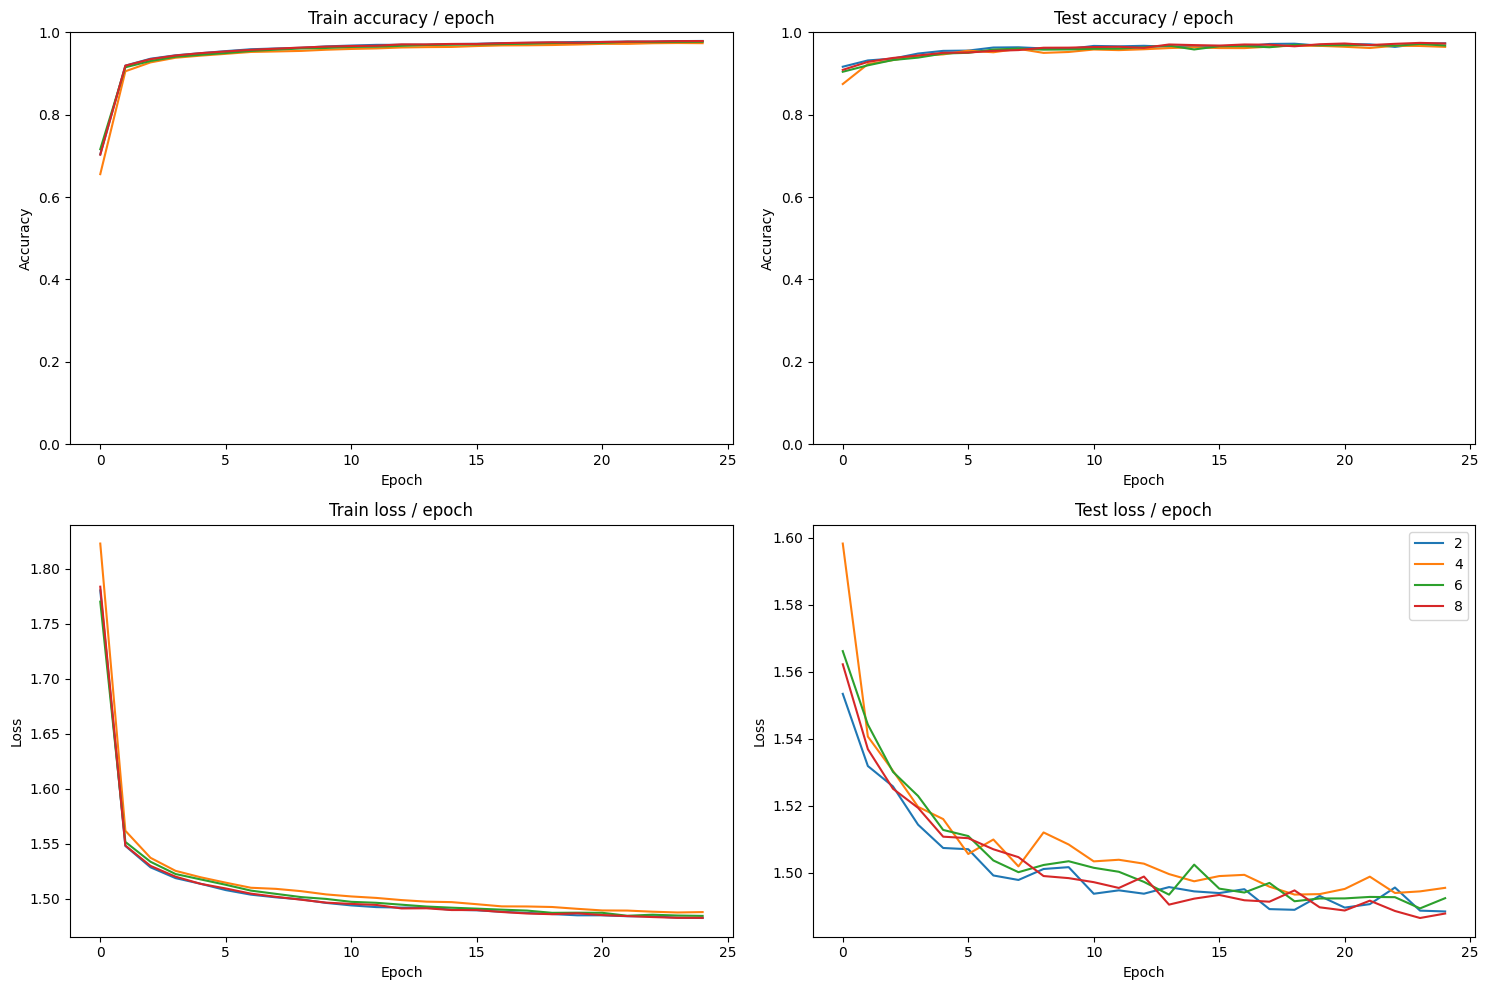

In [26]:
plot_plot_optimizers(plot_optimizers_mlp_ratio, 'mlp_ratio_influence_25')

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [27]:
%pip install timm > /dev/null

Note: you may need to restart the kernel to use updated packages.


a) Load the model using the timm library without pretrained weights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [28]:
import timm
# [k for k in timm.list_models() if 'vit_base' in k]

In [29]:
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
try:
    model(torch.randn(1, 1, 28, 28))
except AssertionError as err:
    print(err)

Input height (28) doesn't match model (224).


The model vit_base_patch16_224 is trained on 224x224 images from the ImageNet dataset. In the first layer of the ViT, the input image is divided into fixed-size patches to create embedded vectors. It's crucial to maintain the same image size as the one the model was designed for. 

In this case, it necessitates resizing the images to 224x224 RGB pixels. However, this may not be ideal as resizing could distort the images and potentially affect the model's performance.

In [30]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 8, 8) # adapt number of channels to fit in ViT 
# by coping the image and not resizing yet (see next cell)
display(x.size())
model(x).shape

torch.Size([32, 3, 224, 224])

torch.Size([32, 10])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [31]:
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
data_cfg # figure out which transformations were used for a given pretrained model

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [32]:
transform = timm.data.create_transform(**data_cfg)
transform_rgb = lambda x: transform(x.convert('RGB'))

In [33]:
model.cuda()
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform_rgb)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform_rgb)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=64)

c) redo the training with the pretrained ViT-S




In [34]:
stats_vit = main(model=model, epochs=15, tqdm_batch=True)


  0%|                                                                                                        | 0/938 [00:00<?, ?it/s]


  0%|                                                                                                         | 0/15 [00:00<?, ?it/s]


  0%|                                                                                                | 1/938 [00:00<09:00,  1.73it/s]


  0%|▏                                                                                               | 2/938 [00:01<08:43,  1.79it/s]


  0%|▎                                                                                               | 3/938 [00:01<08:38,  1.80it/s]


  0%|▍                                                                                               | 4/938 [00:02<08:34,  1.81it/s]


  1%|▌                                                                                               | 5/938 [00:02<08:32,  1.82it/s]


  1%|▌                                                                                               | 6/938 [00:03<08:30,  1.82it/s]


  1%|▋                                                                                               | 7/938 [00:03<08:29,  1.83it/s]


  1%|▊                                                                                               | 8/938 [00:04<08:28,  1.83it/s]


  1%|▉                                                                                               | 9/938 [00:04<08:33,  1.81it/s]


  1%|█                                                                                              | 10/938 [00:05<08:32,  1.81it/s]


  1%|█                                                                                              | 11/938 [00:06<08:30,  1.82it/s]


  1%|█▏                                                                                             | 12/938 [00:06<08:28,  1.82it/s]


  1%|█▎                                                                                             | 13/938 [00:07<08:26,  1.83it/s]


  1%|█▍                                                                                             | 14/938 [00:07<08:25,  1.83it/s]


  2%|█▌                                                                                             | 15/938 [00:08<08:24,  1.83it/s]


  2%|█▌                                                                                             | 16/938 [00:08<08:23,  1.83it/s]


  2%|█▋                                                                                             | 17/938 [00:09<08:22,  1.83it/s]


  2%|█▊                                                                                             | 18/938 [00:09<08:21,  1.83it/s]


  2%|█▉                                                                                             | 19/938 [00:10<08:21,  1.83it/s]


  2%|██                                                                                             | 20/938 [00:10<08:20,  1.83it/s]


  2%|██▏                                                                                            | 21/938 [00:11<08:20,  1.83it/s]


  2%|██▏                                                                                            | 22/938 [00:12<08:19,  1.83it/s]


  2%|██▎                                                                                            | 23/938 [00:12<08:19,  1.83it/s]


  3%|██▍                                                                                            | 24/938 [00:13<08:18,  1.83it/s]


  3%|██▌                                                                                            | 25/938 [00:13<08:17,  1.83it/s]


  3%|██▋                                                                                            | 26/938 [00:14<08:17,  1.83it/s]


  3%|██▋                                                                                            | 27/938 [00:14<08:17,  1.83it/s]


  3%|██▊                                                                                            | 28/938 [00:15<08:16,  1.83it/s]


  3%|██▉                                                                                            | 29/938 [00:15<08:16,  1.83it/s]


  3%|███                                                                                            | 30/938 [00:16<08:16,  1.83it/s]


  3%|███▏                                                                                           | 31/938 [00:16<08:15,  1.83it/s]


  3%|███▏                                                                                           | 32/938 [00:17<08:15,  1.83it/s]


  4%|███▎                                                                                           | 33/938 [00:18<08:14,  1.83it/s]


  4%|███▍                                                                                           | 34/938 [00:18<08:14,  1.83it/s]


  4%|███▌                                                                                           | 35/938 [00:19<08:14,  1.83it/s]


  4%|███▋                                                                                           | 36/938 [00:19<08:14,  1.83it/s]


  4%|███▋                                                                                           | 37/938 [00:20<08:14,  1.82it/s]


  4%|███▊                                                                                           | 38/938 [00:20<08:13,  1.82it/s]


  4%|███▉                                                                                           | 39/938 [00:21<08:18,  1.80it/s]


  4%|████                                                                                           | 40/938 [00:21<08:16,  1.81it/s]


  4%|████▏                                                                                          | 41/938 [00:22<08:15,  1.81it/s]


  4%|████▎                                                                                          | 42/938 [00:23<08:14,  1.81it/s]


  5%|████▎                                                                                          | 43/938 [00:23<08:13,  1.81it/s]


  5%|████▍                                                                                          | 44/938 [00:24<08:12,  1.82it/s]


  5%|████▌                                                                                          | 45/938 [00:24<08:11,  1.82it/s]


  5%|████▋                                                                                          | 46/938 [00:25<08:10,  1.82it/s]


  5%|████▊                                                                                          | 47/938 [00:25<08:09,  1.82it/s]


  5%|████▊                                                                                          | 48/938 [00:26<08:09,  1.82it/s]


  5%|████▉                                                                                          | 49/938 [00:26<08:09,  1.82it/s]


  5%|█████                                                                                          | 50/938 [00:27<08:08,  1.82it/s]


  5%|█████▏                                                                                         | 51/938 [00:27<08:08,  1.82it/s]


  6%|█████▎                                                                                         | 52/938 [00:28<08:06,  1.82it/s]


  6%|█████▎                                                                                         | 53/938 [00:29<08:06,  1.82it/s]


  6%|█████▍                                                                                         | 54/938 [00:29<08:05,  1.82it/s]


  6%|█████▌                                                                                         | 55/938 [00:30<08:05,  1.82it/s]


  6%|█████▋                                                                                         | 56/938 [00:30<08:04,  1.82it/s]


  6%|█████▊                                                                                         | 57/938 [00:31<08:04,  1.82it/s]


  6%|█████▊                                                                                         | 58/938 [00:31<08:03,  1.82it/s]


  6%|█████▉                                                                                         | 59/938 [00:32<08:03,  1.82it/s]


  6%|██████                                                                                         | 60/938 [00:32<08:02,  1.82it/s]


  7%|██████▏                                                                                        | 61/938 [00:33<08:02,  1.82it/s]


  7%|██████▎                                                                                        | 62/938 [00:34<08:01,  1.82it/s]


  7%|██████▍                                                                                        | 63/938 [00:34<08:01,  1.82it/s]


  7%|██████▍                                                                                        | 64/938 [00:35<08:00,  1.82it/s]


  7%|██████▌                                                                                        | 65/938 [00:35<08:00,  1.82it/s]


  7%|██████▋                                                                                        | 66/938 [00:36<07:59,  1.82it/s]


  7%|██████▊                                                                                        | 67/938 [00:36<07:59,  1.82it/s]


  7%|██████▉                                                                                        | 68/938 [00:37<07:58,  1.82it/s]


  7%|██████▉                                                                                        | 69/938 [00:37<07:58,  1.82it/s]


  7%|███████                                                                                        | 70/938 [00:38<07:57,  1.82it/s]


  8%|███████▏                                                                                       | 71/938 [00:38<07:57,  1.81it/s]


  8%|███████▎                                                                                       | 72/938 [00:39<07:57,  1.81it/s]


  8%|███████▍                                                                                       | 73/938 [00:40<07:57,  1.81it/s]


  8%|███████▍                                                                                       | 74/938 [00:40<07:56,  1.81it/s]


  8%|███████▌                                                                                       | 75/938 [00:41<07:56,  1.81it/s]


  8%|███████▋                                                                                       | 76/938 [00:41<07:55,  1.81it/s]


  8%|███████▊                                                                                       | 77/938 [00:42<07:55,  1.81it/s]


  8%|███████▉                                                                                       | 78/938 [00:42<07:54,  1.81it/s]


  8%|████████                                                                                       | 79/938 [00:43<07:54,  1.81it/s]


  9%|████████                                                                                       | 80/938 [00:43<07:53,  1.81it/s]


  9%|████████▏                                                                                      | 81/938 [00:44<07:52,  1.81it/s]


  9%|████████▎                                                                                      | 82/938 [00:45<07:52,  1.81it/s]


  9%|████████▍                                                                                      | 83/938 [00:45<07:51,  1.81it/s]


  9%|████████▌                                                                                      | 84/938 [00:46<07:51,  1.81it/s]


  9%|████████▌                                                                                      | 85/938 [00:46<07:50,  1.81it/s]


  9%|████████▋                                                                                      | 86/938 [00:47<07:50,  1.81it/s]


  9%|████████▊                                                                                      | 87/938 [00:47<07:49,  1.81it/s]


  9%|████████▉                                                                                      | 88/938 [00:48<07:49,  1.81it/s]


  9%|█████████                                                                                      | 89/938 [00:48<07:48,  1.81it/s]


 10%|█████████                                                                                      | 90/938 [00:49<07:47,  1.81it/s]


 10%|█████████▏                                                                                     | 91/938 [00:50<07:47,  1.81it/s]


 10%|█████████▎                                                                                     | 92/938 [00:50<07:47,  1.81it/s]


 10%|█████████▍                                                                                     | 93/938 [00:51<07:46,  1.81it/s]


 10%|█████████▌                                                                                     | 94/938 [00:51<07:46,  1.81it/s]


 10%|█████████▌                                                                                     | 95/938 [00:52<07:45,  1.81it/s]


 10%|█████████▋                                                                                     | 96/938 [00:52<07:45,  1.81it/s]


 10%|█████████▊                                                                                     | 97/938 [00:53<07:44,  1.81it/s]


 10%|█████████▉                                                                                     | 98/938 [00:53<07:44,  1.81it/s]


 11%|██████████                                                                                     | 99/938 [00:54<07:43,  1.81it/s]


 11%|██████████                                                                                    | 100/938 [00:55<07:43,  1.81it/s]


 11%|██████████                                                                                    | 101/938 [00:55<07:43,  1.81it/s]


 11%|██████████▏                                                                                   | 102/938 [00:56<07:42,  1.81it/s]


 11%|██████████▎                                                                                   | 103/938 [00:56<07:42,  1.81it/s]


 11%|██████████▍                                                                                   | 104/938 [00:57<07:41,  1.81it/s]


 11%|██████████▌                                                                                   | 105/938 [00:57<07:40,  1.81it/s]


 11%|██████████▌                                                                                   | 106/938 [00:58<07:40,  1.81it/s]


 11%|██████████▋                                                                                   | 107/938 [00:58<07:39,  1.81it/s]


 12%|██████████▊                                                                                   | 108/938 [00:59<07:39,  1.81it/s]


 12%|██████████▉                                                                                   | 109/938 [00:59<07:38,  1.81it/s]


 12%|███████████                                                                                   | 110/938 [01:00<07:38,  1.81it/s]


 12%|███████████                                                                                   | 111/938 [01:01<07:37,  1.81it/s]


 12%|███████████▏                                                                                  | 112/938 [01:01<07:36,  1.81it/s]


 12%|███████████▎                                                                                  | 113/938 [01:02<07:36,  1.81it/s]


 12%|███████████▍                                                                                  | 114/938 [01:02<07:35,  1.81it/s]


 12%|███████████▌                                                                                  | 115/938 [01:03<07:42,  1.78it/s]


 12%|███████████▌                                                                                  | 116/938 [01:03<07:40,  1.79it/s]


 12%|███████████▋                                                                                  | 117/938 [01:04<07:38,  1.79it/s]


 13%|███████████▊                                                                                  | 118/938 [01:04<07:36,  1.79it/s]


 13%|███████████▉                                                                                  | 119/938 [01:05<07:36,  1.80it/s]


 13%|████████████                                                                                  | 120/938 [01:06<07:35,  1.80it/s]


 13%|████████████▏                                                                                 | 121/938 [01:06<07:34,  1.80it/s]


 13%|████████████▏                                                                                 | 122/938 [01:07<07:33,  1.80it/s]


 13%|████████████▎                                                                                 | 123/938 [01:07<07:33,  1.80it/s]


 13%|████████████▍                                                                                 | 124/938 [01:08<07:32,  1.80it/s]


 13%|████████████▌                                                                                 | 125/938 [01:08<07:31,  1.80it/s]


 13%|████████████▋                                                                                 | 126/938 [01:09<07:31,  1.80it/s]


 14%|████████████▋                                                                                 | 127/938 [01:09<07:30,  1.80it/s]


 14%|████████████▊                                                                                 | 128/938 [01:10<07:29,  1.80it/s]


 14%|████████████▉                                                                                 | 129/938 [01:11<07:29,  1.80it/s]


 14%|█████████████                                                                                 | 130/938 [01:11<07:28,  1.80it/s]


 14%|█████████████▏                                                                                | 131/938 [01:12<07:27,  1.80it/s]


 14%|█████████████▏                                                                                | 132/938 [01:12<07:27,  1.80it/s]


 14%|█████████████▎                                                                                | 133/938 [01:13<07:26,  1.80it/s]


 14%|█████████████▍                                                                                | 134/938 [01:13<07:26,  1.80it/s]


 14%|█████████████▌                                                                                | 135/938 [01:14<07:25,  1.80it/s]


 14%|█████████████▋                                                                                | 136/938 [01:14<07:25,  1.80it/s]


 15%|█████████████▋                                                                                | 137/938 [01:15<07:24,  1.80it/s]


 15%|█████████████▊                                                                                | 138/938 [01:16<07:24,  1.80it/s]


 15%|█████████████▉                                                                                | 139/938 [01:16<07:25,  1.79it/s]


 15%|██████████████                                                                                | 140/938 [01:17<07:24,  1.80it/s]


 15%|██████████████▏                                                                               | 141/938 [01:17<07:23,  1.80it/s]


 15%|██████████████▏                                                                               | 142/938 [01:18<07:22,  1.80it/s]


 15%|██████████████▎                                                                               | 143/938 [01:18<07:21,  1.80it/s]


 15%|██████████████▍                                                                               | 144/938 [01:19<07:20,  1.80it/s]


 15%|██████████████▌                                                                               | 145/938 [01:19<07:20,  1.80it/s]


 16%|██████████████▋                                                                               | 146/938 [01:20<07:19,  1.80it/s]


 16%|██████████████▋                                                                               | 147/938 [01:21<07:18,  1.80it/s]


 16%|██████████████▊                                                                               | 148/938 [01:21<07:17,  1.80it/s]


 16%|██████████████▉                                                                               | 149/938 [01:22<07:17,  1.80it/s]


 16%|███████████████                                                                               | 150/938 [01:22<07:16,  1.81it/s]


 16%|███████████████▏                                                                              | 151/938 [01:23<07:15,  1.81it/s]


 16%|███████████████▏                                                                              | 152/938 [01:23<07:15,  1.81it/s]


 16%|███████████████▎                                                                              | 153/938 [01:24<07:14,  1.81it/s]


 16%|███████████████▍                                                                              | 154/938 [01:24<07:13,  1.81it/s]


 17%|███████████████▌                                                                              | 155/938 [01:25<07:13,  1.81it/s]


 17%|███████████████▋                                                                              | 156/938 [01:26<07:12,  1.81it/s]


 17%|███████████████▋                                                                              | 157/938 [01:26<07:12,  1.81it/s]


 17%|███████████████▊                                                                              | 158/938 [01:27<07:11,  1.81it/s]


 17%|███████████████▉                                                                              | 159/938 [01:27<07:10,  1.81it/s]


 17%|████████████████                                                                              | 160/938 [01:28<07:10,  1.81it/s]


 17%|████████████████▏                                                                             | 161/938 [01:28<07:09,  1.81it/s]


 17%|████████████████▏                                                                             | 162/938 [01:29<07:09,  1.81it/s]


 17%|████████████████▎                                                                             | 163/938 [01:29<07:08,  1.81it/s]


 17%|████████████████▍                                                                             | 164/938 [01:30<07:08,  1.81it/s]


 18%|████████████████▌                                                                             | 165/938 [01:31<07:07,  1.81it/s]


 18%|████████████████▋                                                                             | 166/938 [01:31<07:06,  1.81it/s]


 18%|████████████████▋                                                                             | 167/938 [01:32<07:06,  1.81it/s]


 18%|████████████████▊                                                                             | 168/938 [01:32<07:05,  1.81it/s]


 18%|████████████████▉                                                                             | 169/938 [01:33<07:05,  1.81it/s]


 18%|█████████████████                                                                             | 170/938 [01:33<07:04,  1.81it/s]


 18%|█████████████████▏                                                                            | 171/938 [01:34<07:04,  1.81it/s]


 18%|█████████████████▏                                                                            | 172/938 [01:34<07:04,  1.80it/s]


 18%|█████████████████▎                                                                            | 173/938 [01:35<07:03,  1.81it/s]


 19%|█████████████████▍                                                                            | 174/938 [01:36<07:02,  1.81it/s]


 19%|█████████████████▌                                                                            | 175/938 [01:36<07:01,  1.81it/s]


 19%|█████████████████▋                                                                            | 176/938 [01:37<07:00,  1.81it/s]


 19%|█████████████████▋                                                                            | 177/938 [01:37<07:00,  1.81it/s]


 19%|█████████████████▊                                                                            | 178/938 [01:38<07:00,  1.81it/s]


 19%|█████████████████▉                                                                            | 179/938 [01:38<06:59,  1.81it/s]


 19%|██████████████████                                                                            | 180/938 [01:39<06:59,  1.81it/s]


 19%|██████████████████▏                                                                           | 181/938 [01:39<06:58,  1.81it/s]


 19%|██████████████████▏                                                                           | 182/938 [01:40<06:58,  1.81it/s]


 20%|██████████████████▎                                                                           | 183/938 [01:41<06:57,  1.81it/s]


 20%|██████████████████▍                                                                           | 184/938 [01:41<06:57,  1.81it/s]


 20%|██████████████████▌                                                                           | 185/938 [01:42<06:56,  1.81it/s]


 20%|██████████████████▋                                                                           | 186/938 [01:42<06:55,  1.81it/s]


 20%|██████████████████▋                                                                           | 187/938 [01:43<06:55,  1.81it/s]


 20%|██████████████████▊                                                                           | 188/938 [01:43<06:55,  1.81it/s]


 20%|██████████████████▉                                                                           | 189/938 [01:44<06:54,  1.81it/s]


 20%|███████████████████                                                                           | 190/938 [01:44<06:56,  1.79it/s]


 20%|███████████████████▏                                                                          | 191/938 [01:45<06:55,  1.80it/s]


 20%|███████████████████▏                                                                          | 192/938 [01:46<06:53,  1.80it/s]


 21%|███████████████████▎                                                                          | 193/938 [01:46<06:52,  1.81it/s]


 21%|███████████████████▍                                                                          | 194/938 [01:47<06:51,  1.81it/s]


 21%|███████████████████▌                                                                          | 195/938 [01:47<06:52,  1.80it/s]


 21%|███████████████████▋                                                                          | 196/938 [01:48<06:50,  1.81it/s]


 21%|███████████████████▋                                                                          | 197/938 [01:48<06:49,  1.81it/s]


 21%|███████████████████▊                                                                          | 198/938 [01:49<06:48,  1.81it/s]


 21%|███████████████████▉                                                                          | 199/938 [01:49<06:47,  1.81it/s]


 21%|████████████████████                                                                          | 200/938 [01:50<06:46,  1.81it/s]


 21%|████████████████████▏                                                                         | 201/938 [01:50<06:49,  1.80it/s]


 22%|████████████████████▏                                                                         | 202/938 [01:51<06:47,  1.81it/s]


 22%|████████████████████▎                                                                         | 203/938 [01:52<06:47,  1.80it/s]


 22%|████████████████████▍                                                                         | 204/938 [01:52<06:49,  1.79it/s]


 22%|████████████████████▌                                                                         | 205/938 [01:53<06:50,  1.78it/s]


 22%|████████████████████▋                                                                         | 206/938 [01:53<06:50,  1.78it/s]


 22%|████████████████████▋                                                                         | 207/938 [01:54<06:50,  1.78it/s]


 22%|████████████████████▊                                                                         | 208/938 [01:54<06:50,  1.78it/s]


 22%|████████████████████▉                                                                         | 209/938 [01:55<06:50,  1.78it/s]


 22%|█████████████████████                                                                         | 210/938 [01:56<06:50,  1.77it/s]


 22%|█████████████████████▏                                                                        | 211/938 [01:56<06:49,  1.78it/s]


 23%|█████████████████████▏                                                                        | 212/938 [01:57<06:48,  1.78it/s]


 23%|█████████████████████▎                                                                        | 213/938 [01:57<06:48,  1.78it/s]


 23%|█████████████████████▍                                                                        | 214/938 [01:58<06:48,  1.77it/s]


 23%|█████████████████████▌                                                                        | 215/938 [01:58<06:47,  1.77it/s]


 23%|█████████████████████▋                                                                        | 216/938 [01:59<06:46,  1.77it/s]


 23%|█████████████████████▋                                                                        | 217/938 [01:59<06:46,  1.77it/s]


 23%|█████████████████████▊                                                                        | 218/938 [02:00<06:45,  1.77it/s]


 23%|█████████████████████▉                                                                        | 219/938 [02:01<06:45,  1.77it/s]


 23%|██████████████████████                                                                        | 220/938 [02:01<06:45,  1.77it/s]


 24%|██████████████████████▏                                                                       | 221/938 [02:02<06:44,  1.77it/s]


 24%|██████████████████████▏                                                                       | 222/938 [02:02<06:43,  1.77it/s]


 24%|██████████████████████▎                                                                       | 223/938 [02:03<06:43,  1.77it/s]


 24%|██████████████████████▍                                                                       | 224/938 [02:03<06:39,  1.79it/s]


 24%|██████████████████████▌                                                                       | 225/938 [02:04<06:37,  1.79it/s]


 24%|██████████████████████▋                                                                       | 226/938 [02:05<06:34,  1.80it/s]


 24%|██████████████████████▋                                                                       | 227/938 [02:05<06:33,  1.81it/s]


 24%|██████████████████████▊                                                                       | 228/938 [02:06<06:32,  1.81it/s]


 24%|██████████████████████▉                                                                       | 229/938 [02:06<06:31,  1.81it/s]


 25%|███████████████████████                                                                       | 230/938 [02:07<06:30,  1.82it/s]


 25%|███████████████████████▏                                                                      | 231/938 [02:07<06:29,  1.81it/s]


 25%|███████████████████████▏                                                                      | 232/938 [02:08<06:28,  1.82it/s]


 25%|███████████████████████▎                                                                      | 233/938 [02:08<06:27,  1.82it/s]


 25%|███████████████████████▍                                                                      | 234/938 [02:09<06:26,  1.82it/s]


 25%|███████████████████████▌                                                                      | 235/938 [02:09<06:26,  1.82it/s]


 25%|███████████████████████▋                                                                      | 236/938 [02:10<06:25,  1.82it/s]


 25%|███████████████████████▊                                                                      | 237/938 [02:11<06:25,  1.82it/s]


 25%|███████████████████████▊                                                                      | 238/938 [02:11<06:24,  1.82it/s]


 25%|███████████████████████▉                                                                      | 239/938 [02:12<06:24,  1.82it/s]


 26%|████████████████████████                                                                      | 240/938 [02:12<06:23,  1.82it/s]


 26%|████████████████████████▏                                                                     | 241/938 [02:13<06:23,  1.82it/s]


 26%|████████████████████████▎                                                                     | 242/938 [02:13<06:22,  1.82it/s]


 26%|████████████████████████▎                                                                     | 243/938 [02:14<06:21,  1.82it/s]


 26%|████████████████████████▍                                                                     | 244/938 [02:14<06:24,  1.80it/s]


 26%|████████████████████████▌                                                                     | 245/938 [02:15<06:26,  1.79it/s]


 26%|████████████████████████▋                                                                     | 246/938 [02:16<06:27,  1.79it/s]


 26%|████████████████████████▊                                                                     | 247/938 [02:16<06:27,  1.78it/s]


 26%|████████████████████████▊                                                                     | 248/938 [02:17<06:28,  1.78it/s]


 27%|████████████████████████▉                                                                     | 249/938 [02:17<06:27,  1.78it/s]


 27%|█████████████████████████                                                                     | 250/938 [02:18<06:27,  1.77it/s]


 27%|█████████████████████████▏                                                                    | 251/938 [02:18<06:27,  1.77it/s]


 27%|█████████████████████████▎                                                                    | 252/938 [02:19<06:27,  1.77it/s]


 27%|█████████████████████████▎                                                                    | 253/938 [02:20<06:26,  1.77it/s]


 27%|█████████████████████████▍                                                                    | 254/938 [02:20<06:26,  1.77it/s]


 27%|█████████████████████████▌                                                                    | 255/938 [02:21<06:26,  1.77it/s]


 27%|█████████████████████████▋                                                                    | 256/938 [02:21<06:25,  1.77it/s]


 27%|█████████████████████████▊                                                                    | 257/938 [02:22<06:24,  1.77it/s]


 28%|█████████████████████████▊                                                                    | 258/938 [02:22<06:24,  1.77it/s]


 28%|█████████████████████████▉                                                                    | 259/938 [02:23<06:23,  1.77it/s]


 28%|██████████████████████████                                                                    | 260/938 [02:23<06:23,  1.77it/s]


 28%|██████████████████████████▏                                                                   | 261/938 [02:24<06:22,  1.77it/s]


 28%|██████████████████████████▎                                                                   | 262/938 [02:25<06:21,  1.77it/s]


 28%|██████████████████████████▎                                                                   | 263/938 [02:25<06:21,  1.77it/s]


 28%|██████████████████████████▍                                                                   | 264/938 [02:26<06:20,  1.77it/s]


 28%|██████████████████████████▌                                                                   | 265/938 [02:26<06:19,  1.77it/s]


 28%|██████████████████████████▋                                                                   | 266/938 [02:27<06:19,  1.77it/s]


 28%|██████████████████████████▊                                                                   | 267/938 [02:27<06:19,  1.77it/s]


 29%|██████████████████████████▊                                                                   | 268/938 [02:28<06:18,  1.77it/s]


 29%|██████████████████████████▉                                                                   | 269/938 [02:29<06:17,  1.77it/s]


 29%|███████████████████████████                                                                   | 270/938 [02:29<06:17,  1.77it/s]


 29%|███████████████████████████▏                                                                  | 271/938 [02:30<06:16,  1.77it/s]


 29%|███████████████████████████▎                                                                  | 272/938 [02:30<06:16,  1.77it/s]


 29%|███████████████████████████▎                                                                  | 273/938 [02:31<06:15,  1.77it/s]


 29%|███████████████████████████▍                                                                  | 274/938 [02:31<06:14,  1.77it/s]


 29%|███████████████████████████▌                                                                  | 275/938 [02:32<06:14,  1.77it/s]


 29%|███████████████████████████▋                                                                  | 276/938 [02:33<06:14,  1.77it/s]


 30%|███████████████████████████▊                                                                  | 277/938 [02:33<06:13,  1.77it/s]


 30%|███████████████████████████▊                                                                  | 278/938 [02:34<06:12,  1.77it/s]


 30%|███████████████████████████▉                                                                  | 279/938 [02:34<06:11,  1.77it/s]


 30%|████████████████████████████                                                                  | 280/938 [02:35<06:11,  1.77it/s]


 30%|████████████████████████████▏                                                                 | 281/938 [02:35<06:10,  1.77it/s]


 30%|████████████████████████████▎                                                                 | 282/938 [02:36<06:10,  1.77it/s]


 30%|████████████████████████████▎                                                                 | 283/938 [02:36<06:09,  1.77it/s]


 30%|████████████████████████████▍                                                                 | 284/938 [02:37<06:09,  1.77it/s]


 30%|████████████████████████████▌                                                                 | 285/938 [02:38<06:08,  1.77it/s]


 30%|████████████████████████████▋                                                                 | 286/938 [02:38<06:07,  1.77it/s]


 31%|████████████████████████████▊                                                                 | 287/938 [02:39<06:07,  1.77it/s]


 31%|████████████████████████████▊                                                                 | 288/938 [02:39<06:06,  1.77it/s]


 31%|████████████████████████████▉                                                                 | 289/938 [02:40<06:06,  1.77it/s]


 31%|█████████████████████████████                                                                 | 290/938 [02:40<06:05,  1.77it/s]


 31%|█████████████████████████████▏                                                                | 291/938 [02:41<06:05,  1.77it/s]


 31%|█████████████████████████████▎                                                                | 292/938 [02:42<06:04,  1.77it/s]


 31%|█████████████████████████████▎                                                                | 293/938 [02:42<06:04,  1.77it/s]


 31%|█████████████████████████████▍                                                                | 294/938 [02:43<06:03,  1.77it/s]


 31%|█████████████████████████████▌                                                                | 295/938 [02:43<06:03,  1.77it/s]


 32%|█████████████████████████████▋                                                                | 296/938 [02:44<06:02,  1.77it/s]


 32%|█████████████████████████████▊                                                                | 297/938 [02:44<06:02,  1.77it/s]


 32%|█████████████████████████████▊                                                                | 298/938 [02:45<06:01,  1.77it/s]


 32%|█████████████████████████████▉                                                                | 299/938 [02:45<06:00,  1.77it/s]


 32%|██████████████████████████████                                                                | 300/938 [02:46<06:00,  1.77it/s]


 32%|██████████████████████████████▏                                                               | 301/938 [02:47<05:59,  1.77it/s]


 32%|██████████████████████████████▎                                                               | 302/938 [02:47<05:58,  1.77it/s]


 32%|██████████████████████████████▎                                                               | 303/938 [02:48<05:58,  1.77it/s]


 32%|██████████████████████████████▍                                                               | 304/938 [02:48<05:57,  1.77it/s]


 33%|██████████████████████████████▌                                                               | 305/938 [02:49<05:57,  1.77it/s]


 33%|██████████████████████████████▋                                                               | 306/938 [02:49<05:56,  1.77it/s]


 33%|██████████████████████████████▊                                                               | 307/938 [02:50<05:55,  1.77it/s]


 33%|██████████████████████████████▊                                                               | 308/938 [02:51<05:52,  1.79it/s]


 33%|██████████████████████████████▉                                                               | 309/938 [02:51<05:50,  1.80it/s]


 33%|███████████████████████████████                                                               | 310/938 [02:52<05:48,  1.80it/s]


 33%|███████████████████████████████▏                                                              | 311/938 [02:52<05:46,  1.81it/s]


 33%|███████████████████████████████▎                                                              | 312/938 [02:53<05:45,  1.81it/s]


 33%|███████████████████████████████▎                                                              | 313/938 [02:53<05:44,  1.81it/s]


 33%|███████████████████████████████▍                                                              | 314/938 [02:54<05:43,  1.82it/s]


 34%|███████████████████████████████▌                                                              | 315/938 [02:54<05:42,  1.82it/s]


 34%|███████████████████████████████▋                                                              | 316/938 [02:55<05:41,  1.82it/s]


 34%|███████████████████████████████▊                                                              | 317/938 [02:55<05:41,  1.82it/s]


 34%|███████████████████████████████▊                                                              | 318/938 [02:56<05:40,  1.82it/s]


 34%|███████████████████████████████▉                                                              | 319/938 [02:57<05:39,  1.82it/s]


 34%|████████████████████████████████                                                              | 320/938 [02:57<05:38,  1.82it/s]


 34%|████████████████████████████████▏                                                             | 321/938 [02:58<05:38,  1.82it/s]


 34%|████████████████████████████████▎                                                             | 322/938 [02:58<05:38,  1.82it/s]


 34%|████████████████████████████████▎                                                             | 323/938 [02:59<05:37,  1.82it/s]


 35%|████████████████████████████████▍                                                             | 324/938 [02:59<05:36,  1.82it/s]


 35%|████████████████████████████████▌                                                             | 325/938 [03:00<05:36,  1.82it/s]


 35%|████████████████████████████████▋                                                             | 326/938 [03:00<05:35,  1.82it/s]


 35%|████████████████████████████████▊                                                             | 327/938 [03:01<05:35,  1.82it/s]


 35%|████████████████████████████████▊                                                             | 328/938 [03:02<05:34,  1.82it/s]


 35%|████████████████████████████████▉                                                             | 329/938 [03:02<05:34,  1.82it/s]


 35%|█████████████████████████████████                                                             | 330/938 [03:03<05:33,  1.82it/s]


 35%|█████████████████████████████████▏                                                            | 331/938 [03:03<05:33,  1.82it/s]


 35%|█████████████████████████████████▎                                                            | 332/938 [03:04<05:32,  1.82it/s]


 36%|█████████████████████████████████▎                                                            | 333/938 [03:04<05:32,  1.82it/s]


 36%|█████████████████████████████████▍                                                            | 334/938 [03:05<05:31,  1.82it/s]


 36%|█████████████████████████████████▌                                                            | 335/938 [03:05<05:31,  1.82it/s]


 36%|█████████████████████████████████▋                                                            | 336/938 [03:06<05:30,  1.82it/s]


 36%|█████████████████████████████████▊                                                            | 337/938 [03:06<05:30,  1.82it/s]


 36%|█████████████████████████████████▊                                                            | 338/938 [03:07<05:29,  1.82it/s]


 36%|█████████████████████████████████▉                                                            | 339/938 [03:08<05:28,  1.82it/s]


 36%|██████████████████████████████████                                                            | 340/938 [03:08<05:28,  1.82it/s]


 36%|██████████████████████████████████▏                                                           | 341/938 [03:09<05:27,  1.82it/s]


 36%|██████████████████████████████████▎                                                           | 342/938 [03:09<05:27,  1.82it/s]


 37%|██████████████████████████████████▎                                                           | 343/938 [03:10<05:26,  1.82it/s]


 37%|██████████████████████████████████▍                                                           | 344/938 [03:10<05:26,  1.82it/s]


 37%|██████████████████████████████████▌                                                           | 345/938 [03:11<05:25,  1.82it/s]


 37%|██████████████████████████████████▋                                                           | 346/938 [03:11<05:25,  1.82it/s]


 37%|██████████████████████████████████▊                                                           | 347/938 [03:12<05:24,  1.82it/s]


 37%|██████████████████████████████████▊                                                           | 348/938 [03:13<05:23,  1.82it/s]


 37%|██████████████████████████████████▉                                                           | 349/938 [03:13<05:23,  1.82it/s]


 37%|███████████████████████████████████                                                           | 350/938 [03:14<05:27,  1.80it/s]


 37%|███████████████████████████████████▏                                                          | 351/938 [03:14<05:25,  1.80it/s]


 38%|███████████████████████████████████▎                                                          | 352/938 [03:15<05:24,  1.81it/s]


 38%|███████████████████████████████████▍                                                          | 353/938 [03:15<05:22,  1.81it/s]


 38%|███████████████████████████████████▍                                                          | 354/938 [03:16<05:21,  1.81it/s]


 38%|███████████████████████████████████▌                                                          | 355/938 [03:16<05:20,  1.82it/s]


 38%|███████████████████████████████████▋                                                          | 356/938 [03:17<05:20,  1.82it/s]


 38%|███████████████████████████████████▊                                                          | 357/938 [03:17<05:19,  1.82it/s]


 38%|███████████████████████████████████▉                                                          | 358/938 [03:18<05:18,  1.82it/s]


 38%|███████████████████████████████████▉                                                          | 359/938 [03:19<05:18,  1.82it/s]


 38%|████████████████████████████████████                                                          | 360/938 [03:19<05:17,  1.82it/s]


 38%|████████████████████████████████████▏                                                         | 361/938 [03:20<05:16,  1.82it/s]


 39%|████████████████████████████████████▎                                                         | 362/938 [03:20<05:16,  1.82it/s]


 39%|████████████████████████████████████▍                                                         | 363/938 [03:21<05:15,  1.82it/s]


 39%|████████████████████████████████████▍                                                         | 364/938 [03:21<05:15,  1.82it/s]


 39%|████████████████████████████████████▌                                                         | 365/938 [03:22<05:14,  1.82it/s]


 39%|████████████████████████████████████▋                                                         | 366/938 [03:22<05:14,  1.82it/s]


 39%|████████████████████████████████████▊                                                         | 367/938 [03:23<05:13,  1.82it/s]


 39%|████████████████████████████████████▉                                                         | 368/938 [03:24<05:12,  1.82it/s]


 39%|████████████████████████████████████▉                                                         | 369/938 [03:24<05:12,  1.82it/s]


 39%|█████████████████████████████████████                                                         | 370/938 [03:25<05:11,  1.82it/s]


 40%|█████████████████████████████████████▏                                                        | 371/938 [03:25<05:11,  1.82it/s]


 40%|█████████████████████████████████████▎                                                        | 372/938 [03:26<05:10,  1.82it/s]


 40%|█████████████████████████████████████▍                                                        | 373/938 [03:26<05:10,  1.82it/s]


 40%|█████████████████████████████████████▍                                                        | 374/938 [03:27<05:09,  1.82it/s]


 40%|█████████████████████████████████████▌                                                        | 375/938 [03:27<05:10,  1.81it/s]


 40%|█████████████████████████████████████▋                                                        | 376/938 [03:28<05:09,  1.82it/s]


 40%|█████████████████████████████████████▊                                                        | 377/938 [03:28<05:08,  1.82it/s]


 40%|█████████████████████████████████████▉                                                        | 378/938 [03:29<05:07,  1.82it/s]


 40%|█████████████████████████████████████▉                                                        | 379/938 [03:30<05:09,  1.81it/s]


 41%|██████████████████████████████████████                                                        | 380/938 [03:30<05:08,  1.81it/s]


 41%|██████████████████████████████████████▏                                                       | 381/938 [03:31<05:09,  1.80it/s]


 41%|██████████████████████████████████████▎                                                       | 382/938 [03:31<05:07,  1.81it/s]


 41%|██████████████████████████████████████▍                                                       | 383/938 [03:32<05:06,  1.81it/s]


 41%|██████████████████████████████████████▍                                                       | 384/938 [03:32<05:05,  1.81it/s]


 41%|██████████████████████████████████████▌                                                       | 385/938 [03:33<05:04,  1.81it/s]


 41%|██████████████████████████████████████▋                                                       | 386/938 [03:33<05:04,  1.82it/s]


 41%|██████████████████████████████████████▊                                                       | 387/938 [03:34<05:03,  1.82it/s]


 41%|██████████████████████████████████████▉                                                       | 388/938 [03:35<05:02,  1.82it/s]


 41%|██████████████████████████████████████▉                                                       | 389/938 [03:35<05:01,  1.82it/s]


 42%|███████████████████████████████████████                                                       | 390/938 [03:36<05:01,  1.82it/s]


 42%|███████████████████████████████████████▏                                                      | 391/938 [03:36<05:00,  1.82it/s]


 42%|███████████████████████████████████████▎                                                      | 392/938 [03:37<05:00,  1.82it/s]


 42%|███████████████████████████████████████▍                                                      | 393/938 [03:37<04:59,  1.82it/s]


 42%|███████████████████████████████████████▍                                                      | 394/938 [03:38<04:58,  1.82it/s]


 42%|███████████████████████████████████████▌                                                      | 395/938 [03:38<04:58,  1.82it/s]


 42%|███████████████████████████████████████▋                                                      | 396/938 [03:39<04:57,  1.82it/s]


 42%|███████████████████████████████████████▊                                                      | 397/938 [03:39<04:57,  1.82it/s]


 42%|███████████████████████████████████████▉                                                      | 398/938 [03:40<04:56,  1.82it/s]


 43%|███████████████████████████████████████▉                                                      | 399/938 [03:41<04:56,  1.82it/s]


 43%|████████████████████████████████████████                                                      | 400/938 [03:41<04:55,  1.82it/s]


 43%|████████████████████████████████████████▏                                                     | 401/938 [03:42<04:55,  1.82it/s]


 43%|████████████████████████████████████████▎                                                     | 402/938 [03:42<04:54,  1.82it/s]


 43%|████████████████████████████████████████▍                                                     | 403/938 [03:43<04:54,  1.82it/s]


 43%|████████████████████████████████████████▍                                                     | 404/938 [03:43<04:53,  1.82it/s]


 43%|████████████████████████████████████████▌                                                     | 405/938 [03:44<04:53,  1.82it/s]


 43%|████████████████████████████████████████▋                                                     | 406/938 [03:44<04:52,  1.82it/s]


 43%|████████████████████████████████████████▊                                                     | 407/938 [03:45<04:51,  1.82it/s]


 43%|████████████████████████████████████████▉                                                     | 408/938 [03:46<04:51,  1.82it/s]


 44%|████████████████████████████████████████▉                                                     | 409/938 [03:46<04:50,  1.82it/s]


 44%|█████████████████████████████████████████                                                     | 410/938 [03:47<04:50,  1.82it/s]


 44%|█████████████████████████████████████████▏                                                    | 411/938 [03:47<04:49,  1.82it/s]


 44%|█████████████████████████████████████████▎                                                    | 412/938 [03:48<04:49,  1.82it/s]


 44%|█████████████████████████████████████████▍                                                    | 413/938 [03:48<04:48,  1.82it/s]


 44%|█████████████████████████████████████████▍                                                    | 414/938 [03:49<04:48,  1.82it/s]


 44%|█████████████████████████████████████████▌                                                    | 415/938 [03:49<04:47,  1.82it/s]


 44%|█████████████████████████████████████████▋                                                    | 416/938 [03:50<04:46,  1.82it/s]


 44%|█████████████████████████████████████████▊                                                    | 417/938 [03:50<04:46,  1.82it/s]


 45%|█████████████████████████████████████████▉                                                    | 418/938 [03:51<04:45,  1.82it/s]


 45%|█████████████████████████████████████████▉                                                    | 419/938 [03:52<04:45,  1.82it/s]


 45%|██████████████████████████████████████████                                                    | 420/938 [03:52<04:44,  1.82it/s]


 45%|██████████████████████████████████████████▏                                                   | 421/938 [03:53<04:44,  1.82it/s]


 45%|██████████████████████████████████████████▎                                                   | 422/938 [03:53<04:43,  1.82it/s]


 45%|██████████████████████████████████████████▍                                                   | 423/938 [03:54<04:43,  1.82it/s]


 45%|██████████████████████████████████████████▍                                                   | 424/938 [03:54<04:42,  1.82it/s]


 45%|██████████████████████████████████████████▌                                                   | 425/938 [03:55<04:42,  1.82it/s]


 45%|██████████████████████████████████████████▋                                                   | 426/938 [03:55<04:41,  1.82it/s]


 46%|██████████████████████████████████████████▊                                                   | 427/938 [03:56<04:41,  1.81it/s]


 46%|██████████████████████████████████████████▉                                                   | 428/938 [03:57<04:40,  1.82it/s]


 46%|██████████████████████████████████████████▉                                                   | 429/938 [03:57<04:40,  1.81it/s]


 46%|███████████████████████████████████████████                                                   | 430/938 [03:58<04:39,  1.81it/s]


 46%|███████████████████████████████████████████▏                                                  | 431/938 [03:58<04:39,  1.82it/s]


 46%|███████████████████████████████████████████▎                                                  | 432/938 [03:59<04:38,  1.82it/s]


 46%|███████████████████████████████████████████▍                                                  | 433/938 [03:59<04:37,  1.82it/s]


 46%|███████████████████████████████████████████▍                                                  | 434/938 [04:00<04:40,  1.80it/s]


 46%|███████████████████████████████████████████▌                                                  | 435/938 [04:00<04:38,  1.80it/s]


 46%|███████████████████████████████████████████▋                                                  | 436/938 [04:01<04:37,  1.81it/s]


 47%|███████████████████████████████████████████▊                                                  | 437/938 [04:02<04:39,  1.79it/s]


 47%|███████████████████████████████████████████▉                                                  | 438/938 [04:02<04:38,  1.80it/s]


 47%|███████████████████████████████████████████▉                                                  | 439/938 [04:03<04:36,  1.80it/s]


 47%|████████████████████████████████████████████                                                  | 440/938 [04:03<04:35,  1.81it/s]


 47%|████████████████████████████████████████████▏                                                 | 441/938 [04:04<04:34,  1.81it/s]


 47%|████████████████████████████████████████████▎                                                 | 442/938 [04:04<04:33,  1.81it/s]


 47%|████████████████████████████████████████████▍                                                 | 443/938 [04:05<04:32,  1.81it/s]


 47%|████████████████████████████████████████████▍                                                 | 444/938 [04:05<04:32,  1.81it/s]


 47%|████████████████████████████████████████████▌                                                 | 445/938 [04:06<04:31,  1.81it/s]


 48%|████████████████████████████████████████████▋                                                 | 446/938 [04:06<04:30,  1.82it/s]


 48%|████████████████████████████████████████████▊                                                 | 447/938 [04:07<04:30,  1.82it/s]


 48%|████████████████████████████████████████████▉                                                 | 448/938 [04:08<04:30,  1.81it/s]


 48%|████████████████████████████████████████████▉                                                 | 449/938 [04:08<04:29,  1.81it/s]


 48%|█████████████████████████████████████████████                                                 | 450/938 [04:09<04:28,  1.82it/s]


 48%|█████████████████████████████████████████████▏                                                | 451/938 [04:09<04:28,  1.82it/s]


 48%|█████████████████████████████████████████████▎                                                | 452/938 [04:10<04:27,  1.82it/s]


 48%|█████████████████████████████████████████████▍                                                | 453/938 [04:10<04:27,  1.81it/s]


 48%|█████████████████████████████████████████████▍                                                | 454/938 [04:11<04:26,  1.81it/s]


 49%|█████████████████████████████████████████████▌                                                | 455/938 [04:11<04:25,  1.82it/s]


 49%|█████████████████████████████████████████████▋                                                | 456/938 [04:12<04:25,  1.81it/s]


 49%|█████████████████████████████████████████████▊                                                | 457/938 [04:13<04:24,  1.82it/s]


 49%|█████████████████████████████████████████████▉                                                | 458/938 [04:13<04:24,  1.82it/s]


 49%|█████████████████████████████████████████████▉                                                | 459/938 [04:14<04:23,  1.82it/s]


 49%|██████████████████████████████████████████████                                                | 460/938 [04:14<04:23,  1.82it/s]


 49%|██████████████████████████████████████████████▏                                               | 461/938 [04:15<04:22,  1.82it/s]


 49%|██████████████████████████████████████████████▎                                               | 462/938 [04:15<04:21,  1.82it/s]


 49%|██████████████████████████████████████████████▍                                               | 463/938 [04:16<04:21,  1.82it/s]


 49%|██████████████████████████████████████████████▍                                               | 464/938 [04:16<04:20,  1.82it/s]


 50%|██████████████████████████████████████████████▌                                               | 465/938 [04:17<04:20,  1.82it/s]


 50%|██████████████████████████████████████████████▋                                               | 466/938 [04:17<04:19,  1.82it/s]


 50%|██████████████████████████████████████████████▊                                               | 467/938 [04:18<04:19,  1.82it/s]


 50%|██████████████████████████████████████████████▉                                               | 468/938 [04:19<04:18,  1.82it/s]


 50%|███████████████████████████████████████████████                                               | 469/938 [04:19<04:18,  1.82it/s]


 50%|███████████████████████████████████████████████                                               | 470/938 [04:20<04:17,  1.82it/s]


 50%|███████████████████████████████████████████████▏                                              | 471/938 [04:20<04:17,  1.82it/s]


 50%|███████████████████████████████████████████████▎                                              | 472/938 [04:21<04:16,  1.82it/s]


 50%|███████████████████████████████████████████████▍                                              | 473/938 [04:21<04:16,  1.82it/s]


 51%|███████████████████████████████████████████████▌                                              | 474/938 [04:22<04:15,  1.82it/s]


 51%|███████████████████████████████████████████████▌                                              | 475/938 [04:22<04:14,  1.82it/s]


 51%|███████████████████████████████████████████████▋                                              | 476/938 [04:23<04:14,  1.82it/s]


 51%|███████████████████████████████████████████████▊                                              | 477/938 [04:24<04:13,  1.82it/s]


 51%|███████████████████████████████████████████████▉                                              | 478/938 [04:24<04:13,  1.82it/s]


 51%|████████████████████████████████████████████████                                              | 479/938 [04:25<04:12,  1.81it/s]


 51%|████████████████████████████████████████████████                                              | 480/938 [04:25<04:12,  1.82it/s]


 51%|████████████████████████████████████████████████▏                                             | 481/938 [04:26<04:11,  1.81it/s]


 51%|████████████████████████████████████████████████▎                                             | 482/938 [04:26<04:11,  1.82it/s]


 51%|████████████████████████████████████████████████▍                                             | 483/938 [04:27<04:10,  1.82it/s]


 52%|████████████████████████████████████████████████▌                                             | 484/938 [04:27<04:10,  1.82it/s]


 52%|████████████████████████████████████████████████▌                                             | 485/938 [04:28<04:09,  1.82it/s]


 52%|████████████████████████████████████████████████▋                                             | 486/938 [04:29<04:08,  1.82it/s]


 52%|████████████████████████████████████████████████▊                                             | 487/938 [04:29<04:08,  1.82it/s]


 52%|████████████████████████████████████████████████▉                                             | 488/938 [04:30<04:07,  1.82it/s]


 52%|█████████████████████████████████████████████████                                             | 489/938 [04:30<04:07,  1.82it/s]


 52%|█████████████████████████████████████████████████                                             | 490/938 [04:31<04:06,  1.82it/s]


 52%|█████████████████████████████████████████████████▏                                            | 491/938 [04:31<04:06,  1.82it/s]


 52%|█████████████████████████████████████████████████▎                                            | 492/938 [04:32<04:05,  1.82it/s]


 53%|█████████████████████████████████████████████████▍                                            | 493/938 [04:32<04:04,  1.82it/s]


 53%|█████████████████████████████████████████████████▌                                            | 494/938 [04:33<04:04,  1.82it/s]


 53%|█████████████████████████████████████████████████▌                                            | 495/938 [04:33<04:04,  1.81it/s]


 53%|█████████████████████████████████████████████████▋                                            | 496/938 [04:34<04:03,  1.82it/s]


 53%|█████████████████████████████████████████████████▊                                            | 497/938 [04:35<04:02,  1.82it/s]


 53%|█████████████████████████████████████████████████▉                                            | 498/938 [04:35<04:02,  1.81it/s]


 53%|██████████████████████████████████████████████████                                            | 499/938 [04:36<04:02,  1.81it/s]


 53%|██████████████████████████████████████████████████                                            | 500/938 [04:36<04:01,  1.81it/s]


 53%|██████████████████████████████████████████████████▏                                           | 501/938 [04:37<04:00,  1.81it/s]


 54%|██████████████████████████████████████████████████▎                                           | 502/938 [04:37<04:00,  1.81it/s]


 54%|██████████████████████████████████████████████████▍                                           | 503/938 [04:38<03:59,  1.81it/s]


 54%|██████████████████████████████████████████████████▌                                           | 504/938 [04:38<04:00,  1.80it/s]


 54%|██████████████████████████████████████████████████▌                                           | 505/938 [04:39<04:01,  1.79it/s]


 54%|██████████████████████████████████████████████████▋                                           | 506/938 [04:40<04:00,  1.80it/s]


 54%|██████████████████████████████████████████████████▊                                           | 507/938 [04:40<03:58,  1.80it/s]


 54%|██████████████████████████████████████████████████▉                                           | 508/938 [04:41<03:57,  1.81it/s]


 54%|███████████████████████████████████████████████████                                           | 509/938 [04:41<03:56,  1.81it/s]


 54%|███████████████████████████████████████████████████                                           | 510/938 [04:42<03:56,  1.81it/s]


 54%|███████████████████████████████████████████████████▏                                          | 511/938 [04:42<03:55,  1.81it/s]


 55%|███████████████████████████████████████████████████▎                                          | 512/938 [04:43<03:55,  1.81it/s]


 55%|███████████████████████████████████████████████████▍                                          | 513/938 [04:43<03:54,  1.81it/s]


 55%|███████████████████████████████████████████████████▌                                          | 514/938 [04:44<03:53,  1.81it/s]


 55%|███████████████████████████████████████████████████▌                                          | 515/938 [04:45<03:53,  1.81it/s]


 55%|███████████████████████████████████████████████████▋                                          | 516/938 [04:45<03:52,  1.81it/s]


 55%|███████████████████████████████████████████████████▊                                          | 517/938 [04:46<03:52,  1.81it/s]


 55%|███████████████████████████████████████████████████▉                                          | 518/938 [04:46<03:51,  1.81it/s]


 55%|████████████████████████████████████████████████████                                          | 519/938 [04:47<03:51,  1.81it/s]


 55%|████████████████████████████████████████████████████                                          | 520/938 [04:47<03:50,  1.82it/s]


 56%|████████████████████████████████████████████████████▏                                         | 521/938 [04:48<03:49,  1.81it/s]


 56%|████████████████████████████████████████████████████▎                                         | 522/938 [04:48<03:49,  1.81it/s]


 56%|████████████████████████████████████████████████████▍                                         | 523/938 [04:49<03:48,  1.81it/s]


 56%|████████████████████████████████████████████████████▌                                         | 524/938 [04:49<03:48,  1.81it/s]


 56%|████████████████████████████████████████████████████▌                                         | 525/938 [04:50<03:47,  1.81it/s]


 56%|████████████████████████████████████████████████████▋                                         | 526/938 [04:51<03:47,  1.81it/s]


 56%|████████████████████████████████████████████████████▊                                         | 527/938 [04:51<03:46,  1.81it/s]


 56%|████████████████████████████████████████████████████▉                                         | 528/938 [04:52<03:46,  1.81it/s]


 56%|█████████████████████████████████████████████████████                                         | 529/938 [04:52<03:45,  1.81it/s]


 57%|█████████████████████████████████████████████████████                                         | 530/938 [04:53<03:44,  1.81it/s]


 57%|█████████████████████████████████████████████████████▏                                        | 531/938 [04:53<03:44,  1.82it/s]


 57%|█████████████████████████████████████████████████████▎                                        | 532/938 [04:54<03:43,  1.81it/s]


 57%|█████████████████████████████████████████████████████▍                                        | 533/938 [04:54<03:43,  1.81it/s]


 57%|█████████████████████████████████████████████████████▌                                        | 534/938 [04:55<03:42,  1.81it/s]


 57%|█████████████████████████████████████████████████████▌                                        | 535/938 [04:56<03:42,  1.81it/s]


 57%|█████████████████████████████████████████████████████▋                                        | 536/938 [04:56<03:41,  1.81it/s]


 57%|█████████████████████████████████████████████████████▊                                        | 537/938 [04:57<03:40,  1.81it/s]


 57%|█████████████████████████████████████████████████████▉                                        | 538/938 [04:57<03:40,  1.81it/s]


 57%|██████████████████████████████████████████████████████                                        | 539/938 [04:58<03:40,  1.81it/s]


 58%|██████████████████████████████████████████████████████                                        | 540/938 [04:58<03:39,  1.81it/s]


 58%|██████████████████████████████████████████████████████▏                                       | 541/938 [04:59<03:38,  1.81it/s]


 58%|██████████████████████████████████████████████████████▎                                       | 542/938 [04:59<03:38,  1.81it/s]


 58%|██████████████████████████████████████████████████████▍                                       | 543/938 [05:00<03:37,  1.81it/s]


 58%|██████████████████████████████████████████████████████▌                                       | 544/938 [05:01<03:37,  1.81it/s]


 58%|██████████████████████████████████████████████████████▌                                       | 545/938 [05:01<03:37,  1.81it/s]


 58%|██████████████████████████████████████████████████████▋                                       | 546/938 [05:02<03:36,  1.81it/s]


 58%|██████████████████████████████████████████████████████▊                                       | 547/938 [05:02<03:35,  1.81it/s]


 58%|██████████████████████████████████████████████████████▉                                       | 548/938 [05:03<03:35,  1.81it/s]


 59%|███████████████████████████████████████████████████████                                       | 549/938 [05:03<03:34,  1.81it/s]


 59%|███████████████████████████████████████████████████████                                       | 550/938 [05:04<03:34,  1.81it/s]


 59%|███████████████████████████████████████████████████████▏                                      | 551/938 [05:04<03:33,  1.81it/s]


 59%|███████████████████████████████████████████████████████▎                                      | 552/938 [05:05<03:32,  1.81it/s]


 59%|███████████████████████████████████████████████████████▍                                      | 553/938 [05:05<03:32,  1.81it/s]


 59%|███████████████████████████████████████████████████████▌                                      | 554/938 [05:06<03:31,  1.81it/s]


 59%|███████████████████████████████████████████████████████▌                                      | 555/938 [05:07<03:31,  1.81it/s]


 59%|███████████████████████████████████████████████████████▋                                      | 556/938 [05:07<03:30,  1.81it/s]


 59%|███████████████████████████████████████████████████████▊                                      | 557/938 [05:08<03:30,  1.81it/s]


 59%|███████████████████████████████████████████████████████▉                                      | 558/938 [05:08<03:29,  1.81it/s]


 60%|████████████████████████████████████████████████████████                                      | 559/938 [05:09<03:29,  1.81it/s]


 60%|████████████████████████████████████████████████████████                                      | 560/938 [05:09<03:28,  1.81it/s]


 60%|████████████████████████████████████████████████████████▏                                     | 561/938 [05:10<03:27,  1.81it/s]


 60%|████████████████████████████████████████████████████████▎                                     | 562/938 [05:10<03:27,  1.81it/s]


 60%|████████████████████████████████████████████████████████▍                                     | 563/938 [05:11<03:26,  1.81it/s]


 60%|████████████████████████████████████████████████████████▌                                     | 564/938 [05:12<03:26,  1.81it/s]


 60%|████████████████████████████████████████████████████████▌                                     | 565/938 [05:12<03:25,  1.81it/s]


 60%|████████████████████████████████████████████████████████▋                                     | 566/938 [05:13<03:25,  1.81it/s]


 60%|████████████████████████████████████████████████████████▊                                     | 567/938 [05:13<03:24,  1.81it/s]


 61%|████████████████████████████████████████████████████████▉                                     | 568/938 [05:14<03:23,  1.81it/s]


 61%|█████████████████████████████████████████████████████████                                     | 569/938 [05:14<03:23,  1.81it/s]


 61%|█████████████████████████████████████████████████████████                                     | 570/938 [05:15<03:22,  1.81it/s]


 61%|█████████████████████████████████████████████████████████▏                                    | 571/938 [05:15<03:22,  1.81it/s]


 61%|█████████████████████████████████████████████████████████▎                                    | 572/938 [05:16<03:21,  1.81it/s]


 61%|█████████████████████████████████████████████████████████▍                                    | 573/938 [05:16<03:21,  1.81it/s]


 61%|█████████████████████████████████████████████████████████▌                                    | 574/938 [05:17<03:20,  1.81it/s]


 61%|█████████████████████████████████████████████████████████▌                                    | 575/938 [05:18<03:20,  1.81it/s]


 61%|█████████████████████████████████████████████████████████▋                                    | 576/938 [05:18<03:19,  1.81it/s]


 62%|█████████████████████████████████████████████████████████▊                                    | 577/938 [05:19<03:19,  1.81it/s]


 62%|█████████████████████████████████████████████████████████▉                                    | 578/938 [05:19<03:18,  1.81it/s]


 62%|██████████████████████████████████████████████████████████                                    | 579/938 [05:20<03:17,  1.81it/s]


 62%|██████████████████████████████████████████████████████████                                    | 580/938 [05:20<03:17,  1.81it/s]


 62%|██████████████████████████████████████████████████████████▏                                   | 581/938 [05:21<03:16,  1.81it/s]


 62%|██████████████████████████████████████████████████████████▎                                   | 582/938 [05:21<03:16,  1.81it/s]


 62%|██████████████████████████████████████████████████████████▍                                   | 583/938 [05:22<03:15,  1.81it/s]


 62%|██████████████████████████████████████████████████████████▌                                   | 584/938 [05:23<03:15,  1.81it/s]


 62%|██████████████████████████████████████████████████████████▌                                   | 585/938 [05:23<03:14,  1.81it/s]


 62%|██████████████████████████████████████████████████████████▋                                   | 586/938 [05:24<03:14,  1.81it/s]


 63%|██████████████████████████████████████████████████████████▊                                   | 587/938 [05:24<03:13,  1.81it/s]


 63%|██████████████████████████████████████████████████████████▉                                   | 588/938 [05:25<03:14,  1.80it/s]


 63%|███████████████████████████████████████████████████████████                                   | 589/938 [05:25<03:13,  1.80it/s]


 63%|███████████████████████████████████████████████████████████▏                                  | 590/938 [05:26<03:12,  1.81it/s]


 63%|███████████████████████████████████████████████████████████▏                                  | 591/938 [05:26<03:12,  1.80it/s]


 63%|███████████████████████████████████████████████████████████▎                                  | 592/938 [05:27<03:11,  1.80it/s]


 63%|███████████████████████████████████████████████████████████▍                                  | 593/938 [05:28<03:11,  1.81it/s]


 63%|███████████████████████████████████████████████████████████▌                                  | 594/938 [05:28<03:10,  1.81it/s]


 63%|███████████████████████████████████████████████████████████▋                                  | 595/938 [05:29<03:09,  1.81it/s]


 64%|███████████████████████████████████████████████████████████▋                                  | 596/938 [05:29<03:08,  1.81it/s]


 64%|███████████████████████████████████████████████████████████▊                                  | 597/938 [05:30<03:10,  1.79it/s]


 64%|███████████████████████████████████████████████████████████▉                                  | 598/938 [05:30<03:10,  1.79it/s]


 64%|████████████████████████████████████████████████████████████                                  | 599/938 [05:31<03:10,  1.78it/s]


 64%|████████████████████████████████████████████████████████████▏                                 | 600/938 [05:31<03:10,  1.78it/s]


 64%|████████████████████████████████████████████████████████████▏                                 | 601/938 [05:32<03:10,  1.77it/s]


 64%|████████████████████████████████████████████████████████████▎                                 | 602/938 [05:33<03:09,  1.77it/s]


 64%|████████████████████████████████████████████████████████████▍                                 | 603/938 [05:33<03:09,  1.77it/s]


 64%|████████████████████████████████████████████████████████████▌                                 | 604/938 [05:34<03:09,  1.77it/s]


 64%|████████████████████████████████████████████████████████████▋                                 | 605/938 [05:34<03:08,  1.77it/s]


 65%|████████████████████████████████████████████████████████████▋                                 | 606/938 [05:35<03:08,  1.76it/s]


 65%|████████████████████████████████████████████████████████████▊                                 | 607/938 [05:35<03:07,  1.76it/s]


 65%|████████████████████████████████████████████████████████████▉                                 | 608/938 [05:36<03:07,  1.76it/s]


 65%|█████████████████████████████████████████████████████████████                                 | 609/938 [05:37<03:06,  1.76it/s]


 65%|█████████████████████████████████████████████████████████████▏                                | 610/938 [05:37<03:06,  1.76it/s]


 65%|█████████████████████████████████████████████████████████████▏                                | 611/938 [05:38<03:05,  1.76it/s]


 65%|█████████████████████████████████████████████████████████████▎                                | 612/938 [05:38<03:04,  1.76it/s]


 65%|█████████████████████████████████████████████████████████████▍                                | 613/938 [05:39<03:03,  1.77it/s]


 65%|█████████████████████████████████████████████████████████████▌                                | 614/938 [05:39<03:01,  1.78it/s]


 66%|█████████████████████████████████████████████████████████████▋                                | 615/938 [05:40<03:00,  1.79it/s]


 66%|█████████████████████████████████████████████████████████████▋                                | 616/938 [05:40<02:58,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████▊                                | 617/938 [05:41<02:57,  1.81it/s]


 66%|█████████████████████████████████████████████████████████████▉                                | 618/938 [05:42<02:56,  1.81it/s]


 66%|██████████████████████████████████████████████████████████████                                | 619/938 [05:42<02:56,  1.81it/s]


 66%|██████████████████████████████████████████████████████████████▏                               | 620/938 [05:43<02:55,  1.81it/s]


 66%|██████████████████████████████████████████████████████████████▏                               | 621/938 [05:43<02:54,  1.81it/s]


 66%|██████████████████████████████████████████████████████████████▎                               | 622/938 [05:44<02:54,  1.82it/s]


 66%|██████████████████████████████████████████████████████████████▍                               | 623/938 [05:44<02:53,  1.82it/s]


 67%|██████████████████████████████████████████████████████████████▌                               | 624/938 [05:45<02:52,  1.82it/s]


 67%|██████████████████████████████████████████████████████████████▋                               | 625/938 [05:45<02:52,  1.81it/s]


 67%|██████████████████████████████████████████████████████████████▋                               | 626/938 [05:46<02:51,  1.82it/s]


 67%|██████████████████████████████████████████████████████████████▊                               | 627/938 [05:47<02:51,  1.81it/s]


 67%|██████████████████████████████████████████████████████████████▉                               | 628/938 [05:47<02:50,  1.82it/s]


 67%|███████████████████████████████████████████████████████████████                               | 629/938 [05:48<02:50,  1.82it/s]


 67%|███████████████████████████████████████████████████████████████▏                              | 630/938 [05:48<02:51,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████▏                              | 631/938 [05:49<02:53,  1.77it/s]


 67%|███████████████████████████████████████████████████████████████▎                              | 632/938 [05:49<02:52,  1.77it/s]


 67%|███████████████████████████████████████████████████████████████▍                              | 633/938 [05:50<02:52,  1.77it/s]


 68%|███████████████████████████████████████████████████████████████▌                              | 634/938 [05:51<02:52,  1.77it/s]


 68%|███████████████████████████████████████████████████████████████▋                              | 635/938 [05:51<02:50,  1.78it/s]


 68%|███████████████████████████████████████████████████████████████▋                              | 636/938 [05:52<02:48,  1.79it/s]


 68%|███████████████████████████████████████████████████████████████▊                              | 637/938 [05:52<02:47,  1.80it/s]


 68%|███████████████████████████████████████████████████████████████▉                              | 638/938 [05:53<02:46,  1.80it/s]


 68%|████████████████████████████████████████████████████████████████                              | 639/938 [05:53<02:45,  1.81it/s]


 68%|████████████████████████████████████████████████████████████████▏                             | 640/938 [05:54<02:44,  1.81it/s]


 68%|████████████████████████████████████████████████████████████████▏                             | 641/938 [05:54<02:43,  1.81it/s]


 68%|████████████████████████████████████████████████████████████████▎                             | 642/938 [05:55<02:43,  1.81it/s]


 69%|████████████████████████████████████████████████████████████████▍                             | 643/938 [05:55<02:42,  1.82it/s]


 69%|████████████████████████████████████████████████████████████████▌                             | 644/938 [05:56<02:41,  1.82it/s]


 69%|████████████████████████████████████████████████████████████████▋                             | 645/938 [05:57<02:41,  1.82it/s]


 69%|████████████████████████████████████████████████████████████████▋                             | 646/938 [05:57<02:40,  1.82it/s]


 69%|████████████████████████████████████████████████████████████████▊                             | 647/938 [05:58<02:40,  1.82it/s]


 69%|████████████████████████████████████████████████████████████████▉                             | 648/938 [05:58<02:39,  1.82it/s]


 69%|█████████████████████████████████████████████████████████████████                             | 649/938 [05:59<02:39,  1.82it/s]


 69%|█████████████████████████████████████████████████████████████████▏                            | 650/938 [05:59<02:38,  1.81it/s]


 69%|█████████████████████████████████████████████████████████████████▏                            | 651/938 [06:00<02:38,  1.81it/s]


 70%|█████████████████████████████████████████████████████████████████▎                            | 652/938 [06:00<02:37,  1.81it/s]


 70%|█████████████████████████████████████████████████████████████████▍                            | 653/938 [06:01<02:37,  1.81it/s]


 70%|█████████████████████████████████████████████████████████████████▌                            | 654/938 [06:02<02:36,  1.81it/s]


 70%|█████████████████████████████████████████████████████████████████▋                            | 655/938 [06:02<02:36,  1.81it/s]


 70%|█████████████████████████████████████████████████████████████████▋                            | 656/938 [06:03<02:35,  1.81it/s]


 70%|█████████████████████████████████████████████████████████████████▊                            | 657/938 [06:03<02:35,  1.81it/s]


 70%|█████████████████████████████████████████████████████████████████▉                            | 658/938 [06:04<02:34,  1.81it/s]


 70%|██████████████████████████████████████████████████████████████████                            | 659/938 [06:04<02:34,  1.81it/s]


 70%|██████████████████████████████████████████████████████████████████▏                           | 660/938 [06:05<02:34,  1.80it/s]


 70%|██████████████████████████████████████████████████████████████████▏                           | 661/938 [06:05<02:33,  1.80it/s]


 71%|██████████████████████████████████████████████████████████████████▎                           | 662/938 [06:06<02:32,  1.81it/s]


 71%|██████████████████████████████████████████████████████████████████▍                           | 663/938 [06:07<02:32,  1.81it/s]


 71%|██████████████████████████████████████████████████████████████████▌                           | 664/938 [06:07<02:31,  1.81it/s]


 71%|██████████████████████████████████████████████████████████████████▋                           | 665/938 [06:08<02:30,  1.81it/s]


 71%|██████████████████████████████████████████████████████████████████▋                           | 666/938 [06:08<02:30,  1.81it/s]


 71%|██████████████████████████████████████████████████████████████████▊                           | 667/938 [06:09<02:29,  1.81it/s]


 71%|██████████████████████████████████████████████████████████████████▉                           | 668/938 [06:09<02:29,  1.81it/s]


 71%|███████████████████████████████████████████████████████████████████                           | 669/938 [06:10<02:28,  1.81it/s]


 71%|███████████████████████████████████████████████████████████████████▏                          | 670/938 [06:10<02:28,  1.81it/s]


 72%|███████████████████████████████████████████████████████████████████▏                          | 671/938 [06:11<02:27,  1.81it/s]


 72%|███████████████████████████████████████████████████████████████████▎                          | 672/938 [06:11<02:26,  1.81it/s]


 72%|███████████████████████████████████████████████████████████████████▍                          | 673/938 [06:12<02:26,  1.81it/s]


 72%|███████████████████████████████████████████████████████████████████▌                          | 674/938 [06:13<02:25,  1.81it/s]


 72%|███████████████████████████████████████████████████████████████████▋                          | 675/938 [06:13<02:24,  1.82it/s]


 72%|███████████████████████████████████████████████████████████████████▋                          | 676/938 [06:14<02:24,  1.82it/s]


 72%|███████████████████████████████████████████████████████████████████▊                          | 677/938 [06:14<02:23,  1.82it/s]


 72%|███████████████████████████████████████████████████████████████████▉                          | 678/938 [06:15<02:23,  1.82it/s]


 72%|████████████████████████████████████████████████████████████████████                          | 679/938 [06:15<02:22,  1.82it/s]


 72%|████████████████████████████████████████████████████████████████████▏                         | 680/938 [06:16<02:22,  1.82it/s]


 73%|████████████████████████████████████████████████████████████████████▏                         | 681/938 [06:16<02:21,  1.82it/s]


 73%|████████████████████████████████████████████████████████████████████▎                         | 682/938 [06:17<02:21,  1.81it/s]


 73%|████████████████████████████████████████████████████████████████████▍                         | 683/938 [06:18<02:20,  1.82it/s]


 73%|████████████████████████████████████████████████████████████████████▌                         | 684/938 [06:18<02:19,  1.81it/s]


 73%|████████████████████████████████████████████████████████████████████▋                         | 685/938 [06:19<02:19,  1.81it/s]


 73%|████████████████████████████████████████████████████████████████████▋                         | 686/938 [06:19<02:19,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▊                         | 687/938 [06:20<02:20,  1.79it/s]


 73%|████████████████████████████████████████████████████████████████████▉                         | 688/938 [06:20<02:20,  1.78it/s]


 73%|█████████████████████████████████████████████████████████████████████                         | 689/938 [06:21<02:20,  1.78it/s]


 74%|█████████████████████████████████████████████████████████████████████▏                        | 690/938 [06:21<02:19,  1.77it/s]


 74%|█████████████████████████████████████████████████████████████████████▏                        | 691/938 [06:22<02:19,  1.77it/s]


 74%|█████████████████████████████████████████████████████████████████████▎                        | 692/938 [06:23<02:19,  1.77it/s]


 74%|█████████████████████████████████████████████████████████████████████▍                        | 693/938 [06:23<02:18,  1.77it/s]


 74%|█████████████████████████████████████████████████████████████████████▌                        | 694/938 [06:24<02:18,  1.77it/s]


 74%|█████████████████████████████████████████████████████████████████████▋                        | 695/938 [06:24<02:17,  1.77it/s]


 74%|█████████████████████████████████████████████████████████████████████▋                        | 696/938 [06:25<02:16,  1.77it/s]


 74%|█████████████████████████████████████████████████████████████████████▊                        | 697/938 [06:25<02:16,  1.77it/s]


 74%|█████████████████████████████████████████████████████████████████████▉                        | 698/938 [06:26<02:15,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████                        | 699/938 [06:27<02:15,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▏                       | 700/938 [06:27<02:14,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▏                       | 701/938 [06:28<02:14,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▎                       | 702/938 [06:28<02:13,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▍                       | 703/938 [06:29<02:12,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▌                       | 704/938 [06:29<02:12,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▋                       | 705/938 [06:30<02:11,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▊                       | 706/938 [06:31<02:11,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▊                       | 707/938 [06:31<02:10,  1.77it/s]


 75%|██████████████████████████████████████████████████████████████████████▉                       | 708/938 [06:32<02:10,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████                       | 709/938 [06:32<02:09,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████▏                      | 710/938 [06:33<02:08,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████▎                      | 711/938 [06:33<02:08,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████▎                      | 712/938 [06:34<02:07,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████▍                      | 713/938 [06:34<02:07,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████▌                      | 714/938 [06:35<02:06,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████▋                      | 715/938 [06:36<02:06,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████▊                      | 716/938 [06:36<02:05,  1.77it/s]


 76%|███████████████████████████████████████████████████████████████████████▊                      | 717/938 [06:37<02:04,  1.77it/s]


 77%|███████████████████████████████████████████████████████████████████████▉                      | 718/938 [06:37<02:04,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████                      | 719/938 [06:38<02:03,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████▏                     | 720/938 [06:38<02:03,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████▎                     | 721/938 [06:39<02:02,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████▎                     | 722/938 [06:40<02:02,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████▍                     | 723/938 [06:40<02:01,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████▌                     | 724/938 [06:41<02:01,  1.76it/s]


 77%|████████████████████████████████████████████████████████████████████████▋                     | 725/938 [06:41<02:00,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████▊                     | 726/938 [06:42<02:00,  1.77it/s]


 78%|████████████████████████████████████████████████████████████████████████▊                     | 727/938 [06:42<01:59,  1.76it/s]


 78%|████████████████████████████████████████████████████████████████████████▉                     | 728/938 [06:43<01:59,  1.76it/s]


 78%|█████████████████████████████████████████████████████████████████████████                     | 729/938 [06:44<01:58,  1.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████▏                    | 730/938 [06:44<01:57,  1.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████▎                    | 731/938 [06:45<01:57,  1.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████▎                    | 732/938 [06:45<01:56,  1.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████▍                    | 733/938 [06:46<01:56,  1.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████▌                    | 734/938 [06:46<01:55,  1.76it/s]


 78%|█████████████████████████████████████████████████████████████████████████▋                    | 735/938 [06:47<01:55,  1.77it/s]


 78%|█████████████████████████████████████████████████████████████████████████▊                    | 736/938 [06:48<01:54,  1.76it/s]


 79%|█████████████████████████████████████████████████████████████████████████▊                    | 737/938 [06:48<01:53,  1.77it/s]


 79%|█████████████████████████████████████████████████████████████████████████▉                    | 738/938 [06:49<01:53,  1.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████                    | 739/938 [06:49<01:52,  1.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████▏                   | 740/938 [06:50<01:52,  1.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████▎                   | 741/938 [06:50<01:51,  1.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████▎                   | 742/938 [06:51<01:51,  1.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████▍                   | 743/938 [06:51<01:50,  1.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████▌                   | 744/938 [06:52<01:51,  1.74it/s]


 79%|██████████████████████████████████████████████████████████████████████████▋                   | 745/938 [06:53<01:50,  1.75it/s]


 80%|██████████████████████████████████████████████████████████████████████████▊                   | 746/938 [06:53<01:49,  1.75it/s]


 80%|██████████████████████████████████████████████████████████████████████████▊                   | 747/938 [06:54<01:48,  1.76it/s]


 80%|██████████████████████████████████████████████████████████████████████████▉                   | 748/938 [06:54<01:47,  1.76it/s]


 80%|███████████████████████████████████████████████████████████████████████████                   | 749/938 [06:55<01:47,  1.76it/s]


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 750/938 [06:55<01:46,  1.76it/s]


 80%|███████████████████████████████████████████████████████████████████████████▎                  | 751/938 [06:56<01:46,  1.76it/s]


 80%|███████████████████████████████████████████████████████████████████████████▎                  | 752/938 [06:57<01:45,  1.77it/s]


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 753/938 [06:57<01:44,  1.76it/s]


 80%|███████████████████████████████████████████████████████████████████████████▌                  | 754/938 [06:58<01:44,  1.76it/s]


 80%|███████████████████████████████████████████████████████████████████████████▋                  | 755/938 [06:58<01:43,  1.77it/s]


 81%|███████████████████████████████████████████████████████████████████████████▊                  | 756/938 [06:59<01:43,  1.77it/s]


 81%|███████████████████████████████████████████████████████████████████████████▊                  | 757/938 [06:59<01:42,  1.76it/s]


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 758/938 [07:00<01:41,  1.77it/s]


 81%|████████████████████████████████████████████████████████████████████████████                  | 759/938 [07:01<01:41,  1.77it/s]


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 760/938 [07:01<01:40,  1.77it/s]


 81%|████████████████████████████████████████████████████████████████████████████▎                 | 761/938 [07:02<01:40,  1.77it/s]


 81%|████████████████████████████████████████████████████████████████████████████▎                 | 762/938 [07:02<01:39,  1.77it/s]


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 763/938 [07:03<01:39,  1.77it/s]


 81%|████████████████████████████████████████████████████████████████████████████▌                 | 764/938 [07:03<01:38,  1.77it/s]


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 765/938 [07:04<01:37,  1.77it/s]


 82%|████████████████████████████████████████████████████████████████████████████▊                 | 766/938 [07:05<01:37,  1.77it/s]


 82%|████████████████████████████████████████████████████████████████████████████▊                 | 767/938 [07:05<01:36,  1.77it/s]


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 768/938 [07:06<01:36,  1.77it/s]


 82%|█████████████████████████████████████████████████████████████████████████████                 | 769/938 [07:06<01:35,  1.77it/s]


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 770/938 [07:07<01:35,  1.77it/s]


 82%|█████████████████████████████████████████████████████████████████████████████▎                | 771/938 [07:07<01:34,  1.77it/s]


 82%|█████████████████████████████████████████████████████████████████████████████▎                | 772/938 [07:08<01:33,  1.77it/s]


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 773/938 [07:08<01:33,  1.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▌                | 774/938 [07:09<01:32,  1.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 775/938 [07:10<01:32,  1.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▊                | 776/938 [07:10<01:31,  1.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▊                | 777/938 [07:11<01:31,  1.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 778/938 [07:11<01:30,  1.77it/s]


 83%|██████████████████████████████████████████████████████████████████████████████                | 779/938 [07:12<01:29,  1.77it/s]


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 780/938 [07:12<01:29,  1.77it/s]


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 781/938 [07:13<01:28,  1.77it/s]


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 782/938 [07:14<01:28,  1.77it/s]


 83%|██████████████████████████████████████████████████████████████████████████████▍               | 783/938 [07:14<01:27,  1.77it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 784/938 [07:15<01:27,  1.77it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▋               | 785/938 [07:15<01:26,  1.77it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 786/938 [07:16<01:25,  1.77it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 787/938 [07:16<01:25,  1.77it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▉               | 788/938 [07:17<01:24,  1.77it/s]


 84%|███████████████████████████████████████████████████████████████████████████████               | 789/938 [07:18<01:24,  1.77it/s]


 84%|███████████████████████████████████████████████████████████████████████████████▏              | 790/938 [07:18<01:23,  1.77it/s]


 84%|███████████████████████████████████████████████████████████████████████████████▎              | 791/938 [07:19<01:23,  1.77it/s]


 84%|███████████████████████████████████████████████████████████████████████████████▎              | 792/938 [07:19<01:22,  1.77it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▍              | 793/938 [07:20<01:22,  1.77it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▌              | 794/938 [07:20<01:21,  1.77it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▋              | 795/938 [07:21<01:20,  1.77it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▊              | 796/938 [07:21<01:20,  1.77it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▊              | 797/938 [07:22<01:19,  1.77it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▉              | 798/938 [07:23<01:19,  1.77it/s]


 85%|████████████████████████████████████████████████████████████████████████████████              | 799/938 [07:23<01:18,  1.77it/s]


 85%|████████████████████████████████████████████████████████████████████████████████▏             | 800/938 [07:24<01:18,  1.77it/s]


 85%|████████████████████████████████████████████████████████████████████████████████▎             | 801/938 [07:24<01:17,  1.77it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▎             | 802/938 [07:25<01:16,  1.77it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▍             | 803/938 [07:25<01:16,  1.77it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▌             | 804/938 [07:26<01:15,  1.77it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▋             | 805/938 [07:27<01:15,  1.77it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▊             | 806/938 [07:27<01:14,  1.77it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▊             | 807/938 [07:28<01:14,  1.77it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▉             | 808/938 [07:28<01:13,  1.77it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████             | 809/938 [07:29<01:12,  1.77it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████▏            | 810/938 [07:29<01:12,  1.77it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████▎            | 811/938 [07:30<01:11,  1.77it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▎            | 812/938 [07:31<01:11,  1.77it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▍            | 813/938 [07:31<01:10,  1.77it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▌            | 814/938 [07:32<01:10,  1.77it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▋            | 815/938 [07:32<01:09,  1.77it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 816/938 [07:33<01:08,  1.77it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 817/938 [07:33<01:08,  1.77it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▉            | 818/938 [07:34<01:07,  1.77it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████            | 819/938 [07:34<01:07,  1.77it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████▏           | 820/938 [07:35<01:06,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▎           | 821/938 [07:36<01:06,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▍           | 822/938 [07:36<01:05,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▍           | 823/938 [07:37<01:04,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▌           | 824/938 [07:37<01:04,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 825/938 [07:38<01:03,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▊           | 826/938 [07:38<01:03,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 827/938 [07:39<01:02,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 828/938 [07:40<01:02,  1.77it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████           | 829/938 [07:40<01:01,  1.77it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████▏          | 830/938 [07:41<01:01,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▎          | 831/938 [07:41<01:00,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 832/938 [07:42<00:59,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 833/938 [07:42<00:59,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▌          | 834/938 [07:43<00:58,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 835/938 [07:44<00:58,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▊          | 836/938 [07:44<00:57,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 837/938 [07:45<00:57,  1.77it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 838/938 [07:45<00:56,  1.77it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████          | 839/938 [07:46<00:56,  1.76it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▏         | 840/938 [07:46<00:55,  1.76it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▎         | 841/938 [07:47<00:54,  1.76it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▍         | 842/938 [07:47<00:54,  1.77it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▍         | 843/938 [07:48<00:53,  1.76it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 844/938 [07:49<00:53,  1.76it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▋         | 845/938 [07:49<00:52,  1.77it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▊         | 846/938 [07:50<00:52,  1.77it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 847/938 [07:50<00:51,  1.77it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 848/938 [07:51<00:50,  1.77it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████         | 849/938 [07:51<00:49,  1.79it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▏        | 850/938 [07:52<00:49,  1.79it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▎        | 851/938 [07:53<00:48,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 852/938 [07:53<00:47,  1.81it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 853/938 [07:54<00:46,  1.81it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 854/938 [07:54<00:46,  1.81it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▋        | 855/938 [07:55<00:45,  1.81it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▊        | 856/938 [07:55<00:45,  1.82it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▉        | 857/938 [07:56<00:44,  1.82it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▉        | 858/938 [07:56<00:44,  1.82it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████        | 859/938 [07:57<00:43,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▏       | 860/938 [07:58<00:43,  1.79it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▎       | 861/938 [07:58<00:43,  1.78it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 862/938 [07:59<00:43,  1.75it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 863/938 [07:59<00:42,  1.75it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▌       | 864/938 [08:00<00:42,  1.76it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▋       | 865/938 [08:00<00:41,  1.76it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▊       | 866/938 [08:01<00:40,  1.77it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▉       | 867/938 [08:02<00:40,  1.77it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████▉       | 868/938 [08:02<00:39,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████       | 869/938 [08:03<00:39,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▏      | 870/938 [08:03<00:38,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▎      | 871/938 [08:04<00:37,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 872/938 [08:04<00:37,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 873/938 [08:05<00:36,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▌      | 874/938 [08:05<00:36,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▋      | 875/938 [08:06<00:35,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▊      | 876/938 [08:07<00:35,  1.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▉      | 877/938 [08:07<00:34,  1.77it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████▉      | 878/938 [08:08<00:33,  1.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████      | 879/938 [08:08<00:33,  1.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▏     | 880/938 [08:09<00:32,  1.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 881/938 [08:09<00:32,  1.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 882/938 [08:10<00:31,  1.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 883/938 [08:11<00:31,  1.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▌     | 884/938 [08:11<00:30,  1.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▋     | 885/938 [08:12<00:29,  1.77it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▊     | 886/938 [08:12<00:29,  1.79it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 887/938 [08:13<00:28,  1.78it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 888/938 [08:13<00:28,  1.78it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████     | 889/938 [08:14<00:27,  1.78it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▏    | 890/938 [08:14<00:27,  1.77it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 891/938 [08:15<00:26,  1.77it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▍    | 892/938 [08:16<00:25,  1.77it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▍    | 893/938 [08:16<00:25,  1.77it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▌    | 894/938 [08:17<00:24,  1.77it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▋    | 895/938 [08:17<00:24,  1.77it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████▊    | 896/938 [08:18<00:23,  1.77it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 897/938 [08:18<00:23,  1.77it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 898/938 [08:19<00:22,  1.77it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████    | 899/938 [08:20<00:21,  1.78it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 900/938 [08:20<00:21,  1.79it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▎   | 901/938 [08:21<00:20,  1.80it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 902/938 [08:21<00:19,  1.81it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 903/938 [08:22<00:19,  1.81it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▌   | 904/938 [08:22<00:18,  1.81it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▋   | 905/938 [08:23<00:18,  1.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████▊   | 906/938 [08:23<00:17,  1.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 907/938 [08:24<00:17,  1.81it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 908/938 [08:25<00:16,  1.81it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████   | 909/938 [08:25<00:16,  1.80it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 910/938 [08:26<00:15,  1.79it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▎  | 911/938 [08:26<00:15,  1.78it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 912/938 [08:27<00:14,  1.78it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 913/938 [08:27<00:14,  1.77it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▌  | 914/938 [08:28<00:13,  1.77it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████▋  | 915/938 [08:28<00:13,  1.77it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████▊  | 916/938 [08:29<00:12,  1.77it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 917/938 [08:30<00:11,  1.77it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 918/938 [08:30<00:11,  1.77it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 919/938 [08:31<00:10,  1.77it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████▏ | 920/938 [08:31<00:10,  1.77it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████▎ | 921/938 [08:32<00:09,  1.77it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 922/938 [08:32<00:09,  1.77it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 923/938 [08:33<00:08,  1.77it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▌ | 924/938 [08:34<00:07,  1.76it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▋ | 925/938 [08:34<00:07,  1.77it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▊ | 926/938 [08:35<00:06,  1.77it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 927/938 [08:35<00:06,  1.77it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 928/938 [08:36<00:05,  1.77it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 929/938 [08:36<00:05,  1.76it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▏| 930/938 [08:37<00:04,  1.76it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▎| 931/938 [08:38<00:03,  1.76it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 932/938 [08:38<00:03,  1.76it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 933/938 [08:39<00:02,  1.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████▌| 934/938 [08:39<00:02,  1.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████▋| 935/938 [08:40<00:01,  1.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████▊| 936/938 [08:40<00:01,  1.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████▉| 937/938 [08:41<00:00,  1.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:41<00:00,  2.06it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:41<00:00,  1.80it/s]


acc_train 0.184 | acc_test 0.194:   0%|                                                                       | 0/15 [09:16<?, ?it/s]


acc_train 0.184 | acc_test 0.194:   7%|████                                                        | 1/15 [09:16<2:09:44, 556.07s/it]


acc_train 0.189 | acc_test 0.180:   7%|████                                                        | 1/15 [18:29<2:09:44, 556.07s/it]


acc_train 0.189 | acc_test 0.180:  13%|████████                                                    | 2/15 [18:29<2:00:06, 554.34s/it]


acc_train 0.171 | acc_test 0.175:  13%|████████                                                    | 2/15 [27:40<2:00:06, 554.34s/it]


acc_train 0.171 | acc_test 0.175:  20%|████████████                                                | 3/15 [27:40<1:50:37, 553.11s/it]


acc_train 0.209 | acc_test 0.228:  20%|████████████                                                | 3/15 [36:52<1:50:37, 553.11s/it]


acc_train 0.209 | acc_test 0.228:  27%|████████████████                                            | 4/15 [36:52<1:41:17, 552.49s/it]


acc_train 0.199 | acc_test 0.212:  27%|████████████████                                            | 4/15 [46:03<1:41:17, 552.49s/it]


acc_train 0.199 | acc_test 0.212:  33%|████████████████████                                        | 5/15 [46:03<1:32:01, 552.10s/it]


acc_train 0.208 | acc_test 0.201:  33%|████████████████████                                        | 5/15 [55:12<1:32:01, 552.10s/it]


acc_train 0.208 | acc_test 0.201:  40%|████████████████████████                                    | 6/15 [55:12<1:22:39, 551.07s/it]


acc_train 0.194 | acc_test 0.226:  40%|███████████████████████▏                                  | 6/15 [1:04:21<1:22:39, 551.07s/it]


acc_train 0.194 | acc_test 0.226:  47%|███████████████████████████                               | 7/15 [1:04:21<1:13:21, 550.19s/it]


acc_train 0.212 | acc_test 0.220:  47%|███████████████████████████                               | 7/15 [1:13:30<1:13:21, 550.19s/it]


acc_train 0.212 | acc_test 0.220:  53%|██████████████████████████████▉                           | 8/15 [1:13:30<1:04:09, 549.96s/it]


acc_train 0.224 | acc_test 0.250:  53%|██████████████████████████████▉                           | 8/15 [1:22:35<1:04:09, 549.96s/it]


acc_train 0.224 | acc_test 0.250:  60%|████████████████████████████████████                        | 9/15 [1:22:35<54:50, 548.48s/it]


acc_train 0.232 | acc_test 0.249:  60%|████████████████████████████████████                        | 9/15 [1:31:42<54:50, 548.48s/it]


acc_train 0.232 | acc_test 0.249:  67%|███████████████████████████████████████▎                   | 10/15 [1:31:42<45:38, 547.76s/it]


acc_train 0.238 | acc_test 0.241:  67%|███████████████████████████████████████▎                   | 10/15 [1:40:46<45:38, 547.76s/it]


acc_train 0.238 | acc_test 0.241:  73%|███████████████████████████████████████████▎               | 11/15 [1:40:46<36:27, 546.77s/it]


acc_train 0.223 | acc_test 0.230:  73%|███████████████████████████████████████████▎               | 11/15 [1:49:48<36:27, 546.77s/it]


acc_train 0.223 | acc_test 0.230:  80%|███████████████████████████████████████████████▏           | 12/15 [1:49:48<27:16, 545.41s/it]


acc_train 0.216 | acc_test 0.196:  80%|███████████████████████████████████████████████▏           | 12/15 [1:58:53<27:16, 545.41s/it]


acc_train 0.216 | acc_test 0.196:  87%|███████████████████████████████████████████████████▏       | 13/15 [1:58:53<18:10, 545.30s/it]


acc_train 0.217 | acc_test 0.221:  87%|███████████████████████████████████████████████████▏       | 13/15 [2:07:54<18:10, 545.30s/it]


acc_train 0.217 | acc_test 0.221:  93%|███████████████████████████████████████████████████████    | 14/15 [2:07:54<09:03, 543.96s/it]


acc_train 0.236 | acc_test 0.242:  93%|███████████████████████████████████████████████████████    | 14/15 [2:16:56<09:03, 543.96s/it]


acc_train 0.236 | acc_test 0.242: 100%|███████████████████████████████████████████████████████████| 15/15 [2:16:56<00:00, 543.30s/it]


acc_train 0.236 | acc_test 0.242: 100%|███████████████████████████████████████████████████████████| 15/15 [2:16:56<00:00, 547.77s/it]

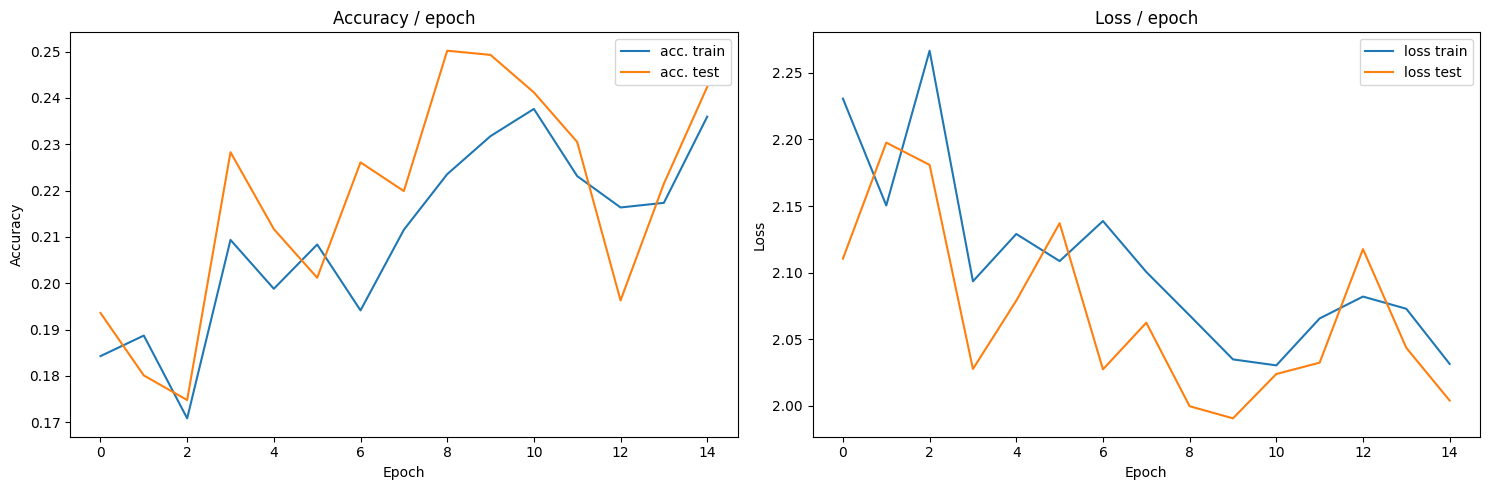

In [35]:
plt.figure(figsize=(15, 5))
# plt.clf()
plt.subplot(1, 2, 1)
plt.plot(np.array(stats_vit[0]), label="acc. train")
plt.plot(np.array(stats_vit[1]), label="acc. test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.array(stats_vit[2]), label="loss train")
plt.plot(np.array(stats_vit[3]), label="loss test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("stats_vit_15_0.001.pdf", dpi=100, bbox_inches="tight")
plt.show()

c) redo the training but with the ViT-S pretrained on ImageNet

In [36]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10).cuda()
stats_pretrained = main(model=model, epochs=15, tqdm_batch=True)


  0%|                                                                                                        | 0/938 [00:00<?, ?it/s]


  0%|                                                                                                         | 0/15 [00:00<?, ?it/s]


  0%|                                                                                                | 1/938 [00:00<09:37,  1.62it/s]


  0%|▏                                                                                               | 2/938 [00:01<09:01,  1.73it/s]


  0%|▎                                                                                               | 3/938 [00:01<08:49,  1.77it/s]


  0%|▍                                                                                               | 4/938 [00:02<08:43,  1.78it/s]


  1%|▌                                                                                               | 5/938 [00:02<08:40,  1.79it/s]


  1%|▌                                                                                               | 6/938 [00:03<08:38,  1.80it/s]


  1%|▋                                                                                               | 7/938 [00:03<08:37,  1.80it/s]


  1%|▊                                                                                               | 8/938 [00:04<08:35,  1.80it/s]


  1%|▉                                                                                               | 9/938 [00:05<08:34,  1.81it/s]


  1%|█                                                                                              | 10/938 [00:05<08:33,  1.81it/s]


  1%|█                                                                                              | 11/938 [00:06<08:32,  1.81it/s]


  1%|█▏                                                                                             | 12/938 [00:06<08:32,  1.81it/s]


  1%|█▎                                                                                             | 13/938 [00:07<08:31,  1.81it/s]


  1%|█▍                                                                                             | 14/938 [00:07<08:30,  1.81it/s]


  2%|█▌                                                                                             | 15/938 [00:08<08:29,  1.81it/s]


  2%|█▌                                                                                             | 16/938 [00:08<08:29,  1.81it/s]


  2%|█▋                                                                                             | 17/938 [00:09<08:29,  1.81it/s]


  2%|█▊                                                                                             | 18/938 [00:10<08:29,  1.81it/s]


  2%|█▉                                                                                             | 19/938 [00:10<08:28,  1.81it/s]


  2%|██                                                                                             | 20/938 [00:11<08:27,  1.81it/s]


  2%|██▏                                                                                            | 21/938 [00:11<08:27,  1.81it/s]


  2%|██▏                                                                                            | 22/938 [00:12<08:26,  1.81it/s]


  2%|██▎                                                                                            | 23/938 [00:12<08:26,  1.81it/s]


  3%|██▍                                                                                            | 24/938 [00:13<08:26,  1.81it/s]


  3%|██▌                                                                                            | 25/938 [00:13<08:25,  1.81it/s]


  3%|██▋                                                                                            | 26/938 [00:14<08:25,  1.80it/s]


  3%|██▋                                                                                            | 27/938 [00:14<08:24,  1.80it/s]


  3%|██▊                                                                                            | 28/938 [00:15<08:24,  1.80it/s]


  3%|██▉                                                                                            | 29/938 [00:16<08:24,  1.80it/s]


  3%|███                                                                                            | 30/938 [00:16<08:23,  1.80it/s]


  3%|███▏                                                                                           | 31/938 [00:17<08:23,  1.80it/s]


  3%|███▏                                                                                           | 32/938 [00:17<08:22,  1.80it/s]


  4%|███▎                                                                                           | 33/938 [00:18<08:21,  1.80it/s]


  4%|███▍                                                                                           | 34/938 [00:18<08:23,  1.79it/s]


  4%|███▌                                                                                           | 35/938 [00:19<08:22,  1.80it/s]


  4%|███▋                                                                                           | 36/938 [00:20<08:26,  1.78it/s]


  4%|███▋                                                                                           | 37/938 [00:20<08:31,  1.76it/s]


  4%|███▊                                                                                           | 38/938 [00:21<08:27,  1.77it/s]


  4%|███▉                                                                                           | 39/938 [00:21<08:24,  1.78it/s]


  4%|████                                                                                           | 40/938 [00:22<08:21,  1.79it/s]


  4%|████▏                                                                                          | 41/938 [00:22<08:19,  1.79it/s]


  4%|████▎                                                                                          | 42/938 [00:23<08:19,  1.80it/s]


  5%|████▎                                                                                          | 43/938 [00:23<08:18,  1.80it/s]


  5%|████▍                                                                                          | 44/938 [00:24<08:16,  1.80it/s]


  5%|████▌                                                                                          | 45/938 [00:25<08:15,  1.80it/s]


  5%|████▋                                                                                          | 46/938 [00:25<08:15,  1.80it/s]


  5%|████▊                                                                                          | 47/938 [00:26<08:15,  1.80it/s]


  5%|████▊                                                                                          | 48/938 [00:26<08:14,  1.80it/s]


  5%|████▉                                                                                          | 49/938 [00:27<08:14,  1.80it/s]


  5%|█████                                                                                          | 50/938 [00:27<08:13,  1.80it/s]


  5%|█████▏                                                                                         | 51/938 [00:28<08:13,  1.80it/s]


  6%|█████▎                                                                                         | 52/938 [00:28<08:12,  1.80it/s]


  6%|█████▎                                                                                         | 53/938 [00:29<08:12,  1.80it/s]


  6%|█████▍                                                                                         | 54/938 [00:30<08:11,  1.80it/s]


  6%|█████▌                                                                                         | 55/938 [00:30<08:10,  1.80it/s]


  6%|█████▋                                                                                         | 56/938 [00:31<08:10,  1.80it/s]


  6%|█████▊                                                                                         | 57/938 [00:31<08:09,  1.80it/s]


  6%|█████▊                                                                                         | 58/938 [00:32<08:08,  1.80it/s]


  6%|█████▉                                                                                         | 59/938 [00:32<08:07,  1.80it/s]


  6%|██████                                                                                         | 60/938 [00:33<08:07,  1.80it/s]


  7%|██████▏                                                                                        | 61/938 [00:33<08:06,  1.80it/s]


  7%|██████▎                                                                                        | 62/938 [00:34<08:07,  1.80it/s]


  7%|██████▍                                                                                        | 63/938 [00:35<08:06,  1.80it/s]


  7%|██████▍                                                                                        | 64/938 [00:35<08:05,  1.80it/s]


  7%|██████▌                                                                                        | 65/938 [00:36<08:05,  1.80it/s]


  7%|██████▋                                                                                        | 66/938 [00:36<08:04,  1.80it/s]


  7%|██████▊                                                                                        | 67/938 [00:37<08:04,  1.80it/s]


  7%|██████▉                                                                                        | 68/938 [00:37<08:03,  1.80it/s]


  7%|██████▉                                                                                        | 69/938 [00:38<08:02,  1.80it/s]


  7%|███████                                                                                        | 70/938 [00:38<08:05,  1.79it/s]


  8%|███████▏                                                                                       | 71/938 [00:39<08:03,  1.79it/s]


  8%|███████▎                                                                                       | 72/938 [00:40<08:02,  1.79it/s]


  8%|███████▍                                                                                       | 73/938 [00:40<08:05,  1.78it/s]


  8%|███████▍                                                                                       | 74/938 [00:41<08:07,  1.77it/s]


  8%|███████▌                                                                                       | 75/938 [00:41<08:08,  1.77it/s]


  8%|███████▋                                                                                       | 76/938 [00:42<08:09,  1.76it/s]


  8%|███████▊                                                                                       | 77/938 [00:42<08:09,  1.76it/s]


  8%|███████▉                                                                                       | 78/938 [00:43<08:09,  1.76it/s]


  8%|████████                                                                                       | 79/938 [00:44<08:05,  1.77it/s]


  9%|████████                                                                                       | 80/938 [00:44<08:02,  1.78it/s]


  9%|████████▏                                                                                      | 81/938 [00:45<08:00,  1.78it/s]


  9%|████████▎                                                                                      | 82/938 [00:45<07:59,  1.79it/s]


  9%|████████▍                                                                                      | 83/938 [00:46<07:57,  1.79it/s]


  9%|████████▌                                                                                      | 84/938 [00:46<07:56,  1.79it/s]


  9%|████████▌                                                                                      | 85/938 [00:47<07:55,  1.80it/s]


  9%|████████▋                                                                                      | 86/938 [00:47<07:54,  1.80it/s]


  9%|████████▊                                                                                      | 87/938 [00:48<07:53,  1.80it/s]


  9%|████████▉                                                                                      | 88/938 [00:49<07:52,  1.80it/s]


  9%|█████████                                                                                      | 89/938 [00:49<07:52,  1.80it/s]


 10%|█████████                                                                                      | 90/938 [00:50<07:51,  1.80it/s]


 10%|█████████▏                                                                                     | 91/938 [00:50<07:50,  1.80it/s]


 10%|█████████▎                                                                                     | 92/938 [00:51<07:50,  1.80it/s]


 10%|█████████▍                                                                                     | 93/938 [00:51<07:49,  1.80it/s]


 10%|█████████▌                                                                                     | 94/938 [00:52<07:49,  1.80it/s]


 10%|█████████▌                                                                                     | 95/938 [00:52<07:51,  1.79it/s]


 10%|█████████▋                                                                                     | 96/938 [00:53<07:49,  1.79it/s]


 10%|█████████▊                                                                                     | 97/938 [00:54<07:48,  1.80it/s]


 10%|█████████▉                                                                                     | 98/938 [00:54<07:47,  1.80it/s]


 11%|██████████                                                                                     | 99/938 [00:55<07:46,  1.80it/s]


 11%|██████████                                                                                    | 100/938 [00:55<07:46,  1.80it/s]


 11%|██████████                                                                                    | 101/938 [00:56<07:45,  1.80it/s]


 11%|██████████▏                                                                                   | 102/938 [00:56<07:44,  1.80it/s]


 11%|██████████▎                                                                                   | 103/938 [00:57<07:43,  1.80it/s]


 11%|██████████▍                                                                                   | 104/938 [00:57<07:43,  1.80it/s]


 11%|██████████▌                                                                                   | 105/938 [00:58<07:42,  1.80it/s]


 11%|██████████▌                                                                                   | 106/938 [00:59<07:42,  1.80it/s]


 11%|██████████▋                                                                                   | 107/938 [00:59<07:41,  1.80it/s]


 12%|██████████▊                                                                                   | 108/938 [01:00<07:40,  1.80it/s]


 12%|██████████▉                                                                                   | 109/938 [01:00<07:40,  1.80it/s]


 12%|███████████                                                                                   | 110/938 [01:01<07:40,  1.80it/s]


 12%|███████████                                                                                   | 111/938 [01:01<07:39,  1.80it/s]


 12%|███████████▏                                                                                  | 112/938 [01:02<07:38,  1.80it/s]


 12%|███████████▎                                                                                  | 113/938 [01:02<07:38,  1.80it/s]


 12%|███████████▍                                                                                  | 114/938 [01:03<07:37,  1.80it/s]


 12%|███████████▌                                                                                  | 115/938 [01:04<07:37,  1.80it/s]


 12%|███████████▌                                                                                  | 116/938 [01:04<07:36,  1.80it/s]


 12%|███████████▋                                                                                  | 117/938 [01:05<07:35,  1.80it/s]


 13%|███████████▊                                                                                  | 118/938 [01:05<07:35,  1.80it/s]


 13%|███████████▉                                                                                  | 119/938 [01:06<07:35,  1.80it/s]


 13%|████████████                                                                                  | 120/938 [01:06<07:38,  1.79it/s]


 13%|████████████▏                                                                                 | 121/938 [01:07<07:36,  1.79it/s]


 13%|████████████▏                                                                                 | 122/938 [01:07<07:35,  1.79it/s]


 13%|████████████▎                                                                                 | 123/938 [01:08<07:34,  1.79it/s]


 13%|████████████▍                                                                                 | 124/938 [01:09<07:32,  1.80it/s]


 13%|████████████▌                                                                                 | 125/938 [01:09<07:32,  1.80it/s]


 13%|████████████▋                                                                                 | 126/938 [01:10<07:31,  1.80it/s]


 14%|████████████▋                                                                                 | 127/938 [01:10<07:30,  1.80it/s]


 14%|████████████▊                                                                                 | 128/938 [01:11<07:29,  1.80it/s]


 14%|████████████▉                                                                                 | 129/938 [01:11<07:29,  1.80it/s]


 14%|█████████████                                                                                 | 130/938 [01:12<07:28,  1.80it/s]


 14%|█████████████▏                                                                                | 131/938 [01:12<07:27,  1.80it/s]


 14%|█████████████▏                                                                                | 132/938 [01:13<07:27,  1.80it/s]


 14%|█████████████▎                                                                                | 133/938 [01:14<07:26,  1.80it/s]


 14%|█████████████▍                                                                                | 134/938 [01:14<07:26,  1.80it/s]


 14%|█████████████▌                                                                                | 135/938 [01:15<07:25,  1.80it/s]


 14%|█████████████▋                                                                                | 136/938 [01:15<07:24,  1.80it/s]


 15%|█████████████▋                                                                                | 137/938 [01:16<07:24,  1.80it/s]


 15%|█████████████▊                                                                                | 138/938 [01:16<07:24,  1.80it/s]


 15%|█████████████▉                                                                                | 139/938 [01:17<07:23,  1.80it/s]


 15%|██████████████                                                                                | 140/938 [01:17<07:22,  1.80it/s]


 15%|██████████████▏                                                                               | 141/938 [01:18<07:22,  1.80it/s]


 15%|██████████████▏                                                                               | 142/938 [01:19<07:21,  1.80it/s]


 15%|██████████████▎                                                                               | 143/938 [01:19<07:21,  1.80it/s]


 15%|██████████████▍                                                                               | 144/938 [01:20<07:20,  1.80it/s]


 15%|██████████████▌                                                                               | 145/938 [01:20<07:19,  1.80it/s]


 16%|██████████████▋                                                                               | 146/938 [01:21<07:19,  1.80it/s]


 16%|██████████████▋                                                                               | 147/938 [01:21<07:18,  1.80it/s]


 16%|██████████████▊                                                                               | 148/938 [01:22<07:18,  1.80it/s]


 16%|██████████████▉                                                                               | 149/938 [01:22<07:17,  1.80it/s]


 16%|███████████████                                                                               | 150/938 [01:23<07:17,  1.80it/s]


 16%|███████████████▏                                                                              | 151/938 [01:24<07:16,  1.80it/s]


 16%|███████████████▏                                                                              | 152/938 [01:24<07:16,  1.80it/s]


 16%|███████████████▎                                                                              | 153/938 [01:25<07:16,  1.80it/s]


 16%|███████████████▍                                                                              | 154/938 [01:25<07:15,  1.80it/s]


 17%|███████████████▌                                                                              | 155/938 [01:26<07:14,  1.80it/s]


 17%|███████████████▋                                                                              | 156/938 [01:26<07:14,  1.80it/s]


 17%|███████████████▋                                                                              | 157/938 [01:27<07:13,  1.80it/s]


 17%|███████████████▊                                                                              | 158/938 [01:27<07:12,  1.80it/s]


 17%|███████████████▉                                                                              | 159/938 [01:28<07:12,  1.80it/s]


 17%|████████████████                                                                              | 160/938 [01:29<07:12,  1.80it/s]


 17%|████████████████▏                                                                             | 161/938 [01:29<07:11,  1.80it/s]


 17%|████████████████▏                                                                             | 162/938 [01:30<07:10,  1.80it/s]


 17%|████████████████▎                                                                             | 163/938 [01:30<07:10,  1.80it/s]


 17%|████████████████▍                                                                             | 164/938 [01:31<07:09,  1.80it/s]


 18%|████████████████▌                                                                             | 165/938 [01:31<07:09,  1.80it/s]


 18%|████████████████▋                                                                             | 166/938 [01:32<07:08,  1.80it/s]


 18%|████████████████▋                                                                             | 167/938 [01:32<07:08,  1.80it/s]


 18%|████████████████▊                                                                             | 168/938 [01:33<07:07,  1.80it/s]


 18%|████████████████▉                                                                             | 169/938 [01:34<07:07,  1.80it/s]


 18%|█████████████████                                                                             | 170/938 [01:34<07:06,  1.80it/s]


 18%|█████████████████▏                                                                            | 171/938 [01:35<07:05,  1.80it/s]


 18%|█████████████████▏                                                                            | 172/938 [01:35<07:05,  1.80it/s]


 18%|█████████████████▎                                                                            | 173/938 [01:36<07:04,  1.80it/s]


 19%|█████████████████▍                                                                            | 174/938 [01:36<07:03,  1.80it/s]


 19%|█████████████████▌                                                                            | 175/938 [01:37<07:06,  1.79it/s]


 19%|█████████████████▋                                                                            | 176/938 [01:37<07:08,  1.78it/s]


 19%|█████████████████▋                                                                            | 177/938 [01:38<07:09,  1.77it/s]


 19%|█████████████████▊                                                                            | 178/938 [01:39<07:09,  1.77it/s]


 19%|█████████████████▉                                                                            | 179/938 [01:39<07:09,  1.77it/s]


 19%|██████████████████                                                                            | 180/938 [01:40<07:09,  1.77it/s]


 19%|██████████████████▏                                                                           | 181/938 [01:40<07:09,  1.76it/s]


 19%|██████████████████▏                                                                           | 182/938 [01:41<07:08,  1.76it/s]


 20%|██████████████████▎                                                                           | 183/938 [01:41<07:08,  1.76it/s]


 20%|██████████████████▍                                                                           | 184/938 [01:42<07:07,  1.76it/s]


 20%|██████████████████▌                                                                           | 185/938 [01:43<07:07,  1.76it/s]


 20%|██████████████████▋                                                                           | 186/938 [01:43<07:06,  1.76it/s]


 20%|██████████████████▋                                                                           | 187/938 [01:44<07:06,  1.76it/s]


 20%|██████████████████▊                                                                           | 188/938 [01:44<07:06,  1.76it/s]


 20%|██████████████████▉                                                                           | 189/938 [01:45<07:06,  1.76it/s]


 20%|███████████████████                                                                           | 190/938 [01:45<07:05,  1.76it/s]


 20%|███████████████████▏                                                                          | 191/938 [01:46<07:05,  1.76it/s]


 20%|███████████████████▏                                                                          | 192/938 [01:47<07:01,  1.77it/s]


 21%|███████████████████▎                                                                          | 193/938 [01:47<06:59,  1.78it/s]


 21%|███████████████████▍                                                                          | 194/938 [01:48<06:57,  1.78it/s]


 21%|███████████████████▌                                                                          | 195/938 [01:48<06:57,  1.78it/s]


 21%|███████████████████▋                                                                          | 196/938 [01:49<06:55,  1.78it/s]


 21%|███████████████████▋                                                                          | 197/938 [01:49<06:54,  1.79it/s]


 21%|███████████████████▊                                                                          | 198/938 [01:50<06:53,  1.79it/s]


 21%|███████████████████▉                                                                          | 199/938 [01:50<06:52,  1.79it/s]


 21%|████████████████████                                                                          | 200/938 [01:51<06:51,  1.79it/s]


 21%|████████████████████▏                                                                         | 201/938 [01:52<06:50,  1.79it/s]


 22%|████████████████████▏                                                                         | 202/938 [01:52<06:50,  1.79it/s]


 22%|████████████████████▎                                                                         | 203/938 [01:53<06:49,  1.79it/s]


 22%|████████████████████▍                                                                         | 204/938 [01:53<06:48,  1.80it/s]


 22%|████████████████████▌                                                                         | 205/938 [01:54<06:48,  1.80it/s]


 22%|████████████████████▋                                                                         | 206/938 [01:54<06:47,  1.80it/s]


 22%|████████████████████▋                                                                         | 207/938 [01:55<06:46,  1.80it/s]


 22%|████████████████████▊                                                                         | 208/938 [01:55<06:46,  1.80it/s]


 22%|████████████████████▉                                                                         | 209/938 [01:56<06:46,  1.79it/s]


 22%|█████████████████████                                                                         | 210/938 [01:57<06:46,  1.79it/s]


 22%|█████████████████████▏                                                                        | 211/938 [01:57<06:45,  1.79it/s]


 23%|█████████████████████▏                                                                        | 212/938 [01:58<06:44,  1.79it/s]


 23%|█████████████████████▎                                                                        | 213/938 [01:58<06:43,  1.80it/s]


 23%|█████████████████████▍                                                                        | 214/938 [01:59<06:42,  1.80it/s]


 23%|█████████████████████▌                                                                        | 215/938 [01:59<06:41,  1.80it/s]


 23%|█████████████████████▋                                                                        | 216/938 [02:00<06:40,  1.80it/s]


 23%|█████████████████████▋                                                                        | 217/938 [02:00<06:40,  1.80it/s]


 23%|█████████████████████▊                                                                        | 218/938 [02:01<06:49,  1.76it/s]


 23%|█████████████████████▉                                                                        | 219/938 [02:02<06:49,  1.76it/s]


 23%|██████████████████████                                                                        | 220/938 [02:02<06:48,  1.76it/s]


 24%|██████████████████████▏                                                                       | 221/938 [02:03<06:48,  1.76it/s]


 24%|██████████████████████▏                                                                       | 222/938 [02:03<06:47,  1.76it/s]


 24%|██████████████████████▎                                                                       | 223/938 [02:04<06:46,  1.76it/s]


 24%|██████████████████████▍                                                                       | 224/938 [02:04<06:46,  1.76it/s]


 24%|██████████████████████▌                                                                       | 225/938 [02:05<06:45,  1.76it/s]


 24%|██████████████████████▋                                                                       | 226/938 [02:06<06:45,  1.76it/s]


 24%|██████████████████████▋                                                                       | 227/938 [02:06<06:44,  1.76it/s]


 24%|██████████████████████▊                                                                       | 228/938 [02:07<06:44,  1.76it/s]


 24%|██████████████████████▉                                                                       | 229/938 [02:07<06:43,  1.76it/s]


 25%|███████████████████████                                                                       | 230/938 [02:08<06:39,  1.77it/s]


 25%|███████████████████████▏                                                                      | 231/938 [02:08<06:37,  1.78it/s]


 25%|███████████████████████▏                                                                      | 232/938 [02:09<06:35,  1.79it/s]


 25%|███████████████████████▎                                                                      | 233/938 [02:10<06:36,  1.78it/s]


 25%|███████████████████████▍                                                                      | 234/938 [02:10<06:34,  1.79it/s]


 25%|███████████████████████▌                                                                      | 235/938 [02:11<06:41,  1.75it/s]


 25%|███████████████████████▋                                                                      | 236/938 [02:11<06:37,  1.77it/s]


 25%|███████████████████████▊                                                                      | 237/938 [02:12<06:35,  1.77it/s]


 25%|███████████████████████▊                                                                      | 238/938 [02:12<06:33,  1.78it/s]


 25%|███████████████████████▉                                                                      | 239/938 [02:13<06:31,  1.79it/s]


 26%|████████████████████████                                                                      | 240/938 [02:13<06:29,  1.79it/s]


 26%|████████████████████████▏                                                                     | 241/938 [02:14<06:28,  1.80it/s]


 26%|████████████████████████▎                                                                     | 242/938 [02:15<06:27,  1.80it/s]


 26%|████████████████████████▎                                                                     | 243/938 [02:15<06:26,  1.80it/s]


 26%|████████████████████████▍                                                                     | 244/938 [02:16<06:25,  1.80it/s]


 26%|████████████████████████▌                                                                     | 245/938 [02:16<06:24,  1.80it/s]


 26%|████████████████████████▋                                                                     | 246/938 [02:17<06:23,  1.80it/s]


 26%|████████████████████████▊                                                                     | 247/938 [02:17<06:23,  1.80it/s]


 26%|████████████████████████▊                                                                     | 248/938 [02:18<06:22,  1.80it/s]


 27%|████████████████████████▉                                                                     | 249/938 [02:18<06:22,  1.80it/s]


 27%|█████████████████████████                                                                     | 250/938 [02:19<06:24,  1.79it/s]


 27%|█████████████████████████▏                                                                    | 251/938 [02:20<06:23,  1.79it/s]


 27%|█████████████████████████▎                                                                    | 252/938 [02:20<06:22,  1.80it/s]


 27%|█████████████████████████▎                                                                    | 253/938 [02:21<06:21,  1.80it/s]


 27%|█████████████████████████▍                                                                    | 254/938 [02:21<06:20,  1.80it/s]


 27%|█████████████████████████▌                                                                    | 255/938 [02:22<06:19,  1.80it/s]


 27%|█████████████████████████▋                                                                    | 256/938 [02:22<06:18,  1.80it/s]


 27%|█████████████████████████▊                                                                    | 257/938 [02:23<06:17,  1.80it/s]


 28%|█████████████████████████▊                                                                    | 258/938 [02:23<06:17,  1.80it/s]


 28%|█████████████████████████▉                                                                    | 259/938 [02:24<06:16,  1.80it/s]


 28%|██████████████████████████                                                                    | 260/938 [02:25<06:16,  1.80it/s]


 28%|██████████████████████████▏                                                                   | 261/938 [02:25<06:15,  1.80it/s]


 28%|██████████████████████████▎                                                                   | 262/938 [02:26<06:14,  1.80it/s]


 28%|██████████████████████████▎                                                                   | 263/938 [02:26<06:14,  1.80it/s]


 28%|██████████████████████████▍                                                                   | 264/938 [02:27<06:14,  1.80it/s]


 28%|██████████████████████████▌                                                                   | 265/938 [02:27<06:13,  1.80it/s]


 28%|██████████████████████████▋                                                                   | 266/938 [02:28<06:13,  1.80it/s]


 28%|██████████████████████████▊                                                                   | 267/938 [02:28<06:12,  1.80it/s]


 29%|██████████████████████████▊                                                                   | 268/938 [02:29<06:11,  1.80it/s]


 29%|██████████████████████████▉                                                                   | 269/938 [02:30<06:11,  1.80it/s]


 29%|███████████████████████████                                                                   | 270/938 [02:30<06:10,  1.80it/s]


 29%|███████████████████████████▏                                                                  | 271/938 [02:31<06:09,  1.80it/s]


 29%|███████████████████████████▎                                                                  | 272/938 [02:31<06:09,  1.80it/s]


 29%|███████████████████████████▎                                                                  | 273/938 [02:32<06:16,  1.77it/s]


 29%|███████████████████████████▍                                                                  | 274/938 [02:32<06:13,  1.78it/s]


 29%|███████████████████████████▌                                                                  | 275/938 [02:33<06:11,  1.79it/s]


 29%|███████████████████████████▋                                                                  | 276/938 [02:34<06:09,  1.79it/s]


 30%|███████████████████████████▊                                                                  | 277/938 [02:34<06:07,  1.80it/s]


 30%|███████████████████████████▊                                                                  | 278/938 [02:35<06:06,  1.80it/s]


 30%|███████████████████████████▉                                                                  | 279/938 [02:35<06:05,  1.80it/s]


 30%|████████████████████████████                                                                  | 280/938 [02:36<06:04,  1.80it/s]


 30%|████████████████████████████▏                                                                 | 281/938 [02:36<06:03,  1.81it/s]


 30%|████████████████████████████▎                                                                 | 282/938 [02:37<06:03,  1.81it/s]


 30%|████████████████████████████▎                                                                 | 283/938 [02:37<06:03,  1.80it/s]


 30%|████████████████████████████▍                                                                 | 284/938 [02:38<06:02,  1.80it/s]


 30%|████████████████████████████▌                                                                 | 285/938 [02:38<06:01,  1.80it/s]


 30%|████████████████████████████▋                                                                 | 286/938 [02:39<06:01,  1.80it/s]


 31%|████████████████████████████▊                                                                 | 287/938 [02:40<06:00,  1.81it/s]


 31%|████████████████████████████▊                                                                 | 288/938 [02:40<06:00,  1.81it/s]


 31%|████████████████████████████▉                                                                 | 289/938 [02:41<05:59,  1.81it/s]


 31%|█████████████████████████████                                                                 | 290/938 [02:41<05:58,  1.81it/s]


 31%|█████████████████████████████▏                                                                | 291/938 [02:42<06:02,  1.78it/s]


 31%|█████████████████████████████▎                                                                | 292/938 [02:42<06:00,  1.79it/s]


 31%|█████████████████████████████▎                                                                | 293/938 [02:43<05:59,  1.79it/s]


 31%|█████████████████████████████▍                                                                | 294/938 [02:43<05:58,  1.80it/s]


 31%|█████████████████████████████▌                                                                | 295/938 [02:44<05:57,  1.80it/s]


 32%|█████████████████████████████▋                                                                | 296/938 [02:45<05:56,  1.80it/s]


 32%|█████████████████████████████▊                                                                | 297/938 [02:45<05:55,  1.80it/s]


 32%|█████████████████████████████▊                                                                | 298/938 [02:46<05:55,  1.80it/s]


 32%|█████████████████████████████▉                                                                | 299/938 [02:46<05:54,  1.80it/s]


 32%|██████████████████████████████                                                                | 300/938 [02:47<05:53,  1.80it/s]


 32%|██████████████████████████████▏                                                               | 301/938 [02:47<05:53,  1.80it/s]


 32%|██████████████████████████████▎                                                               | 302/938 [02:48<05:52,  1.80it/s]


 32%|██████████████████████████████▎                                                               | 303/938 [02:48<05:52,  1.80it/s]


 32%|██████████████████████████████▍                                                               | 304/938 [02:49<05:51,  1.80it/s]


 33%|██████████████████████████████▌                                                               | 305/938 [02:50<05:50,  1.80it/s]


 33%|██████████████████████████████▋                                                               | 306/938 [02:50<05:50,  1.80it/s]


 33%|██████████████████████████████▊                                                               | 307/938 [02:51<05:49,  1.80it/s]


 33%|██████████████████████████████▊                                                               | 308/938 [02:51<05:49,  1.80it/s]


 33%|██████████████████████████████▉                                                               | 309/938 [02:52<05:49,  1.80it/s]


 33%|███████████████████████████████                                                               | 310/938 [02:52<05:48,  1.80it/s]


 33%|███████████████████████████████▏                                                              | 311/938 [02:53<05:47,  1.80it/s]


 33%|███████████████████████████████▎                                                              | 312/938 [02:53<05:47,  1.80it/s]


 33%|███████████████████████████████▎                                                              | 313/938 [02:54<05:46,  1.80it/s]


 33%|███████████████████████████████▍                                                              | 314/938 [02:55<05:46,  1.80it/s]


 34%|███████████████████████████████▌                                                              | 315/938 [02:55<05:45,  1.80it/s]


 34%|███████████████████████████████▋                                                              | 316/938 [02:56<05:45,  1.80it/s]


 34%|███████████████████████████████▊                                                              | 317/938 [02:56<05:44,  1.80it/s]


 34%|███████████████████████████████▊                                                              | 318/938 [02:57<05:43,  1.80it/s]


 34%|███████████████████████████████▉                                                              | 319/938 [02:57<05:43,  1.80it/s]


 34%|████████████████████████████████                                                              | 320/938 [02:58<05:42,  1.80it/s]


 34%|████████████████████████████████▏                                                             | 321/938 [02:59<05:52,  1.75it/s]


 34%|████████████████████████████████▎                                                             | 322/938 [02:59<05:51,  1.75it/s]


 34%|████████████████████████████████▎                                                             | 323/938 [03:00<05:50,  1.75it/s]


 35%|████████████████████████████████▍                                                             | 324/938 [03:00<05:49,  1.75it/s]


 35%|████████████████████████████████▌                                                             | 325/938 [03:01<05:49,  1.75it/s]


 35%|████████████████████████████████▋                                                             | 326/938 [03:01<05:48,  1.76it/s]


 35%|████████████████████████████████▊                                                             | 327/938 [03:02<05:48,  1.75it/s]


 35%|████████████████████████████████▊                                                             | 328/938 [03:03<05:47,  1.76it/s]


 35%|████████████████████████████████▉                                                             | 329/938 [03:03<05:46,  1.76it/s]


 35%|█████████████████████████████████                                                             | 330/938 [03:04<05:46,  1.75it/s]


 35%|█████████████████████████████████▏                                                            | 331/938 [03:04<05:46,  1.75it/s]


 35%|█████████████████████████████████▎                                                            | 332/938 [03:05<05:45,  1.75it/s]


 36%|█████████████████████████████████▎                                                            | 333/938 [03:05<05:45,  1.75it/s]


 36%|█████████████████████████████████▍                                                            | 334/938 [03:06<05:44,  1.75it/s]


 36%|█████████████████████████████████▌                                                            | 335/938 [03:07<05:43,  1.75it/s]


 36%|█████████████████████████████████▋                                                            | 336/938 [03:07<05:43,  1.75it/s]


 36%|█████████████████████████████████▊                                                            | 337/938 [03:08<05:42,  1.75it/s]


 36%|█████████████████████████████████▊                                                            | 338/938 [03:08<05:42,  1.75it/s]


 36%|█████████████████████████████████▉                                                            | 339/938 [03:09<05:41,  1.75it/s]


 36%|██████████████████████████████████                                                            | 340/938 [03:09<05:40,  1.75it/s]


 36%|██████████████████████████████████▏                                                           | 341/938 [03:10<05:40,  1.75it/s]


 36%|██████████████████████████████████▎                                                           | 342/938 [03:10<05:39,  1.75it/s]


 37%|██████████████████████████████████▎                                                           | 343/938 [03:11<05:39,  1.75it/s]


 37%|██████████████████████████████████▍                                                           | 344/938 [03:12<05:39,  1.75it/s]


 37%|██████████████████████████████████▌                                                           | 345/938 [03:12<05:38,  1.75it/s]


 37%|██████████████████████████████████▋                                                           | 346/938 [03:13<05:37,  1.75it/s]


 37%|██████████████████████████████████▊                                                           | 347/938 [03:13<05:37,  1.75it/s]


 37%|██████████████████████████████████▊                                                           | 348/938 [03:14<05:36,  1.75it/s]


 37%|██████████████████████████████████▉                                                           | 349/938 [03:14<05:36,  1.75it/s]


 37%|███████████████████████████████████                                                           | 350/938 [03:15<05:35,  1.75it/s]


 37%|███████████████████████████████████▏                                                          | 351/938 [03:16<05:34,  1.75it/s]


 38%|███████████████████████████████████▎                                                          | 352/938 [03:16<05:34,  1.75it/s]


 38%|███████████████████████████████████▍                                                          | 353/938 [03:17<05:33,  1.75it/s]


 38%|███████████████████████████████████▍                                                          | 354/938 [03:17<05:33,  1.75it/s]


 38%|███████████████████████████████████▌                                                          | 355/938 [03:18<05:30,  1.77it/s]


 38%|███████████████████████████████████▋                                                          | 356/938 [03:18<05:27,  1.78it/s]


 38%|███████████████████████████████████▊                                                          | 357/938 [03:19<05:25,  1.78it/s]


 38%|███████████████████████████████████▉                                                          | 358/938 [03:20<05:24,  1.79it/s]


 38%|███████████████████████████████████▉                                                          | 359/938 [03:20<05:25,  1.78it/s]


 38%|████████████████████████████████████                                                          | 360/938 [03:21<05:26,  1.77it/s]


 38%|████████████████████████████████████▏                                                         | 361/938 [03:21<05:26,  1.77it/s]


 39%|████████████████████████████████████▎                                                         | 362/938 [03:22<05:24,  1.78it/s]


 39%|████████████████████████████████████▍                                                         | 363/938 [03:22<05:22,  1.78it/s]


 39%|████████████████████████████████████▍                                                         | 364/938 [03:23<05:21,  1.79it/s]


 39%|████████████████████████████████████▌                                                         | 365/938 [03:24<05:19,  1.79it/s]


 39%|████████████████████████████████████▋                                                         | 366/938 [03:24<05:22,  1.77it/s]


 39%|████████████████████████████████████▊                                                         | 367/938 [03:25<05:23,  1.77it/s]


 39%|████████████████████████████████████▉                                                         | 368/938 [03:25<05:20,  1.78it/s]


 39%|████████████████████████████████████▉                                                         | 369/938 [03:26<05:18,  1.79it/s]


 39%|█████████████████████████████████████                                                         | 370/938 [03:26<05:16,  1.79it/s]


 40%|█████████████████████████████████████▏                                                        | 371/938 [03:27<05:15,  1.80it/s]


 40%|█████████████████████████████████████▎                                                        | 372/938 [03:27<05:15,  1.79it/s]


 40%|█████████████████████████████████████▍                                                        | 373/938 [03:28<05:14,  1.80it/s]


 40%|█████████████████████████████████████▍                                                        | 374/938 [03:29<05:13,  1.80it/s]


 40%|█████████████████████████████████████▌                                                        | 375/938 [03:29<05:12,  1.80it/s]


 40%|█████████████████████████████████████▋                                                        | 376/938 [03:30<05:12,  1.80it/s]


 40%|█████████████████████████████████████▊                                                        | 377/938 [03:30<05:11,  1.80it/s]


 40%|█████████████████████████████████████▉                                                        | 378/938 [03:31<05:11,  1.80it/s]


 40%|█████████████████████████████████████▉                                                        | 379/938 [03:31<05:10,  1.80it/s]


 41%|██████████████████████████████████████                                                        | 380/938 [03:32<05:09,  1.80it/s]


 41%|██████████████████████████████████████▏                                                       | 381/938 [03:32<05:09,  1.80it/s]


 41%|██████████████████████████████████████▎                                                       | 382/938 [03:33<05:08,  1.80it/s]


 41%|██████████████████████████████████████▍                                                       | 383/938 [03:34<05:11,  1.78it/s]


 41%|██████████████████████████████████████▍                                                       | 384/938 [03:34<05:09,  1.79it/s]


 41%|██████████████████████████████████████▌                                                       | 385/938 [03:35<05:08,  1.79it/s]


 41%|██████████████████████████████████████▋                                                       | 386/938 [03:35<05:11,  1.77it/s]


 41%|██████████████████████████████████████▊                                                       | 387/938 [03:36<05:08,  1.78it/s]


 41%|██████████████████████████████████████▉                                                       | 388/938 [03:36<05:07,  1.79it/s]


 41%|██████████████████████████████████████▉                                                       | 389/938 [03:37<05:06,  1.79it/s]


 42%|███████████████████████████████████████                                                       | 390/938 [03:37<05:05,  1.79it/s]


 42%|███████████████████████████████████████▏                                                      | 391/938 [03:38<05:07,  1.78it/s]


 42%|███████████████████████████████████████▎                                                      | 392/938 [03:39<05:05,  1.79it/s]


 42%|███████████████████████████████████████▍                                                      | 393/938 [03:39<05:04,  1.79it/s]


 42%|███████████████████████████████████████▍                                                      | 394/938 [03:40<05:03,  1.79it/s]


 42%|███████████████████████████████████████▌                                                      | 395/938 [03:40<05:02,  1.80it/s]


 42%|███████████████████████████████████████▋                                                      | 396/938 [03:41<05:01,  1.80it/s]


 42%|███████████████████████████████████████▊                                                      | 397/938 [03:41<05:03,  1.78it/s]


 42%|███████████████████████████████████████▉                                                      | 398/938 [03:42<05:03,  1.78it/s]


 43%|███████████████████████████████████████▉                                                      | 399/938 [03:42<05:01,  1.79it/s]


 43%|████████████████████████████████████████                                                      | 400/938 [03:43<05:00,  1.79it/s]


 43%|████████████████████████████████████████▏                                                     | 401/938 [03:44<04:59,  1.79it/s]


 43%|████████████████████████████████████████▎                                                     | 402/938 [03:44<04:58,  1.80it/s]


 43%|████████████████████████████████████████▍                                                     | 403/938 [03:45<04:57,  1.80it/s]


 43%|████████████████████████████████████████▍                                                     | 404/938 [03:45<04:57,  1.80it/s]


 43%|████████████████████████████████████████▌                                                     | 405/938 [03:46<04:56,  1.80it/s]


 43%|████████████████████████████████████████▋                                                     | 406/938 [03:46<04:55,  1.80it/s]


 43%|████████████████████████████████████████▊                                                     | 407/938 [03:47<04:54,  1.80it/s]


 43%|████████████████████████████████████████▉                                                     | 408/938 [03:47<04:54,  1.80it/s]


 44%|████████████████████████████████████████▉                                                     | 409/938 [03:48<04:53,  1.80it/s]


 44%|█████████████████████████████████████████                                                     | 410/938 [03:49<04:53,  1.80it/s]


 44%|█████████████████████████████████████████▏                                                    | 411/938 [03:49<04:52,  1.80it/s]


 44%|█████████████████████████████████████████▎                                                    | 412/938 [03:50<04:52,  1.80it/s]


 44%|█████████████████████████████████████████▍                                                    | 413/938 [03:50<04:51,  1.80it/s]


 44%|█████████████████████████████████████████▍                                                    | 414/938 [03:51<04:50,  1.80it/s]


 44%|█████████████████████████████████████████▌                                                    | 415/938 [03:51<04:52,  1.79it/s]


 44%|█████████████████████████████████████████▋                                                    | 416/938 [03:52<04:54,  1.78it/s]


 44%|█████████████████████████████████████████▊                                                    | 417/938 [03:53<04:54,  1.77it/s]


 45%|█████████████████████████████████████████▉                                                    | 418/938 [03:53<04:54,  1.76it/s]


 45%|█████████████████████████████████████████▉                                                    | 419/938 [03:54<04:52,  1.78it/s]


 45%|██████████████████████████████████████████                                                    | 420/938 [03:54<04:50,  1.79it/s]


 45%|██████████████████████████████████████████▏                                                   | 421/938 [03:55<04:48,  1.79it/s]


 45%|██████████████████████████████████████████▎                                                   | 422/938 [03:55<04:47,  1.79it/s]


 45%|██████████████████████████████████████████▍                                                   | 423/938 [03:56<04:46,  1.80it/s]


 45%|██████████████████████████████████████████▍                                                   | 424/938 [03:56<04:45,  1.80it/s]


 45%|██████████████████████████████████████████▌                                                   | 425/938 [03:57<04:45,  1.80it/s]


 45%|██████████████████████████████████████████▋                                                   | 426/938 [03:58<04:44,  1.80it/s]


 46%|██████████████████████████████████████████▊                                                   | 427/938 [03:58<04:43,  1.80it/s]


 46%|██████████████████████████████████████████▉                                                   | 428/938 [03:59<04:43,  1.80it/s]


 46%|██████████████████████████████████████████▉                                                   | 429/938 [03:59<04:42,  1.80it/s]


 46%|███████████████████████████████████████████                                                   | 430/938 [04:00<04:42,  1.80it/s]


 46%|███████████████████████████████████████████▏                                                  | 431/938 [04:00<04:41,  1.80it/s]


 46%|███████████████████████████████████████████▎                                                  | 432/938 [04:01<04:43,  1.79it/s]


 46%|███████████████████████████████████████████▍                                                  | 433/938 [04:01<04:44,  1.78it/s]


 46%|███████████████████████████████████████████▍                                                  | 434/938 [04:02<04:45,  1.77it/s]


 46%|███████████████████████████████████████████▌                                                  | 435/938 [04:03<04:45,  1.76it/s]


 46%|███████████████████████████████████████████▋                                                  | 436/938 [04:03<04:43,  1.77it/s]


 47%|███████████████████████████████████████████▊                                                  | 437/938 [04:04<04:41,  1.78it/s]


 47%|███████████████████████████████████████████▉                                                  | 438/938 [04:04<04:43,  1.77it/s]


 47%|███████████████████████████████████████████▉                                                  | 439/938 [04:05<04:40,  1.78it/s]


 47%|████████████████████████████████████████████                                                  | 440/938 [04:05<04:39,  1.78it/s]


 47%|████████████████████████████████████████████▏                                                 | 441/938 [04:06<04:37,  1.79it/s]


 47%|████████████████████████████████████████████▎                                                 | 442/938 [04:07<04:36,  1.79it/s]


 47%|████████████████████████████████████████████▍                                                 | 443/938 [04:07<04:35,  1.80it/s]


 47%|████████████████████████████████████████████▍                                                 | 444/938 [04:08<04:34,  1.80it/s]


 47%|████████████████████████████████████████████▌                                                 | 445/938 [04:08<04:36,  1.78it/s]


 48%|████████████████████████████████████████████▋                                                 | 446/938 [04:09<04:37,  1.77it/s]


 48%|████████████████████████████████████████████▊                                                 | 447/938 [04:09<04:37,  1.77it/s]


 48%|████████████████████████████████████████████▉                                                 | 448/938 [04:10<04:37,  1.76it/s]


 48%|████████████████████████████████████████████▉                                                 | 449/938 [04:10<04:37,  1.76it/s]


 48%|█████████████████████████████████████████████                                                 | 450/938 [04:11<04:37,  1.76it/s]


 48%|█████████████████████████████████████████████▏                                                | 451/938 [04:12<04:37,  1.76it/s]


 48%|█████████████████████████████████████████████▎                                                | 452/938 [04:12<04:36,  1.76it/s]


 48%|█████████████████████████████████████████████▍                                                | 453/938 [04:13<04:36,  1.75it/s]


 48%|█████████████████████████████████████████████▍                                                | 454/938 [04:13<04:35,  1.76it/s]


 49%|█████████████████████████████████████████████▌                                                | 455/938 [04:14<04:35,  1.75it/s]


 49%|█████████████████████████████████████████████▋                                                | 456/938 [04:14<04:35,  1.75it/s]


 49%|█████████████████████████████████████████████▊                                                | 457/938 [04:15<04:34,  1.75it/s]


 49%|█████████████████████████████████████████████▉                                                | 458/938 [04:16<04:34,  1.75it/s]


 49%|█████████████████████████████████████████████▉                                                | 459/938 [04:16<04:33,  1.75it/s]


 49%|██████████████████████████████████████████████                                                | 460/938 [04:17<04:32,  1.75it/s]


 49%|██████████████████████████████████████████████▏                                               | 461/938 [04:17<04:29,  1.77it/s]


 49%|██████████████████████████████████████████████▎                                               | 462/938 [04:18<04:27,  1.78it/s]


 49%|██████████████████████████████████████████████▍                                               | 463/938 [04:18<04:26,  1.78it/s]


 49%|██████████████████████████████████████████████▍                                               | 464/938 [04:19<04:25,  1.79it/s]


 50%|██████████████████████████████████████████████▌                                               | 465/938 [04:20<04:26,  1.77it/s]


 50%|██████████████████████████████████████████████▋                                               | 466/938 [04:20<04:24,  1.78it/s]


 50%|██████████████████████████████████████████████▊                                               | 467/938 [04:21<04:23,  1.79it/s]


 50%|██████████████████████████████████████████████▉                                               | 468/938 [04:21<04:23,  1.78it/s]


 50%|███████████████████████████████████████████████                                               | 469/938 [04:22<04:25,  1.77it/s]


 50%|███████████████████████████████████████████████                                               | 470/938 [04:22<04:23,  1.78it/s]


 50%|███████████████████████████████████████████████▏                                              | 471/938 [04:23<04:21,  1.78it/s]


 50%|███████████████████████████████████████████████▎                                              | 472/938 [04:23<04:20,  1.79it/s]


 50%|███████████████████████████████████████████████▍                                              | 473/938 [04:24<04:19,  1.79it/s]


 51%|███████████████████████████████████████████████▌                                              | 474/938 [04:25<04:18,  1.79it/s]


 51%|███████████████████████████████████████████████▌                                              | 475/938 [04:25<04:25,  1.74it/s]


 51%|███████████████████████████████████████████████▋                                              | 476/938 [04:26<04:22,  1.76it/s]


 51%|███████████████████████████████████████████████▊                                              | 477/938 [04:26<04:20,  1.77it/s]


 51%|███████████████████████████████████████████████▉                                              | 478/938 [04:27<04:18,  1.78it/s]


 51%|████████████████████████████████████████████████                                              | 479/938 [04:27<04:16,  1.79it/s]


 51%|████████████████████████████████████████████████                                              | 480/938 [04:28<04:15,  1.79it/s]


 51%|████████████████████████████████████████████████▏                                             | 481/938 [04:29<04:17,  1.78it/s]


 51%|████████████████████████████████████████████████▎                                             | 482/938 [04:29<04:15,  1.79it/s]


 51%|████████████████████████████████████████████████▍                                             | 483/938 [04:30<04:14,  1.79it/s]


 52%|████████████████████████████████████████████████▌                                             | 484/938 [04:30<04:13,  1.79it/s]


 52%|████████████████████████████████████████████████▌                                             | 485/938 [04:31<04:12,  1.80it/s]


 52%|████████████████████████████████████████████████▋                                             | 486/938 [04:31<04:11,  1.80it/s]


 52%|████████████████████████████████████████████████▊                                             | 487/938 [04:32<04:10,  1.80it/s]


 52%|████████████████████████████████████████████████▉                                             | 488/938 [04:32<04:10,  1.80it/s]


 52%|█████████████████████████████████████████████████                                             | 489/938 [04:33<04:09,  1.80it/s]


 52%|█████████████████████████████████████████████████                                             | 490/938 [04:34<04:08,  1.80it/s]


 52%|█████████████████████████████████████████████████▏                                            | 491/938 [04:34<04:08,  1.80it/s]


 52%|█████████████████████████████████████████████████▎                                            | 492/938 [04:35<04:07,  1.80it/s]


 53%|█████████████████████████████████████████████████▍                                            | 493/938 [04:35<04:07,  1.80it/s]


 53%|█████████████████████████████████████████████████▌                                            | 494/938 [04:36<04:06,  1.80it/s]


 53%|█████████████████████████████████████████████████▌                                            | 495/938 [04:36<04:05,  1.80it/s]


 53%|█████████████████████████████████████████████████▋                                            | 496/938 [04:37<04:05,  1.80it/s]


 53%|█████████████████████████████████████████████████▊                                            | 497/938 [04:37<04:05,  1.80it/s]


 53%|█████████████████████████████████████████████████▉                                            | 498/938 [04:38<04:04,  1.80it/s]


 53%|██████████████████████████████████████████████████                                            | 499/938 [04:39<04:03,  1.80it/s]


 53%|██████████████████████████████████████████████████                                            | 500/938 [04:39<04:03,  1.80it/s]


 53%|██████████████████████████████████████████████████▏                                           | 501/938 [04:40<04:02,  1.80it/s]


 54%|██████████████████████████████████████████████████▎                                           | 502/938 [04:40<04:02,  1.80it/s]


 54%|██████████████████████████████████████████████████▍                                           | 503/938 [04:41<04:01,  1.80it/s]


 54%|██████████████████████████████████████████████████▌                                           | 504/938 [04:41<04:00,  1.80it/s]


 54%|██████████████████████████████████████████████████▌                                           | 505/938 [04:42<04:00,  1.80it/s]


 54%|██████████████████████████████████████████████████▋                                           | 506/938 [04:42<03:59,  1.80it/s]


 54%|██████████████████████████████████████████████████▊                                           | 507/938 [04:43<03:59,  1.80it/s]


 54%|██████████████████████████████████████████████████▉                                           | 508/938 [04:44<03:58,  1.80it/s]


 54%|███████████████████████████████████████████████████                                           | 509/938 [04:44<03:57,  1.80it/s]


 54%|███████████████████████████████████████████████████                                           | 510/938 [04:45<03:57,  1.80it/s]


 54%|███████████████████████████████████████████████████▏                                          | 511/938 [04:45<03:56,  1.80it/s]


 55%|███████████████████████████████████████████████████▎                                          | 512/938 [04:46<03:56,  1.80it/s]


 55%|███████████████████████████████████████████████████▍                                          | 513/938 [04:46<03:55,  1.80it/s]


 55%|███████████████████████████████████████████████████▌                                          | 514/938 [04:47<03:55,  1.80it/s]


 55%|███████████████████████████████████████████████████▌                                          | 515/938 [04:47<03:54,  1.80it/s]


 55%|███████████████████████████████████████████████████▋                                          | 516/938 [04:48<03:54,  1.80it/s]


 55%|███████████████████████████████████████████████████▊                                          | 517/938 [04:49<03:53,  1.80it/s]


 55%|███████████████████████████████████████████████████▉                                          | 518/938 [04:49<03:53,  1.80it/s]


 55%|████████████████████████████████████████████████████                                          | 519/938 [04:50<03:53,  1.80it/s]


 55%|████████████████████████████████████████████████████                                          | 520/938 [04:50<03:52,  1.80it/s]


 56%|████████████████████████████████████████████████████▏                                         | 521/938 [04:51<03:52,  1.80it/s]


 56%|████████████████████████████████████████████████████▎                                         | 522/938 [04:51<03:51,  1.80it/s]


 56%|████████████████████████████████████████████████████▍                                         | 523/938 [04:52<03:50,  1.80it/s]


 56%|████████████████████████████████████████████████████▌                                         | 524/938 [04:52<03:50,  1.80it/s]


 56%|████████████████████████████████████████████████████▌                                         | 525/938 [04:53<03:49,  1.80it/s]


 56%|████████████████████████████████████████████████████▋                                         | 526/938 [04:54<03:48,  1.80it/s]


 56%|████████████████████████████████████████████████████▊                                         | 527/938 [04:54<03:48,  1.80it/s]


 56%|████████████████████████████████████████████████████▉                                         | 528/938 [04:55<03:47,  1.80it/s]


 56%|█████████████████████████████████████████████████████                                         | 529/938 [04:55<03:47,  1.80it/s]


 57%|█████████████████████████████████████████████████████                                         | 530/938 [04:56<03:46,  1.80it/s]


 57%|█████████████████████████████████████████████████████▏                                        | 531/938 [04:56<03:46,  1.80it/s]


 57%|█████████████████████████████████████████████████████▎                                        | 532/938 [04:57<03:45,  1.80it/s]


 57%|█████████████████████████████████████████████████████▍                                        | 533/938 [04:57<03:45,  1.80it/s]


 57%|█████████████████████████████████████████████████████▌                                        | 534/938 [04:58<03:44,  1.80it/s]


 57%|█████████████████████████████████████████████████████▌                                        | 535/938 [04:59<03:44,  1.80it/s]


 57%|█████████████████████████████████████████████████████▋                                        | 536/938 [04:59<03:43,  1.80it/s]


 57%|█████████████████████████████████████████████████████▊                                        | 537/938 [05:00<03:43,  1.80it/s]


 57%|█████████████████████████████████████████████████████▉                                        | 538/938 [05:00<03:42,  1.79it/s]


 57%|██████████████████████████████████████████████████████                                        | 539/938 [05:01<03:42,  1.79it/s]


 58%|██████████████████████████████████████████████████████                                        | 540/938 [05:01<03:41,  1.79it/s]


 58%|██████████████████████████████████████████████████████▏                                       | 541/938 [05:02<03:41,  1.79it/s]


 58%|██████████████████████████████████████████████████████▎                                       | 542/938 [05:02<03:40,  1.79it/s]


 58%|██████████████████████████████████████████████████████▍                                       | 543/938 [05:03<03:40,  1.79it/s]


 58%|██████████████████████████████████████████████████████▌                                       | 544/938 [05:04<03:39,  1.79it/s]


 58%|██████████████████████████████████████████████████████▌                                       | 545/938 [05:04<03:39,  1.79it/s]


 58%|██████████████████████████████████████████████████████▋                                       | 546/938 [05:05<03:38,  1.79it/s]


 58%|██████████████████████████████████████████████████████▊                                       | 547/938 [05:05<03:38,  1.79it/s]


 58%|██████████████████████████████████████████████████████▉                                       | 548/938 [05:06<03:37,  1.79it/s]


 59%|███████████████████████████████████████████████████████                                       | 549/938 [05:06<03:36,  1.79it/s]


 59%|███████████████████████████████████████████████████████                                       | 550/938 [05:07<03:36,  1.79it/s]


 59%|███████████████████████████████████████████████████████▏                                      | 551/938 [05:07<03:35,  1.79it/s]


 59%|███████████████████████████████████████████████████████▎                                      | 552/938 [05:08<03:36,  1.78it/s]


 59%|███████████████████████████████████████████████████████▍                                      | 553/938 [05:09<03:37,  1.77it/s]


 59%|███████████████████████████████████████████████████████▌                                      | 554/938 [05:09<03:37,  1.77it/s]


 59%|███████████████████████████████████████████████████████▌                                      | 555/938 [05:10<03:37,  1.76it/s]


 59%|███████████████████████████████████████████████████████▋                                      | 556/938 [05:10<03:37,  1.76it/s]


 59%|███████████████████████████████████████████████████████▊                                      | 557/938 [05:11<03:36,  1.76it/s]


 59%|███████████████████████████████████████████████████████▉                                      | 558/938 [05:11<03:36,  1.75it/s]


 60%|████████████████████████████████████████████████████████                                      | 559/938 [05:12<03:37,  1.74it/s]


 60%|████████████████████████████████████████████████████████                                      | 560/938 [05:13<03:36,  1.75it/s]


 60%|████████████████████████████████████████████████████████▏                                     | 561/938 [05:13<03:35,  1.75it/s]


 60%|████████████████████████████████████████████████████████▎                                     | 562/938 [05:14<03:34,  1.75it/s]


 60%|████████████████████████████████████████████████████████▍                                     | 563/938 [05:14<03:33,  1.75it/s]


 60%|████████████████████████████████████████████████████████▌                                     | 564/938 [05:15<03:32,  1.76it/s]


 60%|████████████████████████████████████████████████████████▌                                     | 565/938 [05:15<03:30,  1.77it/s]


 60%|████████████████████████████████████████████████████████▋                                     | 566/938 [05:16<03:29,  1.78it/s]


 60%|████████████████████████████████████████████████████████▊                                     | 567/938 [05:17<03:27,  1.79it/s]


 61%|████████████████████████████████████████████████████████▉                                     | 568/938 [05:17<03:26,  1.79it/s]


 61%|█████████████████████████████████████████████████████████                                     | 569/938 [05:18<03:25,  1.79it/s]


 61%|█████████████████████████████████████████████████████████                                     | 570/938 [05:18<03:25,  1.79it/s]


 61%|█████████████████████████████████████████████████████████▏                                    | 571/938 [05:19<03:25,  1.78it/s]


 61%|█████████████████████████████████████████████████████████▎                                    | 572/938 [05:19<03:26,  1.77it/s]


 61%|█████████████████████████████████████████████████████████▍                                    | 573/938 [05:20<03:26,  1.77it/s]


 61%|█████████████████████████████████████████████████████████▌                                    | 574/938 [05:20<03:26,  1.76it/s]


 61%|█████████████████████████████████████████████████████████▌                                    | 575/938 [05:21<03:26,  1.76it/s]


 61%|█████████████████████████████████████████████████████████▋                                    | 576/938 [05:22<03:26,  1.76it/s]


 62%|█████████████████████████████████████████████████████████▊                                    | 577/938 [05:22<03:25,  1.76it/s]


 62%|█████████████████████████████████████████████████████████▉                                    | 578/938 [05:23<03:25,  1.75it/s]


 62%|██████████████████████████████████████████████████████████                                    | 579/938 [05:23<03:24,  1.75it/s]


 62%|██████████████████████████████████████████████████████████                                    | 580/938 [05:24<03:24,  1.75it/s]


 62%|██████████████████████████████████████████████████████████▏                                   | 581/938 [05:24<03:23,  1.75it/s]


 62%|██████████████████████████████████████████████████████████▎                                   | 582/938 [05:25<03:23,  1.75it/s]


 62%|██████████████████████████████████████████████████████████▍                                   | 583/938 [05:26<03:22,  1.75it/s]


 62%|██████████████████████████████████████████████████████████▌                                   | 584/938 [05:26<03:21,  1.75it/s]


 62%|██████████████████████████████████████████████████████████▌                                   | 585/938 [05:27<03:21,  1.75it/s]


 62%|██████████████████████████████████████████████████████████▋                                   | 586/938 [05:27<03:20,  1.75it/s]


 63%|██████████████████████████████████████████████████████████▊                                   | 587/938 [05:28<03:20,  1.75it/s]


 63%|██████████████████████████████████████████████████████████▉                                   | 588/938 [05:28<03:19,  1.75it/s]


 63%|███████████████████████████████████████████████████████████                                   | 589/938 [05:29<03:19,  1.75it/s]


 63%|███████████████████████████████████████████████████████████▏                                  | 590/938 [05:30<03:18,  1.75it/s]


 63%|███████████████████████████████████████████████████████████▏                                  | 591/938 [05:30<03:17,  1.75it/s]


 63%|███████████████████████████████████████████████████████████▎                                  | 592/938 [05:31<03:17,  1.75it/s]


 63%|███████████████████████████████████████████████████████████▍                                  | 593/938 [05:31<03:16,  1.75it/s]


 63%|███████████████████████████████████████████████████████████▌                                  | 594/938 [05:32<03:16,  1.75it/s]


 63%|███████████████████████████████████████████████████████████▋                                  | 595/938 [05:32<03:15,  1.75it/s]


 64%|███████████████████████████████████████████████████████████▋                                  | 596/938 [05:33<03:15,  1.75it/s]


 64%|███████████████████████████████████████████████████████████▊                                  | 597/938 [05:34<03:14,  1.75it/s]


 64%|███████████████████████████████████████████████████████████▉                                  | 598/938 [05:34<03:14,  1.75it/s]


 64%|████████████████████████████████████████████████████████████                                  | 599/938 [05:35<03:13,  1.75it/s]


 64%|████████████████████████████████████████████████████████████▏                                 | 600/938 [05:35<03:12,  1.75it/s]


 64%|████████████████████████████████████████████████████████████▏                                 | 601/938 [05:36<03:12,  1.75it/s]


 64%|████████████████████████████████████████████████████████████▎                                 | 602/938 [05:36<03:10,  1.77it/s]


 64%|████████████████████████████████████████████████████████████▍                                 | 603/938 [05:37<03:08,  1.78it/s]


 64%|████████████████████████████████████████████████████████████▌                                 | 604/938 [05:38<03:07,  1.79it/s]


 64%|████████████████████████████████████████████████████████████▋                                 | 605/938 [05:38<03:05,  1.79it/s]


 65%|████████████████████████████████████████████████████████████▋                                 | 606/938 [05:39<03:05,  1.79it/s]


 65%|████████████████████████████████████████████████████████████▊                                 | 607/938 [05:39<03:04,  1.79it/s]


 65%|████████████████████████████████████████████████████████████▉                                 | 608/938 [05:40<03:03,  1.80it/s]


 65%|█████████████████████████████████████████████████████████████                                 | 609/938 [05:40<03:02,  1.80it/s]


 65%|█████████████████████████████████████████████████████████████▏                                | 610/938 [05:41<03:02,  1.80it/s]


 65%|█████████████████████████████████████████████████████████████▏                                | 611/938 [05:41<03:01,  1.80it/s]


 65%|█████████████████████████████████████████████████████████████▎                                | 612/938 [05:42<03:01,  1.80it/s]


 65%|█████████████████████████████████████████████████████████████▍                                | 613/938 [05:43<03:00,  1.80it/s]


 65%|█████████████████████████████████████████████████████████████▌                                | 614/938 [05:43<02:59,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████▋                                | 615/938 [05:44<02:59,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████▋                                | 616/938 [05:44<02:58,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████▊                                | 617/938 [05:45<02:58,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████▉                                | 618/938 [05:45<02:57,  1.80it/s]


 66%|██████████████████████████████████████████████████████████████                                | 619/938 [05:46<02:57,  1.80it/s]


 66%|██████████████████████████████████████████████████████████████▏                               | 620/938 [05:46<02:56,  1.80it/s]


 66%|██████████████████████████████████████████████████████████████▏                               | 621/938 [05:47<02:55,  1.80it/s]


 66%|██████████████████████████████████████████████████████████████▎                               | 622/938 [05:48<02:57,  1.79it/s]


 66%|██████████████████████████████████████████████████████████████▍                               | 623/938 [05:48<02:56,  1.79it/s]


 67%|██████████████████████████████████████████████████████████████▌                               | 624/938 [05:49<02:55,  1.79it/s]


 67%|██████████████████████████████████████████████████████████████▋                               | 625/938 [05:49<02:54,  1.80it/s]


 67%|██████████████████████████████████████████████████████████████▋                               | 626/938 [05:50<02:53,  1.80it/s]


 67%|██████████████████████████████████████████████████████████████▊                               | 627/938 [05:50<02:52,  1.80it/s]


 67%|██████████████████████████████████████████████████████████████▉                               | 628/938 [05:51<02:52,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████                               | 629/938 [05:51<02:51,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████▏                              | 630/938 [05:52<02:50,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████▏                              | 631/938 [05:53<02:50,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████▎                              | 632/938 [05:53<02:49,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████▍                              | 633/938 [05:54<02:49,  1.80it/s]


 68%|███████████████████████████████████████████████████████████████▌                              | 634/938 [05:54<02:48,  1.80it/s]


 68%|███████████████████████████████████████████████████████████████▋                              | 635/938 [05:55<02:48,  1.80it/s]


 68%|███████████████████████████████████████████████████████████████▋                              | 636/938 [05:55<02:47,  1.80it/s]


 68%|███████████████████████████████████████████████████████████████▊                              | 637/938 [05:56<02:47,  1.80it/s]


 68%|███████████████████████████████████████████████████████████████▉                              | 638/938 [05:56<02:46,  1.80it/s]


 68%|████████████████████████████████████████████████████████████████                              | 639/938 [05:57<02:46,  1.80it/s]


 68%|████████████████████████████████████████████████████████████████▏                             | 640/938 [05:58<02:45,  1.80it/s]


 68%|████████████████████████████████████████████████████████████████▏                             | 641/938 [05:58<02:44,  1.80it/s]


 68%|████████████████████████████████████████████████████████████████▎                             | 642/938 [05:59<02:44,  1.80it/s]


 69%|████████████████████████████████████████████████████████████████▍                             | 643/938 [05:59<02:43,  1.80it/s]


 69%|████████████████████████████████████████████████████████████████▌                             | 644/938 [06:00<02:43,  1.80it/s]


 69%|████████████████████████████████████████████████████████████████▋                             | 645/938 [06:00<02:42,  1.80it/s]


 69%|████████████████████████████████████████████████████████████████▋                             | 646/938 [06:01<02:42,  1.80it/s]


 69%|████████████████████████████████████████████████████████████████▊                             | 647/938 [06:01<02:41,  1.80it/s]


 69%|████████████████████████████████████████████████████████████████▉                             | 648/938 [06:02<02:40,  1.80it/s]


 69%|█████████████████████████████████████████████████████████████████                             | 649/938 [06:03<02:40,  1.80it/s]


 69%|█████████████████████████████████████████████████████████████████▏                            | 650/938 [06:03<02:39,  1.80it/s]


 69%|█████████████████████████████████████████████████████████████████▏                            | 651/938 [06:04<02:39,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████▎                            | 652/938 [06:04<02:38,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████▍                            | 653/938 [06:05<02:37,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████▌                            | 654/938 [06:05<02:37,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████▋                            | 655/938 [06:06<02:37,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████▋                            | 656/938 [06:06<02:36,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████▊                            | 657/938 [06:07<02:35,  1.80it/s]


 70%|█████████████████████████████████████████████████████████████████▉                            | 658/938 [06:08<02:35,  1.80it/s]


 70%|██████████████████████████████████████████████████████████████████                            | 659/938 [06:08<02:34,  1.80it/s]


 70%|██████████████████████████████████████████████████████████████████▏                           | 660/938 [06:09<02:34,  1.80it/s]


 70%|██████████████████████████████████████████████████████████████████▏                           | 661/938 [06:09<02:33,  1.80it/s]


 71%|██████████████████████████████████████████████████████████████████▎                           | 662/938 [06:10<02:37,  1.76it/s]


 71%|██████████████████████████████████████████████████████████████████▍                           | 663/938 [06:10<02:36,  1.76it/s]


 71%|██████████████████████████████████████████████████████████████████▌                           | 664/938 [06:11<02:35,  1.76it/s]


 71%|██████████████████████████████████████████████████████████████████▋                           | 665/938 [06:12<02:35,  1.76it/s]


 71%|██████████████████████████████████████████████████████████████████▋                           | 666/938 [06:12<02:34,  1.76it/s]


 71%|██████████████████████████████████████████████████████████████████▊                           | 667/938 [06:13<02:34,  1.76it/s]


 71%|██████████████████████████████████████████████████████████████████▉                           | 668/938 [06:13<02:33,  1.76it/s]


 71%|███████████████████████████████████████████████████████████████████                           | 669/938 [06:14<02:32,  1.76it/s]


 71%|███████████████████████████████████████████████████████████████████▏                          | 670/938 [06:14<02:32,  1.76it/s]


 72%|███████████████████████████████████████████████████████████████████▏                          | 671/938 [06:15<02:31,  1.76it/s]


 72%|███████████████████████████████████████████████████████████████████▎                          | 672/938 [06:16<02:31,  1.76it/s]


 72%|███████████████████████████████████████████████████████████████████▍                          | 673/938 [06:16<02:30,  1.77it/s]


 72%|███████████████████████████████████████████████████████████████████▌                          | 674/938 [06:17<02:28,  1.78it/s]


 72%|███████████████████████████████████████████████████████████████████▋                          | 675/938 [06:17<02:27,  1.78it/s]


 72%|███████████████████████████████████████████████████████████████████▋                          | 676/938 [06:18<02:26,  1.79it/s]


 72%|███████████████████████████████████████████████████████████████████▊                          | 677/938 [06:18<02:25,  1.79it/s]


 72%|███████████████████████████████████████████████████████████████████▉                          | 678/938 [06:19<02:24,  1.79it/s]


 72%|████████████████████████████████████████████████████████████████████                          | 679/938 [06:19<02:24,  1.80it/s]


 72%|████████████████████████████████████████████████████████████████████▏                         | 680/938 [06:20<02:23,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▏                         | 681/938 [06:21<02:22,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▎                         | 682/938 [06:21<02:22,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▍                         | 683/938 [06:22<02:21,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▌                         | 684/938 [06:22<02:20,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▋                         | 685/938 [06:23<02:20,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▋                         | 686/938 [06:23<02:19,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▊                         | 687/938 [06:24<02:19,  1.80it/s]


 73%|████████████████████████████████████████████████████████████████████▉                         | 688/938 [06:24<02:18,  1.80it/s]


 73%|█████████████████████████████████████████████████████████████████████                         | 689/938 [06:25<02:18,  1.80it/s]


 74%|█████████████████████████████████████████████████████████████████████▏                        | 690/938 [06:25<02:17,  1.80it/s]


 74%|█████████████████████████████████████████████████████████████████████▏                        | 691/938 [06:26<02:17,  1.80it/s]


 74%|█████████████████████████████████████████████████████████████████████▎                        | 692/938 [06:27<02:16,  1.80it/s]


 74%|█████████████████████████████████████████████████████████████████████▍                        | 693/938 [06:27<02:16,  1.80it/s]


 74%|█████████████████████████████████████████████████████████████████████▌                        | 694/938 [06:28<02:15,  1.80it/s]


 74%|█████████████████████████████████████████████████████████████████████▋                        | 695/938 [06:28<02:14,  1.80it/s]


 74%|█████████████████████████████████████████████████████████████████████▋                        | 696/938 [06:29<02:15,  1.79it/s]


 74%|█████████████████████████████████████████████████████████████████████▊                        | 697/938 [06:29<02:15,  1.78it/s]


 74%|█████████████████████████████████████████████████████████████████████▉                        | 698/938 [06:30<02:14,  1.79it/s]


 75%|██████████████████████████████████████████████████████████████████████                        | 699/938 [06:31<02:13,  1.79it/s]


 75%|██████████████████████████████████████████████████████████████████████▏                       | 700/938 [06:31<02:12,  1.79it/s]


 75%|██████████████████████████████████████████████████████████████████████▏                       | 701/938 [06:32<02:11,  1.80it/s]


 75%|██████████████████████████████████████████████████████████████████████▎                       | 702/938 [06:32<02:11,  1.80it/s]


 75%|██████████████████████████████████████████████████████████████████████▍                       | 703/938 [06:33<02:10,  1.80it/s]


 75%|██████████████████████████████████████████████████████████████████████▌                       | 704/938 [06:33<02:09,  1.80it/s]


 75%|██████████████████████████████████████████████████████████████████████▋                       | 705/938 [06:34<02:09,  1.80it/s]


 75%|██████████████████████████████████████████████████████████████████████▊                       | 706/938 [06:34<02:08,  1.80it/s]


 75%|██████████████████████████████████████████████████████████████████████▊                       | 707/938 [06:35<02:08,  1.80it/s]


 75%|██████████████████████████████████████████████████████████████████████▉                       | 708/938 [06:36<02:07,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████                       | 709/938 [06:36<02:06,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████▏                      | 710/938 [06:37<02:06,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████▎                      | 711/938 [06:37<02:05,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████▎                      | 712/938 [06:38<02:05,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████▍                      | 713/938 [06:38<02:04,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████▌                      | 714/938 [06:39<02:04,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████▋                      | 715/938 [06:39<02:03,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████▊                      | 716/938 [06:40<02:03,  1.80it/s]


 76%|███████████████████████████████████████████████████████████████████████▊                      | 717/938 [06:41<02:03,  1.79it/s]


 77%|███████████████████████████████████████████████████████████████████████▉                      | 718/938 [06:41<02:02,  1.79it/s]


 77%|████████████████████████████████████████████████████████████████████████                      | 719/938 [06:42<02:02,  1.79it/s]


 77%|████████████████████████████████████████████████████████████████████████▏                     | 720/938 [06:42<02:01,  1.80it/s]


 77%|████████████████████████████████████████████████████████████████████████▎                     | 721/938 [06:43<02:00,  1.80it/s]


 77%|████████████████████████████████████████████████████████████████████████▎                     | 722/938 [06:43<02:02,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████▍                     | 723/938 [06:44<02:00,  1.78it/s]


 77%|████████████████████████████████████████████████████████████████████████▌                     | 724/938 [06:44<01:59,  1.79it/s]


 77%|████████████████████████████████████████████████████████████████████████▋                     | 725/938 [06:45<01:59,  1.79it/s]


 77%|████████████████████████████████████████████████████████████████████████▊                     | 726/938 [06:46<01:58,  1.79it/s]


 78%|████████████████████████████████████████████████████████████████████████▊                     | 727/938 [06:46<01:57,  1.80it/s]


 78%|████████████████████████████████████████████████████████████████████████▉                     | 728/938 [06:47<01:56,  1.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████                     | 729/938 [06:47<01:56,  1.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████▏                    | 730/938 [06:48<01:55,  1.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████▎                    | 731/938 [06:48<01:54,  1.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████▎                    | 732/938 [06:49<01:54,  1.80it/s]


 78%|█████████████████████████████████████████████████████████████████████████▍                    | 733/938 [06:49<01:54,  1.78it/s]


 78%|█████████████████████████████████████████████████████████████████████████▌                    | 734/938 [06:50<01:54,  1.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████▋                    | 735/938 [06:51<01:53,  1.79it/s]


 78%|█████████████████████████████████████████████████████████████████████████▊                    | 736/938 [06:51<01:52,  1.80it/s]


 79%|█████████████████████████████████████████████████████████████████████████▊                    | 737/938 [06:52<01:52,  1.78it/s]


 79%|█████████████████████████████████████████████████████████████████████████▉                    | 738/938 [06:52<01:52,  1.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████                    | 739/938 [06:53<01:52,  1.77it/s]


 79%|██████████████████████████████████████████████████████████████████████████▏                   | 740/938 [06:53<01:52,  1.76it/s]


 79%|██████████████████████████████████████████████████████████████████████████▎                   | 741/938 [06:54<01:51,  1.76it/s]


 79%|██████████████████████████████████████████████████████████████████████████▎                   | 742/938 [06:55<01:51,  1.76it/s]


 79%|██████████████████████████████████████████████████████████████████████████▍                   | 743/938 [06:55<01:51,  1.76it/s]


 79%|██████████████████████████████████████████████████████████████████████████▌                   | 744/938 [06:56<01:50,  1.76it/s]


 79%|██████████████████████████████████████████████████████████████████████████▋                   | 745/938 [06:56<01:49,  1.75it/s]


 80%|██████████████████████████████████████████████████████████████████████████▊                   | 746/938 [06:57<01:49,  1.75it/s]


 80%|██████████████████████████████████████████████████████████████████████████▊                   | 747/938 [06:57<01:48,  1.75it/s]


 80%|██████████████████████████████████████████████████████████████████████████▉                   | 748/938 [06:58<01:48,  1.75it/s]


 80%|███████████████████████████████████████████████████████████████████████████                   | 749/938 [06:59<01:47,  1.75it/s]


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 750/938 [06:59<01:47,  1.75it/s]


 80%|███████████████████████████████████████████████████████████████████████████▎                  | 751/938 [07:00<01:46,  1.75it/s]


 80%|███████████████████████████████████████████████████████████████████████████▎                  | 752/938 [07:00<01:46,  1.75it/s]


 80%|███████████████████████████████████████████████████████████████████████████▍                  | 753/938 [07:01<01:45,  1.75it/s]


 80%|███████████████████████████████████████████████████████████████████████████▌                  | 754/938 [07:01<01:44,  1.75it/s]


 80%|███████████████████████████████████████████████████████████████████████████▋                  | 755/938 [07:02<01:44,  1.75it/s]


 81%|███████████████████████████████████████████████████████████████████████████▊                  | 756/938 [07:03<01:43,  1.75it/s]


 81%|███████████████████████████████████████████████████████████████████████████▊                  | 757/938 [07:03<01:43,  1.75it/s]


 81%|███████████████████████████████████████████████████████████████████████████▉                  | 758/938 [07:04<01:44,  1.73it/s]


 81%|████████████████████████████████████████████████████████████████████████████                  | 759/938 [07:04<01:43,  1.74it/s]


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 760/938 [07:05<01:42,  1.74it/s]


 81%|████████████████████████████████████████████████████████████████████████████▎                 | 761/938 [07:05<01:41,  1.75it/s]


 81%|████████████████████████████████████████████████████████████████████████████▎                 | 762/938 [07:06<01:40,  1.75it/s]


 81%|████████████████████████████████████████████████████████████████████████████▍                 | 763/938 [07:07<01:39,  1.75it/s]


 81%|████████████████████████████████████████████████████████████████████████████▌                 | 764/938 [07:07<01:39,  1.75it/s]


 82%|████████████████████████████████████████████████████████████████████████████▋                 | 765/938 [07:08<01:38,  1.75it/s]


 82%|████████████████████████████████████████████████████████████████████████████▊                 | 766/938 [07:08<01:38,  1.75it/s]


 82%|████████████████████████████████████████████████████████████████████████████▊                 | 767/938 [07:09<01:37,  1.75it/s]


 82%|████████████████████████████████████████████████████████████████████████████▉                 | 768/938 [07:09<01:36,  1.75it/s]


 82%|█████████████████████████████████████████████████████████████████████████████                 | 769/938 [07:10<01:36,  1.75it/s]


 82%|█████████████████████████████████████████████████████████████████████████████▏                | 770/938 [07:11<01:35,  1.75it/s]


 82%|█████████████████████████████████████████████████████████████████████████████▎                | 771/938 [07:11<01:35,  1.75it/s]


 82%|█████████████████████████████████████████████████████████████████████████████▎                | 772/938 [07:12<01:34,  1.76it/s]


 82%|█████████████████████████████████████████████████████████████████████████████▍                | 773/938 [07:12<01:32,  1.78it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▌                | 774/938 [07:13<01:31,  1.78it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▋                | 775/938 [07:13<01:31,  1.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▊                | 776/938 [07:14<01:31,  1.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▊                | 777/938 [07:14<01:31,  1.77it/s]


 83%|█████████████████████████████████████████████████████████████████████████████▉                | 778/938 [07:15<01:30,  1.76it/s]


 83%|██████████████████████████████████████████████████████████████████████████████                | 779/938 [07:16<01:30,  1.76it/s]


 83%|██████████████████████████████████████████████████████████████████████████████▏               | 780/938 [07:16<01:29,  1.76it/s]


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 781/938 [07:17<01:29,  1.76it/s]


 83%|██████████████████████████████████████████████████████████████████████████████▎               | 782/938 [07:17<01:28,  1.76it/s]


 83%|██████████████████████████████████████████████████████████████████████████████▍               | 783/938 [07:18<01:28,  1.76it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▌               | 784/938 [07:18<01:26,  1.77it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▋               | 785/938 [07:19<01:26,  1.78it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 786/938 [07:20<01:25,  1.78it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▊               | 787/938 [07:20<01:24,  1.79it/s]


 84%|██████████████████████████████████████████████████████████████████████████████▉               | 788/938 [07:21<01:23,  1.79it/s]


 84%|███████████████████████████████████████████████████████████████████████████████               | 789/938 [07:21<01:23,  1.79it/s]


 84%|███████████████████████████████████████████████████████████████████████████████▏              | 790/938 [07:22<01:22,  1.79it/s]


 84%|███████████████████████████████████████████████████████████████████████████████▎              | 791/938 [07:22<01:21,  1.79it/s]


 84%|███████████████████████████████████████████████████████████████████████████████▎              | 792/938 [07:23<01:21,  1.79it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▍              | 793/938 [07:23<01:20,  1.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▌              | 794/938 [07:24<01:20,  1.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▋              | 795/938 [07:25<01:19,  1.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▊              | 796/938 [07:25<01:19,  1.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▊              | 797/938 [07:26<01:18,  1.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████▉              | 798/938 [07:26<01:17,  1.80it/s]


 85%|████████████████████████████████████████████████████████████████████████████████              | 799/938 [07:27<01:17,  1.80it/s]


 85%|████████████████████████████████████████████████████████████████████████████████▏             | 800/938 [07:27<01:16,  1.80it/s]


 85%|████████████████████████████████████████████████████████████████████████████████▎             | 801/938 [07:28<01:16,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▎             | 802/938 [07:28<01:15,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▍             | 803/938 [07:29<01:15,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▌             | 804/938 [07:30<01:14,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▋             | 805/938 [07:30<01:14,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▊             | 806/938 [07:31<01:13,  1.80it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▊             | 807/938 [07:31<01:13,  1.79it/s]


 86%|████████████████████████████████████████████████████████████████████████████████▉             | 808/938 [07:32<01:12,  1.79it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████             | 809/938 [07:32<01:11,  1.79it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████▏            | 810/938 [07:33<01:11,  1.80it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████▎            | 811/938 [07:33<01:10,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▎            | 812/938 [07:34<01:10,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▍            | 813/938 [07:35<01:09,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▌            | 814/938 [07:35<01:09,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▋            | 815/938 [07:36<01:08,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 816/938 [07:36<01:07,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 817/938 [07:37<01:07,  1.80it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████▉            | 818/938 [07:37<01:06,  1.80it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████            | 819/938 [07:38<01:06,  1.80it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████▏           | 820/938 [07:38<01:05,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▎           | 821/938 [07:39<01:04,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▍           | 822/938 [07:40<01:04,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▍           | 823/938 [07:40<01:03,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▌           | 824/938 [07:41<01:03,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 825/938 [07:41<01:02,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▊           | 826/938 [07:42<01:02,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 827/938 [07:42<01:01,  1.80it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████▉           | 828/938 [07:43<01:01,  1.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████           | 829/938 [07:43<01:00,  1.80it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████▏          | 830/938 [07:44<01:00,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▎          | 831/938 [07:45<00:59,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 832/938 [07:45<00:58,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▍          | 833/938 [07:46<00:58,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▌          | 834/938 [07:46<00:57,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 835/938 [07:47<00:57,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▊          | 836/938 [07:47<00:56,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 837/938 [07:48<00:56,  1.80it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████▉          | 838/938 [07:48<00:55,  1.80it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████          | 839/938 [07:49<00:54,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▏         | 840/938 [07:50<00:54,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▎         | 841/938 [07:50<00:53,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▍         | 842/938 [07:51<00:53,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▍         | 843/938 [07:51<00:52,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 844/938 [07:52<00:52,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▋         | 845/938 [07:52<00:51,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▊         | 846/938 [07:53<00:51,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 847/938 [07:53<00:50,  1.80it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████▉         | 848/938 [07:54<00:49,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████         | 849/938 [07:55<00:49,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▏        | 850/938 [07:55<00:48,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▎        | 851/938 [07:56<00:48,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 852/938 [07:56<00:47,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▍        | 853/938 [07:57<00:47,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 854/938 [07:57<00:46,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▋        | 855/938 [07:58<00:46,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▊        | 856/938 [07:58<00:45,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▉        | 857/938 [07:59<00:44,  1.80it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████▉        | 858/938 [08:00<00:44,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████        | 859/938 [08:00<00:43,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▏       | 860/938 [08:01<00:43,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▎       | 861/938 [08:01<00:42,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 862/938 [08:02<00:42,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 863/938 [08:02<00:41,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▌       | 864/938 [08:03<00:41,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▋       | 865/938 [08:03<00:40,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▊       | 866/938 [08:04<00:39,  1.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████▉       | 867/938 [08:05<00:39,  1.80it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████▉       | 868/938 [08:05<00:38,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████       | 869/938 [08:06<00:38,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▏      | 870/938 [08:06<00:37,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▎      | 871/938 [08:07<00:37,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 872/938 [08:07<00:36,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 873/938 [08:08<00:36,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▌      | 874/938 [08:08<00:35,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▋      | 875/938 [08:09<00:34,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▊      | 876/938 [08:10<00:34,  1.80it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████▉      | 877/938 [08:10<00:33,  1.80it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████▉      | 878/938 [08:11<00:33,  1.80it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████      | 879/938 [08:11<00:32,  1.80it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▏     | 880/938 [08:12<00:32,  1.80it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 881/938 [08:12<00:31,  1.80it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 882/938 [08:13<00:31,  1.80it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▍     | 883/938 [08:13<00:30,  1.80it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▌     | 884/938 [08:14<00:30,  1.75it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▋     | 885/938 [08:15<00:30,  1.76it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████▊     | 886/938 [08:15<00:29,  1.76it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 887/938 [08:16<00:29,  1.76it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████▉     | 888/938 [08:16<00:28,  1.76it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████     | 889/938 [08:17<00:27,  1.76it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▏    | 890/938 [08:17<00:27,  1.76it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 891/938 [08:18<00:26,  1.76it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▍    | 892/938 [08:19<00:26,  1.75it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▍    | 893/938 [08:19<00:25,  1.76it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▌    | 894/938 [08:20<00:25,  1.76it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████▋    | 895/938 [08:20<00:24,  1.76it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████▊    | 896/938 [08:21<00:23,  1.76it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 897/938 [08:21<00:23,  1.75it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████▉    | 898/938 [08:22<00:22,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████    | 899/938 [08:23<00:22,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 900/938 [08:23<00:21,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▎   | 901/938 [08:24<00:21,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 902/938 [08:24<00:20,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▍   | 903/938 [08:25<00:19,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▌   | 904/938 [08:25<00:19,  1.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████▋   | 905/938 [08:26<00:18,  1.76it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████▊   | 906/938 [08:27<00:18,  1.77it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 907/938 [08:27<00:17,  1.78it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████▉   | 908/938 [08:28<00:16,  1.79it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████   | 909/938 [08:28<00:16,  1.79it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 910/938 [08:29<00:15,  1.80it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▎  | 911/938 [08:29<00:15,  1.80it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 912/938 [08:30<00:14,  1.80it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▍  | 913/938 [08:30<00:14,  1.76it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▌  | 914/938 [08:31<00:13,  1.76it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████▋  | 915/938 [08:32<00:13,  1.76it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████▊  | 916/938 [08:32<00:12,  1.76it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 917/938 [08:33<00:11,  1.76it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████▉  | 918/938 [08:33<00:11,  1.75it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 919/938 [08:34<00:10,  1.76it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████▏ | 920/938 [08:34<00:10,  1.75it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████▎ | 921/938 [08:35<00:09,  1.75it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 922/938 [08:36<00:09,  1.75it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████▍ | 923/938 [08:36<00:08,  1.75it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▌ | 924/938 [08:37<00:07,  1.75it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▋ | 925/938 [08:37<00:07,  1.75it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▊ | 926/938 [08:38<00:06,  1.75it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 927/938 [08:38<00:06,  1.75it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████▉ | 928/938 [08:39<00:05,  1.75it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 929/938 [08:40<00:05,  1.75it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▏| 930/938 [08:40<00:04,  1.76it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▎| 931/938 [08:41<00:03,  1.77it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 932/938 [08:41<00:03,  1.78it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████▍| 933/938 [08:42<00:02,  1.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████▌| 934/938 [08:42<00:02,  1.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████▋| 935/938 [08:43<00:01,  1.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████▊| 936/938 [08:44<00:01,  1.80it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████▉| 937/938 [08:44<00:00,  1.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:44<00:00,  2.10it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [08:44<00:00,  1.79it/s]


acc_train 0.508 | acc_test 0.720:   0%|                                                                       | 0/15 [09:19<?, ?it/s]


acc_train 0.508 | acc_test 0.720:   7%|████                                                        | 1/15 [09:19<2:10:29, 559.22s/it]


acc_train 0.717 | acc_test 0.703:   7%|████                                                        | 1/15 [18:34<2:10:29, 559.22s/it]


acc_train 0.717 | acc_test 0.703:  13%|████████                                                    | 2/15 [18:34<2:00:42, 557.08s/it]


acc_train 0.650 | acc_test 0.708:  13%|████████                                                    | 2/15 [27:49<2:00:42, 557.08s/it]


acc_train 0.650 | acc_test 0.708:  20%|████████████                                                | 3/15 [27:49<1:51:12, 556.04s/it]


acc_train 0.721 | acc_test 0.741:  20%|████████████                                                | 3/15 [37:06<1:51:12, 556.04s/it]


acc_train 0.721 | acc_test 0.741:  27%|████████████████                                            | 4/15 [37:06<1:42:02, 556.56s/it]


acc_train 0.588 | acc_test 0.666:  27%|████████████████                                            | 4/15 [46:23<1:42:02, 556.56s/it]


acc_train 0.588 | acc_test 0.666:  33%|████████████████████                                        | 5/15 [46:23<1:32:45, 556.54s/it]


acc_train 0.690 | acc_test 0.626:  33%|████████████████████                                        | 5/15 [55:38<1:32:45, 556.54s/it]


acc_train 0.690 | acc_test 0.626:  40%|████████████████████████                                    | 6/15 [55:38<1:23:23, 555.96s/it]


acc_train 0.650 | acc_test 0.729:  40%|███████████████████████▏                                  | 6/15 [1:04:52<1:23:23, 555.96s/it]


acc_train 0.650 | acc_test 0.729:  47%|███████████████████████████                               | 7/15 [1:04:52<1:14:02, 555.32s/it]


acc_train 0.646 | acc_test 0.642:  47%|███████████████████████████                               | 7/15 [1:14:06<1:14:02, 555.32s/it]


acc_train 0.646 | acc_test 0.642:  53%|██████████████████████████████▉                           | 8/15 [1:14:06<1:04:44, 554.89s/it]


acc_train 0.674 | acc_test 0.733:  53%|██████████████████████████████▉                           | 8/15 [1:23:19<1:04:44, 554.89s/it]


acc_train 0.674 | acc_test 0.733:  60%|████████████████████████████████████                        | 9/15 [1:23:19<55:26, 554.37s/it]


acc_train 0.733 | acc_test 0.672:  60%|████████████████████████████████████                        | 9/15 [1:32:35<55:26, 554.37s/it]


acc_train 0.733 | acc_test 0.672:  67%|███████████████████████████████████████▎                   | 10/15 [1:32:35<46:14, 554.90s/it]


acc_train 0.681 | acc_test 0.700:  67%|███████████████████████████████████████▎                   | 10/15 [1:41:45<46:14, 554.90s/it]


acc_train 0.681 | acc_test 0.700:  73%|███████████████████████████████████████████▎               | 11/15 [1:41:45<36:53, 553.29s/it]


acc_train 0.687 | acc_test 0.784:  73%|███████████████████████████████████████████▎               | 11/15 [1:50:54<36:53, 553.29s/it]


acc_train 0.687 | acc_test 0.784:  80%|███████████████████████████████████████████████▏           | 12/15 [1:50:54<27:36, 552.20s/it]


acc_train 0.745 | acc_test 0.770:  80%|███████████████████████████████████████████████▏           | 12/15 [2:00:05<27:36, 552.20s/it]


acc_train 0.745 | acc_test 0.770:  87%|███████████████████████████████████████████████████▏       | 13/15 [2:00:05<18:23, 551.59s/it]


acc_train 0.574 | acc_test 0.584:  87%|███████████████████████████████████████████████████▏       | 13/15 [2:09:14<18:23, 551.59s/it]


acc_train 0.574 | acc_test 0.584:  93%|███████████████████████████████████████████████████████    | 14/15 [2:09:14<09:10, 550.88s/it]


acc_train 0.565 | acc_test 0.509:  93%|███████████████████████████████████████████████████████    | 14/15 [2:18:23<09:10, 550.88s/it]


acc_train 0.565 | acc_test 0.509: 100%|███████████████████████████████████████████████████████████| 15/15 [2:18:23<00:00, 550.49s/it]


acc_train 0.565 | acc_test 0.509: 100%|███████████████████████████████████████████████████████████| 15/15 [2:18:23<00:00, 553.60s/it]

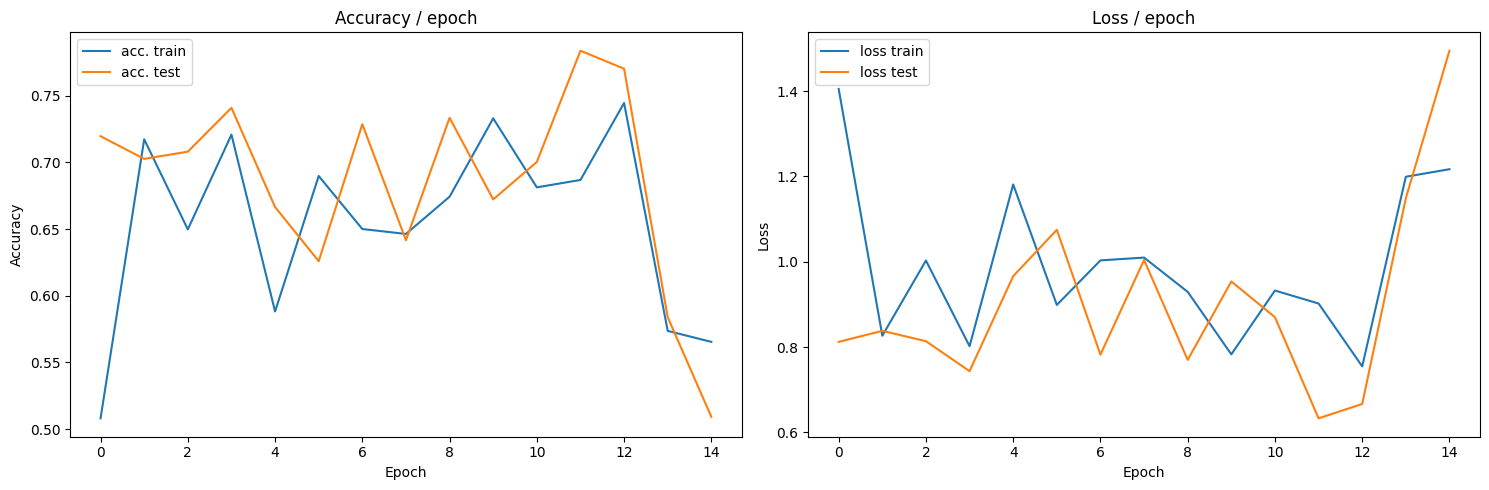

In [37]:
plt.figure(figsize=(15, 5))
# plt.clf()
plt.subplot(1, 2, 1)
plt.plot(np.array(stats_pretrained[0]), label="acc. train")
plt.plot(np.array(stats_pretrained[1]), label="acc. test")
plt.title("Accuracy / epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.array(stats_pretrained[2]), label="loss train")
plt.plot(np.array(stats_pretrained[3]), label="loss test")
plt.title("Loss / epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("stats_vit_pretrained_15.pdf", dpi=100, bbox_inches="tight")

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.